In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/lish-moa/train_targets_scored.csv
/kaggle/input/lish-moa/train_targets_nonscored.csv
/kaggle/input/lish-moa/train_features.csv
/kaggle/input/lish-moa/sample_submission.csv
/kaggle/input/lish-moa/test_features.csv


In [2]:
! pip install iterative-stratification

In [96]:
        
import torch
import torch.nn as nn
from torch.nn import functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torch.utils.data.dataset import random_split
from torch.optim.lr_scheduler import ReduceLROnPlateau



import numpy as np 
import pandas as pd 
from IPython.display import clear_output
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm, tnrange

from iterstrat.ml_stratifiers import MultilabelStratifiedKFold


plt.rcParams['figure.figsize'] = 35, 7

CGREEN  = '\33[32m'
CBLUE =  '\033[34m'
CRED = '\033[1;31m'
CEND  = '\33[0m'

def seed_everything(seed=42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    
seed_everything(seed=42)

In [4]:
if torch.cuda.is_available():
    device='cuda'
else:
    device='cpu'
    
device

'cuda'

In [5]:

train_features = pd.read_csv('../input/lish-moa/train_features.csv')

train_targets = pd.read_csv('../input/lish-moa/train_targets_scored.csv')

test_features = pd.read_csv('../input/lish-moa/test_features.csv')


In [6]:
def preprocess(df):
    df = df.copy()
    df.loc[:, 'cp_type'] = df.loc[:, 'cp_type'].map({'trt_cp': 0, 'ctl_vehicle': 1})
    df.loc[:, 'cp_dose'] = df.loc[:, 'cp_dose'].map({'D1': 0, 'D2': 1})
    return df

train = preprocess(train_features)
test = preprocess(test_features)

del train_targets['sig_id']

target = train_targets.loc[train['cp_type']==0].reset_index(drop=True)
train = train.loc[train['cp_type']==0].reset_index(drop=True)

In [7]:
top_features = [  1,   2,   3,   4,   5,   6,   7,   9,  11,  14,  15,  16,  17,
        18,  19,  20,  21,  22,  23,  24,  25,  26,  27,  29,  30,  31,
        32,  33,  35,  36,  37,  38,  39,  40,  41,  42,  43,  44,  46,
        47,  48,  49,  50,  51,  52,  53,  54,  55,  56,  58,  59,  60,
        61,  62,  63,  64,  65,  66,  67,  68,  69,  70,  71,  72,  73,
        74,  75,  76,  78,  79,  80,  81,  82,  83,  84,  86,  87,  88,
        89,  90,  91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101,
       102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114,
       115, 116, 117, 118, 120, 121, 122, 123, 124, 125, 126, 127, 128,
       129, 130, 131, 132, 133, 136, 137, 138, 139, 140, 141, 142, 143,
       144, 145, 146, 147, 149, 150, 151, 152, 153, 154, 155, 156, 157,
       158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170,
       171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183,
       184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 197,
       198, 199, 200, 202, 203, 204, 205, 206, 208, 209, 210, 211, 212,
       213, 214, 215, 216, 217, 218, 219, 220, 221, 223, 224, 225, 226,
       227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237, 238, 239,
       240, 242, 243, 244, 245, 246, 247, 248, 249, 250, 251, 252, 253,
       254, 255, 256, 257, 258, 259, 260, 261, 262, 263, 264, 265, 266,
       267, 268, 269, 271, 272, 273, 274, 275, 276, 277, 278, 279, 280,
       281, 282, 283, 284, 285, 286, 287, 288, 289, 290, 291, 292, 294,
       295, 296, 298, 300, 301, 302, 303, 304, 305, 306, 307, 308, 309,
       310, 311, 312, 314, 315, 316, 317, 318, 319, 320, 321, 322, 323,
       324, 325, 326, 327, 328, 329, 330, 331, 332, 333, 334, 335, 336,
       337, 338, 339, 340, 341, 342, 343, 344, 345, 346, 347, 348, 349,
       350, 351, 352, 353, 354, 355, 356, 357, 358, 359, 360, 361, 362,
       363, 364, 365, 366, 367, 368, 369, 370, 371, 374, 375, 376, 377,
       378, 379, 380, 381, 382, 383, 384, 385, 386, 387, 388, 390, 391,
       392, 393, 394, 395, 396, 397, 398, 399, 400, 401, 402, 403, 404,
       405, 406, 407, 408, 409, 411, 412, 413, 414, 415, 416, 417, 418,
       419, 420, 421, 422, 423, 424, 425, 426, 427, 428, 429, 430, 431,
       432, 434, 435, 436, 437, 438, 439, 440, 442, 443, 444, 445, 446,
       447, 448, 449, 450, 453, 454, 456, 457, 458, 459, 460, 461, 462,
       463, 464, 465, 466, 467, 468, 469, 470, 471, 472, 473, 474, 475,
       476, 477, 478, 479, 481, 482, 483, 484, 485, 486, 487, 488, 489,
       490, 491, 492, 493, 494, 495, 496, 498, 500, 501, 502, 503, 505,
       506, 507, 509, 510, 511, 512, 513, 514, 515, 518, 519, 520, 521,
       522, 523, 524, 525, 526, 527, 528, 530, 531, 532, 534, 535, 536,
       538, 539, 540, 541, 542, 543, 544, 545, 546, 547, 549, 550, 551,
       552, 554, 557, 559, 560, 561, 562, 565, 566, 567, 568, 569, 570,
       571, 572, 573, 574, 575, 577, 578, 580, 581, 582, 583, 584, 585,
       586, 587, 588, 589, 590, 591, 592, 593, 594, 595, 596, 597, 599,
       600, 601, 602, 606, 607, 608, 609, 611, 612, 613, 615, 616, 617,
       618, 619, 620, 621, 622, 623, 624, 625, 626, 627, 628, 629, 630,
       631, 632, 633, 634, 635, 636, 637, 638, 639, 641, 642, 643, 644,
       645, 646, 647, 648, 649, 650, 651, 652, 654, 655, 656, 658, 659,
       660, 661, 662, 663, 664, 665, 666, 667, 668, 669, 670, 671, 672,
       673, 674, 675, 676, 677, 678, 679, 680, 681, 682, 683, 684, 685,
       686, 687, 688, 689, 691, 692, 693, 694, 695, 696, 697, 699, 700,
       701, 702, 704, 705, 707, 708, 709, 710, 711, 713, 714, 716, 717,
       718, 720, 721, 723, 724, 725, 726, 727, 728, 729, 730, 731, 732,
       733, 734, 735, 737, 738, 739, 740, 742, 743, 744, 745, 746, 747,
       748, 749, 750, 751, 752, 753, 754, 755, 756, 757, 759, 760, 761,
       762, 763, 764, 765, 766, 767, 768, 769, 770, 771, 772, 773, 774,
       775, 776, 777, 779, 780, 781, 782, 783, 784, 785, 786, 787, 788,
       789, 790, 792, 793, 794, 795, 796, 797, 798, 800, 801, 802, 803,
       804, 805, 806, 808, 809, 811, 813, 814, 815, 816, 817, 818, 819,
       821, 822, 823, 825, 826, 827, 828, 829, 830, 831, 832, 834, 835,
       837, 838, 839, 840, 841, 842, 845, 846, 847, 848, 850, 851, 852,
       854, 855, 856, 858, 859, 860, 861, 862, 864, 866, 867, 868, 869,
       870, 871, 872, 873, 874]

In [8]:
all_columns = train.columns
train=train[all_columns[top_features]]
test = test[all_columns[top_features]]

In [9]:
train = train.values
test = test.values
target = target.values


In [10]:
train.shape, test.shape, target.shape

((21948, 785), (3982, 785), (21948, 206))

In [11]:
class TrainDataset(Dataset):
    def __init__(self, train,targets, noise ):
        
        self.features  = train
        self.targets = targets
        self.noise = noise
        
    def sizes(self):
        print("features size = ", self.features.shape[1])
        print("targets size = ", self.targets.shape[1])

        
    def __len__(self):
        return self.features.shape[0]

    def __getitem__(self, idx):
        feature = torch.tensor(self.features[idx]).float()
        
#         if self.noise == True:
# #             print("noisy boi")
#             feature  = feature + torch.randn_like(feature)/150
            
        target = torch.tensor(self.targets[idx]).float()
        
        return feature, target

In [12]:
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']
        
def show_lr(learning_rates):
    plt.plot(learning_rates, label = "learning rate")
    plt.ylabel("Learning rate", fontsize = 15)
    plt.grid(True)
    plt.legend()
    plt.show()

def train_step(x, y, model, optimizer, criterion):
    optimizer.zero_grad()
    pred = model(x.to(device))
    y = y.float()
    loss = criterion(pred,y.to(device))
    loss.backward()
    optimizer.step()
    return loss.item()

## Train test split for testing 

In [13]:
def validate_fn(model, val_loader, criterion, device):
    model.eval()
    losses = []
    with torch.no_grad():
        for batch in val_loader:
            x, y = batch 
            pred = model(x.to(device))
            loss = criterion(pred.cpu(),y).item()
            losses.append(loss)
    return np.array(losses).mean()

def create_weights_from_val_losses(val_losses_np):
    w = 1/val_losses_np
    w_norm = w/w.max()
    return w_norm


def train_one_fold(model,num_epochs , train_loader,val_loader, optimizer, scheduler, criterion, fold_number = 1, show_plots = False, train = True, validate = True):
    
    losses = []
    val_losses = []
    learning_rates = []    
    best_loss = 1000000

    for epoch in range(num_epochs):

            
        if train == True:
            model.train()
            losses_temp = []
            for batch in train_loader:
                (x_batch, y_batch) = batch
                loss = train_step(x_batch.to(device), y_batch.to(device), model, optimizer, criterion)
                losses_temp.append(loss)
            losses.append(torch.mean(torch.tensor(losses_temp)))
            
            if scheduler is not None:
                scheduler.step(1.)   ## lr decay caller 

            learning_rates.append(get_lr(optimizer))
            

        if validate == True:
            val_losses.append(validate_fn(model, val_loader, criterion, device))
            

        
        if train == True:
            print ("epoch ", epoch+1, " out of ", num_epochs, end = "      >" )

            if val_losses[-1] <= best_loss:

                print(CGREEN, "Val loss decreased from:", best_loss, " to ", val_losses[-1], CEND, end = "   >")
                best_loss = val_losses[-1]
                name = "./model_" + str(fold_number)+".pth"
                print("saving model as: ", name)
                torch.save(model.state_dict(), name)

            else: 
                print("showing no improvements, best loss yet:", best_loss)

        if show_plots == True:

            show_lr(learning_rates)
            plt.plot(val_losses, label = "val")
            plt.axhline(min(val_losses), linestyle = "--", c = "r")
            plt.legend()
            plt.grid()
            plt.show()


            plt.plot(val_losses[4:], label = "val after main drop", c = "g")
            plt.axhline(min(val_losses), linestyle = "--", c = "r")
            plt.legend()
            plt.grid()
            plt.show()


            plt.plot(losses, label = "train")
            plt.legend()
            plt.grid()
            plt.show()
        
    if train == True:
        return min(val_losses), name
    else:
        return min(val_losses)

## Creating folds for training 

In [48]:
train_main = train[:-1000]
target_main = target[:-1000]

train_hold = train[-1000:]
target_hold = target[-1000:]

hold_dataset = TrainDataset(train_hold, target_hold, noise = False)
hold_loader = DataLoader(dataset=hold_dataset, batch_size=512, shuffle= False)

In [49]:
num_folds = 10

mskf = MultilabelStratifiedKFold(n_splits=num_folds, shuffle=True, random_state=0)

train_loaders = []
val_loaders = []

for k , (train_idx,valid_idx) in enumerate(mskf.split(train_main,target_main)):

    x_train,x_valid,y_train,y_valid = train_main[train_idx,:],train_main[valid_idx,:],target_main[train_idx,:],target_main[valid_idx,:]

    input_size = x_train.shape[1]
    output_size = target.shape[1]


    train_dataset = TrainDataset(x_train, y_train, noise = False)
    valid_dataset = TrainDataset(x_valid, y_valid, noise = False)

    train_loader = DataLoader(dataset=train_dataset, batch_size=128, shuffle=True)

    val_loader = DataLoader(dataset=valid_dataset, batch_size=256, shuffle = False)
    
    train_loaders.append(train_loader)
    val_loaders.append(val_loader)

print(len(train_loader), "batches ")
print(len(val_loader), " batches ")

/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass shuffle=True, random_state=0 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


148 batches 
9  batches 


# Model 1 

In [50]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.batch_norm1 = nn.BatchNorm1d(785)
        self.dropout1 = nn.Dropout(0.2)
        self.dense1 = nn.utils.weight_norm(nn.Linear(785, 2048))
        
        self.batch_norm2 = nn.BatchNorm1d(2048)
        self.dropout2 = nn.Dropout(0.5)
        self.dense2 = nn.utils.weight_norm(nn.Linear(2048, 1048))
        
        self.batch_norm3 = nn.BatchNorm1d(1048)
        self.dropout3 = nn.Dropout(0.5)
        self.dense3 = nn.utils.weight_norm(nn.Linear(1048, 206))
    
    def forward(self, x):
        x = self.batch_norm1(x)
        x = self.dropout1(x)
        x = F.relu(self.dense1(x))
        
        x = self.batch_norm2(x)
        x = self.dropout2(x)
        x = F.relu(self.dense2(x))
        
        x = self.batch_norm3(x)
        x = self.dropout3(x)
        x = self.dense3(x)
        
        return x

# Model 1 training 

In [51]:
model_filenames = []
val_losses = []
model_classes = []

num_epochs = 55 ## changes here 

k = 0
for train_loader, val_loader in zip(train_loaders,val_loaders):
    model = Model()
    model_classes.append(Model())
    model = model.to(device)
    optimizer = optim.Adam(model.parameters(), lr = 0.004299882049752947, weight_decay=1e-5)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 
                                                     mode='min', 
                                                     factor=0.1, ## wooo hoo
                                                     patience=7, ## was 3 for 158 
                                                     eps=1e-4, 
                                                     verbose=True)


    criterion = nn.BCEWithLogitsLoss()

    val_loss, filename = train_one_fold(model, num_epochs , train_loader,val_loader, optimizer, scheduler, criterion, fold_number = k+1)
    
    print("hold loss: ", str(validate_fn(model, hold_loader, criterion, device)))
    val_losses.append(val_loss)
    model_filenames.append(filename)
    k+=1
    
print(CBLUE, "Training complete", CEND)

epoch  1  out of  55      > Val loss decreased from: 1000000  to  0.020741388201713562    >saving model as:  ./model_1.pth
epoch  2  out of  55      > Val loss decreased from: 0.020741388201713562  to  0.019257705244753096    >saving model as:  ./model_1.pth
epoch  3  out of  55      > Val loss decreased from: 0.019257705244753096  to  0.01820120153327783    >saving model as:  ./model_1.pth
epoch  4  out of  55      > Val loss decreased from: 0.01820120153327783  to  0.017878685146570206    >saving model as:  ./model_1.pth
epoch  5  out of  55      > Val loss decreased from: 0.017878685146570206  to  0.017540869613488514    >saving model as:  ./model_1.pth
epoch  6  out of  55      > Val loss decreased from: 0.017540869613488514  to  0.017190731854902372    >saving model as:  ./model_1.pth
epoch  7  out of  55      > Val loss decreased from: 0.017190731854902372  to  0.01704859919846058    >saving model as:  ./model_1.pth
epoch  8  out of  55      >showing no improvements, best loss ye

epoch  15  out of  55      >showing no improvements, best loss yet: 0.01580411961509122
epoch  16  out of  55      > Val loss decreased from: 0.01580411961509122  to  0.0157600287348032    >saving model as:  ./model_2.pth
Epoch    17: reducing learning rate of group 0 to 4.2999e-05.
epoch  17  out of  55      > Val loss decreased from: 0.0157600287348032  to  0.015736692895491917    >saving model as:  ./model_2.pth
epoch  18  out of  55      > Val loss decreased from: 0.015736692895491917  to  0.015724436690409977    >saving model as:  ./model_2.pth
epoch  19  out of  55      > Val loss decreased from: 0.015724436690409977  to  0.01568338181823492    >saving model as:  ./model_2.pth
epoch  20  out of  55      >showing no improvements, best loss yet: 0.01568338181823492
epoch  21  out of  55      > Val loss decreased from: 0.01568338181823492  to  0.01564595765537686    >saving model as:  ./model_2.pth
epoch  22  out of  55      > Val loss decreased from: 0.01564595765537686  to  0.0156

epoch  29  out of  55      > Val loss decreased from: 0.015932631575398974  to  0.01592884295516544    >saving model as:  ./model_3.pth
epoch  30  out of  55      >showing no improvements, best loss yet: 0.01592884295516544
epoch  31  out of  55      >showing no improvements, best loss yet: 0.01592884295516544
epoch  32  out of  55      > Val loss decreased from: 0.01592884295516544  to  0.015914383861753676    >saving model as:  ./model_3.pth
epoch  33  out of  55      >showing no improvements, best loss yet: 0.015914383861753676
epoch  34  out of  55      >showing no improvements, best loss yet: 0.015914383861753676
epoch  35  out of  55      >showing no improvements, best loss yet: 0.015914383861753676
epoch  36  out of  55      >showing no improvements, best loss yet: 0.015914383861753676
epoch  37  out of  55      > Val loss decreased from: 0.015914383861753676  to  0.015891275472111173    >saving model as:  ./model_3.pth
epoch  38  out of  55      >showing no improvements, best l

epoch  46  out of  55      >showing no improvements, best loss yet: 0.016402567115922768
epoch  47  out of  55      >showing no improvements, best loss yet: 0.016402567115922768
epoch  48  out of  55      >showing no improvements, best loss yet: 0.016402567115922768
epoch  49  out of  55      >showing no improvements, best loss yet: 0.016402567115922768
epoch  50  out of  55      > Val loss decreased from: 0.016402567115922768  to  0.016377003553013008    >saving model as:  ./model_4.pth
epoch  51  out of  55      >showing no improvements, best loss yet: 0.016377003553013008
epoch  52  out of  55      >showing no improvements, best loss yet: 0.016377003553013008
epoch  53  out of  55      >showing no improvements, best loss yet: 0.016377003553013008
epoch  54  out of  55      >showing no improvements, best loss yet: 0.016377003553013008
epoch  55  out of  55      >showing no improvements, best loss yet: 0.016377003553013008
hold loss:  0.015713561791926622
epoch  1  out of  55      > V

epoch  5  out of  55      > Val loss decreased from: 0.01787383585340447  to  0.017607179159919422    >saving model as:  ./model_6.pth
epoch  6  out of  55      > Val loss decreased from: 0.017607179159919422  to  0.017229636303252645    >saving model as:  ./model_6.pth
epoch  7  out of  55      > Val loss decreased from: 0.017229636303252645  to  0.017217819371985063    >saving model as:  ./model_6.pth
epoch  8  out of  55      > Val loss decreased from: 0.017217819371985063  to  0.017014783807098866    >saving model as:  ./model_6.pth
Epoch     9: reducing learning rate of group 0 to 4.2999e-04.
epoch  9  out of  55      >showing no improvements, best loss yet: 0.017014783807098866
epoch  10  out of  55      > Val loss decreased from: 0.017014783807098866  to  0.01648132647905085    >saving model as:  ./model_6.pth
epoch  11  out of  55      > Val loss decreased from: 0.01648132647905085  to  0.016345880201293364    >saving model as:  ./model_6.pth
epoch  12  out of  55      > Val lo

epoch  18  out of  55      > Val loss decreased from: 0.016118971527450614  to  0.016066153430276446    >saving model as:  ./model_7.pth
epoch  19  out of  55      > Val loss decreased from: 0.016066153430276446  to  0.01600764598697424    >saving model as:  ./model_7.pth
epoch  20  out of  55      >showing no improvements, best loss yet: 0.01600764598697424
epoch  21  out of  55      >showing no improvements, best loss yet: 0.01600764598697424
epoch  22  out of  55      > Val loss decreased from: 0.01600764598697424  to  0.016000735780431166    >saving model as:  ./model_7.pth
epoch  23  out of  55      > Val loss decreased from: 0.016000735780431166  to  0.0159749078253905    >saving model as:  ./model_7.pth
epoch  24  out of  55      >showing no improvements, best loss yet: 0.0159749078253905
epoch  25  out of  55      > Val loss decreased from: 0.0159749078253905  to  0.01596727180812094    >saving model as:  ./model_7.pth
epoch  26  out of  55      >showing no improvements, best l

epoch  32  out of  55      > Val loss decreased from: 0.015758913320799667  to  0.015756000868148275    >saving model as:  ./model_8.pth
epoch  33  out of  55      >showing no improvements, best loss yet: 0.015756000868148275
epoch  34  out of  55      > Val loss decreased from: 0.015756000868148275  to  0.015744096806479826    >saving model as:  ./model_8.pth
epoch  35  out of  55      > Val loss decreased from: 0.015744096806479826  to  0.01574142753250069    >saving model as:  ./model_8.pth
epoch  36  out of  55      >showing no improvements, best loss yet: 0.01574142753250069
epoch  37  out of  55      >showing no improvements, best loss yet: 0.01574142753250069
epoch  38  out of  55      >showing no improvements, best loss yet: 0.01574142753250069
epoch  39  out of  55      >showing no improvements, best loss yet: 0.01574142753250069
epoch  40  out of  55      > Val loss decreased from: 0.01574142753250069  to  0.015732366902132828    >saving model as:  ./model_8.pth
epoch  41  ou

epoch  50  out of  55      >showing no improvements, best loss yet: 0.01592225322706832
epoch  51  out of  55      >showing no improvements, best loss yet: 0.01592225322706832
epoch  52  out of  55      >showing no improvements, best loss yet: 0.01592225322706832
epoch  53  out of  55      >showing no improvements, best loss yet: 0.01592225322706832
epoch  54  out of  55      >showing no improvements, best loss yet: 0.01592225322706832
epoch  55  out of  55      >showing no improvements, best loss yet: 0.01592225322706832
hold loss:  0.015674810856580734
epoch  1  out of  55      > Val loss decreased from: 1000000  to  0.020814384437269635    >saving model as:  ./model_10.pth
epoch  2  out of  55      > Val loss decreased from: 0.020814384437269635  to  0.01903304395576318    >saving model as:  ./model_10.pth
epoch  3  out of  55      > Val loss decreased from: 0.01903304395576318  to  0.01858619310789638    >saving model as:  ./model_10.pth
epoch  4  out of  55      > Val loss decreas

In [52]:
model_filenames

['./model_1.pth',
 './model_2.pth',
 './model_3.pth',
 './model_4.pth',
 './model_5.pth',
 './model_6.pth',
 './model_7.pth',
 './model_8.pth',
 './model_9.pth',
 './model_10.pth']

# Model 2 

In [53]:
class Model_2(nn.Module):
    def __init__(self):
        super(Model_2, self).__init__()
        self.batch_norm1 = nn.BatchNorm1d(785)
        self.dropout1 = nn.Dropout(0.5)
        self.dense1 = nn.utils.weight_norm(nn.Linear(785, 790))
        
#         self.batch_norm2 = nn.BatchNorm1d(900)
#         self.dropout2 = nn.Dropout(0.5)
#         self.dense2 = nn.utils.weight_norm(nn.Linear(900, 900))
        
        self.batch_norm3 = nn.BatchNorm1d(790)
        self.dense3 = nn.utils.weight_norm(nn.Linear(790, 206))
    
    def forward(self, x):
        x = self.batch_norm1(x)
        x = self.dropout1(x)
        x = F.relu(self.dense1(x))
        
#         x = self.batch_norm2(x)
#         x = self.dropout2(x)
#         x = F.leaky_relu(self.dense2(x))
        
        x = self.batch_norm3(x)
        x = self.dense3(x)
        
        return x

# Model 2 training

In [56]:
num_epochs = 70 ## changes here 

k = 0
for train_loader, val_loader in zip(train_loaders,val_loaders):
    model = Model_2()
    model_classes.append(Model_2())
    model = model.to(device)
    optimizer = optim.Adam(model.parameters(), lr = 4e-3, weight_decay=1e-5)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 
                                                     mode='min', 
                                                     factor=0.1, ## wooo hoo
                                                     patience=7, ## was 3 for 158 
                                                     eps=1e-4, 
                                                     verbose=True)


    criterion = nn.BCEWithLogitsLoss()

    val_loss, filename = train_one_fold(model, num_epochs , train_loader,val_loader, optimizer, scheduler, criterion, fold_number = 100 + k + 1)
    print("hold loss: ", str(validate_fn(model, hold_loader, criterion, device)))


    val_losses.append(val_loss)
    model_filenames.append(filename)
    
    k+=1
    
print(CBLUE, "Training complete", CEND)

epoch  1  out of  70      > Val loss decreased from: 1000000  to  0.02035102889769607    >saving model as:  ./model_101.pth
epoch  2  out of  70      > Val loss decreased from: 0.02035102889769607  to  0.01933687014712228    >saving model as:  ./model_101.pth
epoch  3  out of  70      > Val loss decreased from: 0.01933687014712228  to  0.01816186039812035    >saving model as:  ./model_101.pth
epoch  4  out of  70      >showing no improvements, best loss yet: 0.01816186039812035
epoch  5  out of  70      > Val loss decreased from: 0.01816186039812035  to  0.017415914684534073    >saving model as:  ./model_101.pth
epoch  6  out of  70      > Val loss decreased from: 0.017415914684534073  to  0.017385970387193892    >saving model as:  ./model_101.pth
epoch  7  out of  70      > Val loss decreased from: 0.017385970387193892  to  0.017281332570645545    >saving model as:  ./model_101.pth
epoch  8  out of  70      > Val loss decreased from: 0.017281332570645545  to  0.017151870040429965    >

epoch  4  out of  70      > Val loss decreased from: 0.017704684287309647  to  0.01724769775238302    >saving model as:  ./model_102.pth
epoch  5  out of  70      > Val loss decreased from: 0.01724769775238302  to  0.017111646632353466    >saving model as:  ./model_102.pth
epoch  6  out of  70      > Val loss decreased from: 0.017111646632353466  to  0.017023442623515923    >saving model as:  ./model_102.pth
epoch  7  out of  70      > Val loss decreased from: 0.017023442623515923  to  0.017015499890678458    >saving model as:  ./model_102.pth
epoch  8  out of  70      > Val loss decreased from: 0.017015499890678458  to  0.01697781506097979    >saving model as:  ./model_102.pth
Epoch     9: reducing learning rate of group 0 to 4.0000e-04.
epoch  9  out of  70      > Val loss decreased from: 0.01697781506097979  to  0.016927365420593157    >saving model as:  ./model_102.pth
epoch  10  out of  70      > Val loss decreased from: 0.016927365420593157  to  0.01635160959429211    >saving mod

epoch  1  out of  70      > Val loss decreased from: 1000000  to  0.02088458153108756    >saving model as:  ./model_103.pth
epoch  2  out of  70      > Val loss decreased from: 0.02088458153108756  to  0.019516676250431273    >saving model as:  ./model_103.pth
epoch  3  out of  70      > Val loss decreased from: 0.019516676250431273  to  0.018356343110402424    >saving model as:  ./model_103.pth
epoch  4  out of  70      > Val loss decreased from: 0.018356343110402424  to  0.017885333134068385    >saving model as:  ./model_103.pth
epoch  5  out of  70      > Val loss decreased from: 0.017885333134068385  to  0.0175731283509069    >saving model as:  ./model_103.pth
epoch  6  out of  70      > Val loss decreased from: 0.0175731283509069  to  0.01744544319808483    >saving model as:  ./model_103.pth
epoch  7  out of  70      >showing no improvements, best loss yet: 0.01744544319808483
epoch  8  out of  70      > Val loss decreased from: 0.01744544319808483  to  0.017248981528811984    >sa

epoch  69  out of  70      >showing no improvements, best loss yet: 0.016159760248329904
epoch  70  out of  70      >showing no improvements, best loss yet: 0.016159760248329904
hold loss:  0.01590441958978772
epoch  1  out of  70      > Val loss decreased from: 1000000  to  0.02114369057946735    >saving model as:  ./model_104.pth
epoch  2  out of  70      > Val loss decreased from: 0.02114369057946735  to  0.01950736902654171    >saving model as:  ./model_104.pth
epoch  3  out of  70      > Val loss decreased from: 0.01950736902654171  to  0.01877526566386223    >saving model as:  ./model_104.pth
epoch  4  out of  70      > Val loss decreased from: 0.01877526566386223  to  0.01840673852711916    >saving model as:  ./model_104.pth
epoch  5  out of  70      > Val loss decreased from: 0.01840673852711916  to  0.018125566550427012    >saving model as:  ./model_104.pth
epoch  6  out of  70      > Val loss decreased from: 0.018125566550427012  to  0.01803174687342511    >saving model as:  

epoch  68  out of  70      >showing no improvements, best loss yet: 0.01669939338333077
epoch  69  out of  70      >showing no improvements, best loss yet: 0.01669939338333077
epoch  70  out of  70      >showing no improvements, best loss yet: 0.01669939338333077
hold loss:  0.015881381928920746
epoch  1  out of  70      > Val loss decreased from: 1000000  to  0.020684107310242124    >saving model as:  ./model_105.pth
epoch  2  out of  70      > Val loss decreased from: 0.020684107310242124  to  0.019690946779317327    >saving model as:  ./model_105.pth
epoch  3  out of  70      > Val loss decreased from: 0.019690946779317327  to  0.018756962070862453    >saving model as:  ./model_105.pth
epoch  4  out of  70      > Val loss decreased from: 0.018756962070862453  to  0.01796224547757043    >saving model as:  ./model_105.pth
epoch  5  out of  70      > Val loss decreased from: 0.01796224547757043  to  0.01765854677392377    >saving model as:  ./model_105.pth
epoch  6  out of  70      >sh

epoch  1  out of  70      > Val loss decreased from: 1000000  to  0.020392374859915838    >saving model as:  ./model_106.pth
epoch  2  out of  70      > Val loss decreased from: 0.020392374859915838  to  0.018890584715538554    >saving model as:  ./model_106.pth
epoch  3  out of  70      > Val loss decreased from: 0.018890584715538554  to  0.018109581329756312    >saving model as:  ./model_106.pth
epoch  4  out of  70      > Val loss decreased from: 0.018109581329756312  to  0.017560162684983678    >saving model as:  ./model_106.pth
epoch  5  out of  70      > Val loss decreased from: 0.017560162684983678  to  0.01736642565164301    >saving model as:  ./model_106.pth
epoch  6  out of  70      >showing no improvements, best loss yet: 0.01736642565164301
epoch  7  out of  70      > Val loss decreased from: 0.01736642565164301  to  0.017323846618334453    >saving model as:  ./model_106.pth
epoch  8  out of  70      >showing no improvements, best loss yet: 0.017323846618334453
Epoch     9:

epoch  3  out of  70      > Val loss decreased from: 0.019200797710153792  to  0.018359722362624273    >saving model as:  ./model_107.pth
epoch  4  out of  70      > Val loss decreased from: 0.018359722362624273  to  0.01780623777045144    >saving model as:  ./model_107.pth
epoch  5  out of  70      > Val loss decreased from: 0.01780623777045144  to  0.01748076267540455    >saving model as:  ./model_107.pth
epoch  6  out of  70      >showing no improvements, best loss yet: 0.01748076267540455
epoch  7  out of  70      > Val loss decreased from: 0.01748076267540455  to  0.017391362951861486    >saving model as:  ./model_107.pth
epoch  8  out of  70      >showing no improvements, best loss yet: 0.017391362951861486
Epoch     9: reducing learning rate of group 0 to 4.0000e-04.
epoch  9  out of  70      > Val loss decreased from: 0.017391362951861486  to  0.017331014076868694    >saving model as:  ./model_107.pth
epoch  10  out of  70      > Val loss decreased from: 0.017331014076868694  t

epoch  6  out of  70      >showing no improvements, best loss yet: 0.01727094066639741
epoch  7  out of  70      > Val loss decreased from: 0.01727094066639741  to  0.01726972342779239    >saving model as:  ./model_108.pth
epoch  8  out of  70      >showing no improvements, best loss yet: 0.01726972342779239
Epoch     9: reducing learning rate of group 0 to 4.0000e-04.
epoch  9  out of  70      > Val loss decreased from: 0.01726972342779239  to  0.017132299124366708    >saving model as:  ./model_108.pth
epoch  10  out of  70      > Val loss decreased from: 0.017132299124366708  to  0.01652848720550537    >saving model as:  ./model_108.pth
epoch  11  out of  70      > Val loss decreased from: 0.01652848720550537  to  0.01641248270041413    >saving model as:  ./model_108.pth
epoch  12  out of  70      > Val loss decreased from: 0.01641248270041413  to  0.016409874376323488    >saving model as:  ./model_108.pth
epoch  13  out of  70      > Val loss decreased from: 0.016409874376323488  to

epoch  6  out of  70      > Val loss decreased from: 0.01753454924457603  to  0.017482700964642897    >saving model as:  ./model_109.pth
epoch  7  out of  70      > Val loss decreased from: 0.017482700964642897  to  0.017362259949247043    >saving model as:  ./model_109.pth
epoch  8  out of  70      >showing no improvements, best loss yet: 0.017362259949247043
Epoch     9: reducing learning rate of group 0 to 4.0000e-04.
epoch  9  out of  70      >showing no improvements, best loss yet: 0.017362259949247043
epoch  10  out of  70      > Val loss decreased from: 0.017362259949247043  to  0.01682133889860577    >saving model as:  ./model_109.pth
epoch  11  out of  70      > Val loss decreased from: 0.01682133889860577  to  0.016654833012984857    >saving model as:  ./model_109.pth
epoch  12  out of  70      > Val loss decreased from: 0.016654833012984857  to  0.016600608101321593    >saving model as:  ./model_109.pth
epoch  13  out of  70      > Val loss decreased from: 0.0166006081013215

epoch  6  out of  70      > Val loss decreased from: 0.017493123706016276  to  0.01720432098954916    >saving model as:  ./model_110.pth
epoch  7  out of  70      > Val loss decreased from: 0.01720432098954916  to  0.017065409674412675    >saving model as:  ./model_110.pth
epoch  8  out of  70      >showing no improvements, best loss yet: 0.017065409674412675
Epoch     9: reducing learning rate of group 0 to 4.0000e-04.
epoch  9  out of  70      > Val loss decreased from: 0.017065409674412675  to  0.016929118790560298    >saving model as:  ./model_110.pth
epoch  10  out of  70      > Val loss decreased from: 0.016929118790560298  to  0.016507131978869438    >saving model as:  ./model_110.pth
epoch  11  out of  70      > Val loss decreased from: 0.016507131978869438  to  0.016356972253157034    >saving model as:  ./model_110.pth
epoch  12  out of  70      > Val loss decreased from: 0.016356972253157034  to  0.016325798610018358    >saving model as:  ./model_110.pth
epoch  13  out of  70

# Model blending

In [156]:
class blend(nn.Module):
    def __init__(self,weights, model_list ,model_filenames, device = device):
        super(blend, self).__init__()
#         print("loading models...")
        self.model_filenames = model_filenames
        self.model_list = model_list
        self.weights = weights 

        for i in range(len(self.model_filenames)):
            self.model_list[i].load_state_dict(torch.load(self.model_filenames[i]))
            self.model_list[i].to(device)
            self.model_list[i].eval()
            
#         print("done loading from", self.model_filenames)

    def forward(self, x):
        
        x_list = [self.model_list[i](x).detach().cpu() for i in range(len(self.model_list))]
        
        final_pred = torch.zeros_like(x_list[0])
        
        for i in range(len(x_list)):
            final_pred += x_list[i] * self.weights[i]
            
        final_pred = final_pred/self.weights.sum()
        
        return final_pred.cpu()

In [76]:
model_filenames

['./model_1.pth',
 './model_2.pth',
 './model_3.pth',
 './model_4.pth',
 './model_5.pth',
 './model_6.pth',
 './model_7.pth',
 './model_8.pth',
 './model_9.pth',
 './model_10.pth',
 './model_101.pth',
 './model_102.pth',
 './model_103.pth',
 './model_104.pth',
 './model_105.pth',
 './model_106.pth',
 './model_107.pth',
 './model_108.pth',
 './model_109.pth',
 './model_110.pth']

In [78]:
len(model_filenames), len(model_classes)

(20, 20)

In [79]:
weights = create_weights_from_val_losses(np.array(val_losses))
bb = blend(
    weights = weights, 
    model_list = model_classes,
    model_filenames = model_filenames
)

In [82]:
all_models = model_classes
test_val_losses = {}

for i in range(len(model_filenames)):
    all_models[i].load_state_dict(torch.load(model_filenames[i]))
    all_models[i].to(device)
    all_models[i].eval()
    
all_val_losses = []

with torch.no_grad():
    for i in range(len(all_models)):
        val_loss = validate_fn(all_models[i], hold_loader, criterion, device)
        test_val_losses["model_" + str(i+1)] = val_loss
    print("done validating")

test_val_losses

done validating


{'model_1': 0.01564141921699047,
 'model_2': 0.015526802279055119,
 'model_3': 0.015613585244864225,
 'model_4': 0.015638076700270176,
 'model_5': 0.01564281666651368,
 'model_6': 0.015649843495339155,
 'model_7': 0.015611793845891953,
 'model_8': 0.015669104643166065,
 'model_9': 0.015600994694977999,
 'model_10': 0.015595791395753622,
 'model_11': 0.015869300812482834,
 'model_12': 0.01578893791884184,
 'model_13': 0.01586213242262602,
 'model_14': 0.01581975817680359,
 'model_15': 0.01584784034639597,
 'model_16': 0.015809901989996433,
 'model_17': 0.01579947443678975,
 'model_18': 0.015830914955586195,
 'model_19': 0.01583934761583805,
 'model_20': 0.015777305234223604}

In [83]:
hold_loss = validate_fn(bb, hold_loader, criterion, device)
test_val_losses["model_blend"] = hold_loss


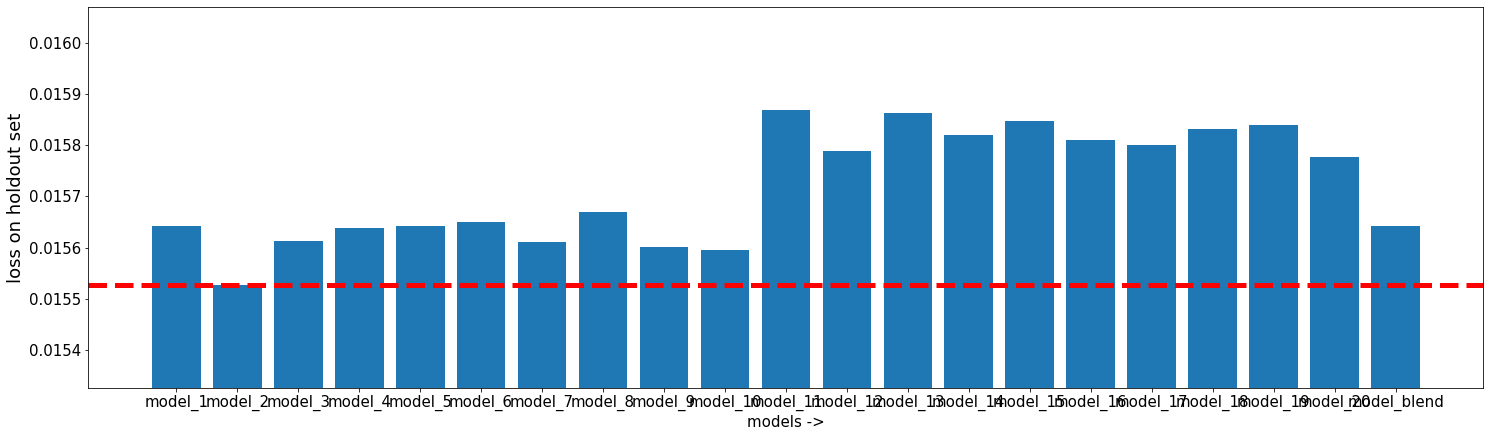

In [84]:
plt.rcParams.update({'font.size': 15})

names = test_val_losses.keys()
vals = test_val_losses.values()

plt.bar(names, vals)
plt.ylim(min(vals)- .0002, max(vals) + 0.0002)
plt.ylabel("loss on holdout set", fontsize = 18)
plt.xlabel("models ->", fontsize = 15)
plt.axhline(y = min(vals), linestyle = "--", c = "r", linewidth = 5)
plt.show()

# Finding good weights, better than the ones made from val losses 

In [85]:
import optuna

In [157]:
def validate_trial(model_classes, model_filenames, val_loader, criterion, device, params):
    bb = blend(
    weights = np.array(list(params.values())), 
    model_list = model_classes,
    model_filenames = model_filenames
    )
    
    loss_ = validate_fn(bb,val_loader, criterion, device)
    return loss_

In [158]:
def objective(trial):
    params = {
        "w1": trial.suggest_uniform("w1", 0.1, 1.0),
        "w2": trial.suggest_uniform("w2", 0.1, 1.0),
        "w3": trial.suggest_uniform("w3", 0.1, 1.0),
        "w4": trial.suggest_uniform("w4", 0.1, 1.0),
        "w5": trial.suggest_uniform("w5", 0.1, 1.0),
        "w6": trial.suggest_uniform("w6", 0.1, 1.0),
        "w7": trial.suggest_uniform("w7", 0.1, 1.0),
        "w8": trial.suggest_uniform("w8", 0.1, 1.0),
        "w9": trial.suggest_uniform("w9", 0.1, 1.0),
        "w10": trial.suggest_uniform("w10", 0.001, 1.0),
        "w11": trial.suggest_uniform("w11", 0.1, 1.0),
        "w12": trial.suggest_uniform("w12", 0.1, 1.0),
        "w13": trial.suggest_uniform("w13", 0.1, 1.0),
        "w14": trial.suggest_uniform("w14", 0.1, 1.0),
        "w15": trial.suggest_uniform("w15", 0.1, 1.0),
        "w16": trial.suggest_uniform("w16", 0.1, 1.0),
        "w17": trial.suggest_uniform("w17", 0.1, 1.0),
        "w18": trial.suggest_uniform("w18", 0.1, 1.0),
        "w19": trial.suggest_uniform("w19", 0.1, 1.0),
        "w20": trial.suggest_uniform("w20", 0.001, 1.0)

    }
    loss_ = validate_trial(model_classes, model_filenames, hold_loader,criterion, device, params) 
    return loss_


In [159]:
study = optuna.create_study(direction="minimize")


[I 2020-10-01 10:43:24,109] A new study created in memory with name: no-name-b916fee9-f91d-415a-a976-af039d513df8


In [160]:
study.optimize(objective, n_trials=800)

[I 2020-10-01 10:43:25,838] Trial 0 finished with value: 0.015529056545346975 and parameters: {'w1': 0.9526050132780084, 'w2': 0.16055980648594678, 'w3': 0.9139969809991059, 'w4': 0.31574069445693853, 'w5': 0.8401008779995548, 'w6': 0.5157770805701181, 'w7': 0.9227653481338298, 'w8': 0.38596751120236383, 'w9': 0.13634941662724254, 'w10': 0.4369296791463855, 'w11': 0.9235272126558992, 'w12': 0.5217075744015693, 'w13': 0.6887592321419052, 'w14': 0.8062771891731567, 'w15': 0.6398092382436907, 'w16': 0.9479576986307469, 'w17': 0.20669584971153776, 'w18': 0.7803218308500586, 'w19': 0.7283607297605272, 'w20': 0.7692412817791566}. Best is trial 0 with value: 0.015529056545346975.
[I 2020-10-01 10:43:26,066] Trial 1 finished with value: 0.015521734021604061 and parameters: {'w1': 0.21530820852466237, 'w2': 0.8007858377122914, 'w3': 0.3090011262760092, 'w4': 0.4311296858784235, 'w5': 0.8816044744064209, 'w6': 0.3775315957409958, 'w7': 0.81780670939176, 'w8': 0.626333536363275, 'w9': 0.526453194

[I 2020-10-01 10:43:28,639] Trial 12 finished with value: 0.015486171469092369 and parameters: {'w1': 0.69968659931129, 'w2': 0.35340904709807447, 'w3': 0.9987983545452198, 'w4': 0.645750373066456, 'w5': 0.6752065646699845, 'w6': 0.9931334953017442, 'w7': 0.9662660544976783, 'w8': 0.1542917993749961, 'w9': 0.9709001315276402, 'w10': 0.18038533826601533, 'w11': 0.5315060714603338, 'w12': 0.1008121366348851, 'w13': 0.10449257309845697, 'w14': 0.4552962659670792, 'w15': 0.27502181763859673, 'w16': 0.7716720645951598, 'w17': 0.755505236513977, 'w18': 0.3918877092623153, 'w19': 0.15885611674010225, 'w20': 0.41131258323538145}. Best is trial 11 with value: 0.015486158896237612.
[I 2020-10-01 10:43:28,911] Trial 13 finished with value: 0.015489150770008564 and parameters: {'w1': 0.6392371628491269, 'w2': 0.33643188563817394, 'w3': 0.9984962103616598, 'w4': 0.721769793801454, 'w5': 0.6752752439769846, 'w6': 0.9670972543848274, 'w7': 0.9881438929016426, 'w8': 0.29586226448927005, 'w9': 0.998096

[I 2020-10-01 10:43:31,607] Trial 23 finished with value: 0.015477171633392572 and parameters: {'w1': 0.9184959269231684, 'w2': 0.651785025536672, 'w3': 0.923353992788432, 'w4': 0.8605039843937472, 'w5': 0.7505553868030961, 'w6': 0.7306539833203961, 'w7': 0.8908019666596972, 'w8': 0.2982882141304045, 'w9': 0.46348768049794936, 'w10': 0.6656635831929938, 'w11': 0.26984753507832626, 'w12': 0.3274406141048892, 'w13': 0.35687354354667444, 'w14': 0.5416400502141135, 'w15': 0.37530559272781444, 'w16': 0.17731542302873535, 'w17': 0.5584433244490997, 'w18': 0.12874913216160172, 'w19': 0.49997180389800894, 'w20': 0.3125723653545649}. Best is trial 23 with value: 0.015477171633392572.
[I 2020-10-01 10:43:31,871] Trial 24 finished with value: 0.01547571923583746 and parameters: {'w1': 0.9821693322519679, 'w2': 0.6446419867334938, 'w3': 0.9156461909821251, 'w4': 0.8667437306377853, 'w5': 0.9358003619030701, 'w6': 0.7227946977826317, 'w7': 0.8754137954232378, 'w8': 0.4075317523030965, 'w9': 0.46535

[I 2020-10-01 10:43:34,597] Trial 34 finished with value: 0.015481854323297739 and parameters: {'w1': 0.40774238146045405, 'w2': 0.8711781581696276, 'w3': 0.4685250430014374, 'w4': 0.9857706470739659, 'w5': 0.8910948976914398, 'w6': 0.553732391058387, 'w7': 0.5899744597650948, 'w8': 0.7332530576504603, 'w9': 0.7615152195981109, 'w10': 0.5508981998242843, 'w11': 0.627664476240815, 'w12': 0.6814621266757117, 'w13': 0.10031333612027026, 'w14': 0.1341135667681483, 'w15': 0.19565424529998562, 'w16': 0.4764525283933113, 'w17': 0.8875872310096381, 'w18': 0.24302063874421848, 'w19': 0.5746903454386606, 'w20': 0.005056196727297679}. Best is trial 26 with value: 0.015470946207642555.
[I 2020-10-01 10:43:34,863] Trial 35 finished with value: 0.015481620095670223 and parameters: {'w1': 0.8862514196355091, 'w2': 0.7062610803548152, 'w3': 0.6184160748304708, 'w4': 0.8095144904528682, 'w5': 0.9988552537504076, 'w6': 0.6085376993748983, 'w7': 0.7087480065480304, 'w8': 0.542146901770126, 'w9': 0.585676

[I 2020-10-01 10:43:38,061] Trial 46 finished with value: 0.015485388692468405 and parameters: {'w1': 0.7623465561106851, 'w2': 0.9287367229726827, 'w3': 0.9629368582558921, 'w4': 0.3124987921073909, 'w5': 0.4283220940538947, 'w6': 0.37016429872067785, 'w7': 0.9420412336222456, 'w8': 0.5148200130429128, 'w9': 0.41513026062489183, 'w10': 0.5387961449102575, 'w11': 0.3348735299572009, 'w12': 0.40673511417947306, 'w13': 0.4796972196890226, 'w14': 0.28920613008716234, 'w15': 0.698456524325228, 'w16': 0.5886462391549768, 'w17': 0.11324540918659243, 'w18': 0.22112204903029045, 'w19': 0.444755918165507, 'w20': 0.08329564289901674}. Best is trial 44 with value: 0.015470472164452076.
[I 2020-10-01 10:43:38,325] Trial 47 finished with value: 0.015486618038266897 and parameters: {'w1': 0.686707930361528, 'w2': 0.709676562955149, 'w3': 0.9616922829593654, 'w4': 0.2190270302771321, 'w5': 0.36384522911090145, 'w6': 0.4938431394626618, 'w7': 0.9335111499215663, 'w8': 0.6360944774654933, 'w9': 0.54865

[I 2020-10-01 10:43:41,221] Trial 58 finished with value: 0.015480095520615578 and parameters: {'w1': 0.7175407105650521, 'w2': 0.6525170409239192, 'w3': 0.7992933460230152, 'w4': 0.8610450725168832, 'w5': 0.4273440825948608, 'w6': 0.5073857967175489, 'w7': 0.45496213117031786, 'w8': 0.4450058214219896, 'w9': 0.4240923756678322, 'w10': 0.7684215027398547, 'w11': 0.5087826714716115, 'w12': 0.431729880424632, 'w13': 0.12183450568385207, 'w14': 0.3747826714220972, 'w15': 0.10211647657232675, 'w16': 0.16718098490618144, 'w17': 0.608241443171745, 'w18': 0.24838878809511322, 'w19': 0.5145717897802584, 'w20': 0.16209138237791015}. Best is trial 44 with value: 0.015470472164452076.
[I 2020-10-01 10:43:41,480] Trial 59 finished with value: 0.01548089599236846 and parameters: {'w1': 0.8778012712334851, 'w2': 0.8987438877902544, 'w3': 0.7495942057467766, 'w4': 0.15169433493418838, 'w5': 0.2892187869270911, 'w6': 0.5543220898792567, 'w7': 0.6674333950484485, 'w8': 0.6007114197285263, 'w9': 0.69033

[I 2020-10-01 10:43:44,120] Trial 69 finished with value: 0.015477102249860764 and parameters: {'w1': 0.9628161980214882, 'w2': 0.5058954821116214, 'w3': 0.9312409172160844, 'w4': 0.8230438149498599, 'w5': 0.9987807768077083, 'w6': 0.6780903857932408, 'w7': 0.9588353275500549, 'w8': 0.42420409846752244, 'w9': 0.49336358342747233, 'w10': 0.6226044003252784, 'w11': 0.2619034658070129, 'w12': 0.3105425274998239, 'w13': 0.13896715817201022, 'w14': 0.2859806337395724, 'w15': 0.37582765762038645, 'w16': 0.31468602603774376, 'w17': 0.8425922432365306, 'w18': 0.21637778320745144, 'w19': 0.5332555277770994, 'w20': 0.4206722047288458}. Best is trial 44 with value: 0.015470472164452076.
[I 2020-10-01 10:43:44,387] Trial 70 finished with value: 0.015478103421628475 and parameters: {'w1': 0.7803814428972637, 'w2': 0.4136126400407728, 'w3': 0.9760039331100445, 'w4': 0.6519991407317818, 'w5': 0.9485223161568666, 'w6': 0.6276751762019014, 'w7': 0.34120766341487524, 'w8': 0.38842102105192705, 'w9': 0.5

[I 2020-10-01 10:43:47,242] Trial 80 finished with value: 0.015477192588150501 and parameters: {'w1': 0.7387901829524117, 'w2': 0.3761643633558609, 'w3': 0.8597292278135809, 'w4': 0.9290119533321197, 'w5': 0.8940522439722078, 'w6': 0.9133543000866992, 'w7': 0.7956315426259518, 'w8': 0.16964689741119557, 'w9': 0.23040087542378535, 'w10': 0.9579777602848438, 'w11': 0.16307069578701247, 'w12': 0.14113776412342466, 'w13': 0.12079368528475207, 'w14': 0.10142678427038321, 'w15': 0.12234928967395381, 'w16': 0.5245849331386081, 'w17': 0.6054203065703984, 'w18': 0.10998373509921441, 'w19': 0.8726439687362959, 'w20': 0.6859468519247457}. Best is trial 44 with value: 0.015470472164452076.
[I 2020-10-01 10:43:47,501] Trial 81 finished with value: 0.015473865903913975 and parameters: {'w1': 0.8267897885158522, 'w2': 0.5561467867524891, 'w3': 0.8632373400435446, 'w4': 0.9536357321097647, 'w5': 0.9307691795979816, 'w6': 0.8737862557295537, 'w7': 0.8274371307023872, 'w8': 0.19701720567378575, 'w9': 0.

[I 2020-10-01 10:43:50,189] Trial 91 finished with value: 0.015470310114324093 and parameters: {'w1': 0.921174686645133, 'w2': 0.6312050491039918, 'w3': 0.9498305082689564, 'w4': 0.8855086629015484, 'w5': 0.9294060787623566, 'w6': 0.7598671380381958, 'w7': 0.9316366025963346, 'w8': 0.30522067249397716, 'w9': 0.47656757309439285, 'w10': 0.9839678446561159, 'w11': 0.2581114767220843, 'w12': 0.11757430929005158, 'w13': 0.16741774105432175, 'w14': 0.12097221967567505, 'w15': 0.10131837156633144, 'w16': 0.39437722553771215, 'w17': 0.7604811858718656, 'w18': 0.15396499748297116, 'w19': 0.6494155853906068, 'w20': 0.5695925345724242}. Best is trial 91 with value: 0.015470310114324093.
[I 2020-10-01 10:43:50,455] Trial 92 finished with value: 0.015473803039640188 and parameters: {'w1': 0.8434270887160941, 'w2': 0.5190590774618521, 'w3': 0.9059811537222829, 'w4': 0.8878624056732928, 'w5': 0.9189219279881462, 'w6': 0.7657943126129347, 'w7': 0.9258212570708167, 'w8': 0.2836264453242478, 'w9': 0.47

[I 2020-10-01 10:43:53,177] Trial 102 finished with value: 0.015481813345104456 and parameters: {'w1': 0.9280226695560613, 'w2': 0.4767786901214032, 'w3': 0.5292691450134843, 'w4': 0.9775293659486647, 'w5': 0.9250084014830467, 'w6': 0.9609969162386526, 'w7': 0.969455777185381, 'w8': 0.133236826904855, 'w9': 0.45414070830187825, 'w10': 0.937376286962253, 'w11': 0.262153979204638, 'w12': 0.12285306460704726, 'w13': 0.7043206526821331, 'w14': 0.10035648217505219, 'w15': 0.18134662146362915, 'w16': 0.4345504979812777, 'w17': 0.7638351222403127, 'w18': 0.1420933366073106, 'w19': 0.8289226424732798, 'w20': 0.5778086654433137}. Best is trial 91 with value: 0.015470310114324093.
[I 2020-10-01 10:43:53,448] Trial 103 finished with value: 0.015472462866455317 and parameters: {'w1': 0.949838327584716, 'w2': 0.5104443389381247, 'w3': 0.8726375435527973, 'w4': 0.9361774532316287, 'w5': 0.890223181307503, 'w6': 0.9245611094473518, 'w7': 0.8629999010253475, 'w8': 0.18767351478882371, 'w9': 0.40734197

[I 2020-10-01 10:43:56,172] Trial 113 finished with value: 0.015469872392714024 and parameters: {'w1': 0.9830400722967799, 'w2': 0.6480476004719805, 'w3': 0.9823812652108311, 'w4': 0.9958842898730162, 'w5': 0.6483886615682771, 'w6': 0.9396406360153621, 'w7': 0.9984941412941477, 'w8': 0.15197085321506862, 'w9': 0.5027008287366285, 'w10': 0.7972752333377979, 'w11': 0.14889863404647813, 'w12': 0.10423929723948758, 'w13': 0.2634107855176336, 'w14': 0.18690907776533833, 'w15': 0.11050237331966889, 'w16': 0.3315210734626149, 'w17': 0.19523127345747954, 'w18': 0.32233052120600186, 'w19': 0.7054155789509173, 'w20': 0.6382323920203546}. Best is trial 108 with value: 0.0154694770462811.
[I 2020-10-01 10:43:56,442] Trial 114 finished with value: 0.015470355283468962 and parameters: {'w1': 0.9853863783964145, 'w2': 0.6489307433416551, 'w3': 0.9856265587951575, 'w4': 0.9896861232457534, 'w5': 0.6624720126671547, 'w6': 0.9680534388345093, 'w7': 0.9518354049794878, 'w8': 0.1391481420835753, 'w9': 0.4

[I 2020-10-01 10:43:59,355] Trial 124 finished with value: 0.015469400212168694 and parameters: {'w1': 0.9585608681445121, 'w2': 0.718162370781511, 'w3': 0.9999029782702162, 'w4': 0.9799160344838321, 'w5': 0.6954100188087471, 'w6': 0.9472482622563507, 'w7': 0.9993967818460554, 'w8': 0.10897119325595105, 'w9': 0.5573224263367081, 'w10': 0.8304981181115022, 'w11': 0.14003822569025196, 'w12': 0.10328114993074083, 'w13': 0.29436508661092464, 'w14': 0.14345615796692499, 'w15': 0.12057405154052422, 'w16': 0.2932417223325568, 'w17': 0.20481644392795223, 'w18': 0.45199601445516346, 'w19': 0.6943924232285538, 'w20': 0.6363111354178467}. Best is trial 122 with value: 0.015468817669898272.
[I 2020-10-01 10:43:59,634] Trial 125 finished with value: 0.015469190664589405 and parameters: {'w1': 0.9585512071528669, 'w2': 0.7289357813739765, 'w3': 0.9656066114254654, 'w4': 0.9641372851417367, 'w5': 0.6939342577139104, 'w6': 0.9402136018329179, 'w7': 0.9989465066330713, 'w8': 0.11108290000679401, 'w9': 

[I 2020-10-01 10:44:02,525] Trial 135 finished with value: 0.015468077268451452 and parameters: {'w1': 0.9460191400387844, 'w2': 0.8062570874912257, 'w3': 0.9980265255626537, 'w4': 0.998621676442503, 'w5': 0.7506986126173549, 'w6': 0.9926169093750428, 'w7': 0.9992358513990279, 'w8': 0.12577632754106324, 'w9': 0.5819532663149753, 'w10': 0.8788226221557573, 'w11': 0.12790313935048764, 'w12': 0.10068846275669231, 'w13': 0.3073814806075977, 'w14': 0.16527051937329154, 'w15': 0.13272337085849292, 'w16': 0.2698906945602513, 'w17': 0.15258371066554596, 'w18': 0.4736619205582974, 'w19': 0.631959993001897, 'w20': 0.7487531335225539}. Best is trial 135 with value: 0.015468077268451452.
[I 2020-10-01 10:44:02,842] Trial 136 finished with value: 0.015467635821551085 and parameters: {'w1': 0.9469380224450157, 'w2': 0.7916982560721484, 'w3': 0.9979757824634148, 'w4': 0.9981883482900107, 'w5': 0.7424266482098122, 'w6': 0.9968550496558573, 'w7': 0.9784113686908344, 'w8': 0.12404210774079592, 'w9': 0.5

[I 2020-10-01 10:44:05,676] Trial 146 finished with value: 0.01546975364908576 and parameters: {'w1': 0.9425910063634957, 'w2': 0.8284293946398924, 'w3': 0.933568173858112, 'w4': 0.9660487978526245, 'w5': 0.7302073338368892, 'w6': 0.9976535595336216, 'w7': 0.9530050568645037, 'w8': 0.1658689840530656, 'w9': 0.5382154057071826, 'w10': 0.8544748478852666, 'w11': 0.1670447673030479, 'w12': 0.1539614548675062, 'w13': 0.3254519217780767, 'w14': 0.12628135400516644, 'w15': 0.1571897952125249, 'w16': 0.18149620578584738, 'w17': 0.13835232082381754, 'w18': 0.5794883638328463, 'w19': 0.6387319152350959, 'w20': 0.7669276267777093}. Best is trial 136 with value: 0.015467635821551085.
[I 2020-10-01 10:44:05,963] Trial 147 finished with value: 0.015476256143301725 and parameters: {'w1': 0.9665320977920365, 'w2': 0.8591904936499289, 'w3': 0.9662596010540503, 'w4': 0.9995898202103356, 'w5': 0.748615902997023, 'w6': 0.12123732772838008, 'w7': 0.9243147386670683, 'w8': 0.12674381910314023, 'w9': 0.6172

[I 2020-10-01 10:44:08,920] Trial 157 finished with value: 0.015468541998416185 and parameters: {'w1': 0.9983387705425318, 'w2': 0.7644645473731178, 'w3': 0.9558557332684051, 'w4': 0.9446862612100005, 'w5': 0.6783958828210102, 'w6': 0.9834870894294987, 'w7': 0.9510851789590015, 'w8': 0.10367395580376726, 'w9': 0.6433795523774797, 'w10': 0.9520973168361605, 'w11': 0.1059194134824127, 'w12': 0.19534744243039198, 'w13': 0.36648691863361826, 'w14': 0.11104962960518382, 'w15': 0.15531415143907, 'w16': 0.19679485363451418, 'w17': 0.16221514925979483, 'w18': 0.43251535341689284, 'w19': 0.6397489534106311, 'w20': 0.7602928994353104}. Best is trial 136 with value: 0.015467635821551085.
[I 2020-10-01 10:44:09,243] Trial 158 finished with value: 0.015468047466129065 and parameters: {'w1': 0.9245487592806836, 'w2': 0.7648926912672113, 'w3': 0.95603335146955, 'w4': 0.9198831904193177, 'w5': 0.6620695585723645, 'w6': 0.977364524558076, 'w7': 0.9506580321912206, 'w8': 0.13406722265860574, 'w9': 0.641

[I 2020-10-01 10:44:12,460] Trial 168 finished with value: 0.015469091944396496 and parameters: {'w1': 0.8888114965348078, 'w2': 0.7671129253675172, 'w3': 0.9169109094783585, 'w4': 0.8981862460865451, 'w5': 0.6086011923810107, 'w6': 0.9828009769801365, 'w7': 0.8937180925803144, 'w8': 0.20399949517263039, 'w9': 0.7060942717673977, 'w10': 0.9677866549270193, 'w11': 0.10864156930714451, 'w12': 0.23837347669789494, 'w13': 0.4050103136592476, 'w14': 0.10128183906317903, 'w15': 0.28027312503200147, 'w16': 0.11568254705007841, 'w17': 0.10753158994871787, 'w18': 0.42268573539467913, 'w19': 0.5704056499722714, 'w20': 0.6846521797793389}. Best is trial 136 with value: 0.015467635821551085.
[I 2020-10-01 10:44:12,757] Trial 169 finished with value: 0.01546972943469882 and parameters: {'w1': 0.8712297026150336, 'w2': 0.7464323950944438, 'w3': 0.9198106165765533, 'w4': 0.8798956892561806, 'w5': 0.574052908697873, 'w6': 0.9989574152934921, 'w7': 0.8978637383186849, 'w8': 0.1664187712965742, 'w9': 0.

[I 2020-10-01 10:44:15,834] Trial 179 finished with value: 0.015476780012249947 and parameters: {'w1': 0.8676602409873171, 'w2': 0.8604245522161963, 'w3': 0.9109232304158783, 'w4': 0.8659747540442456, 'w5': 0.5429818659077538, 'w6': 0.9994975794670437, 'w7': 0.8812554653052123, 'w8': 0.1971470732654366, 'w9': 0.7307883121895222, 'w10': 0.9472189694335539, 'w11': 0.775126148193104, 'w12': 0.24376083226640574, 'w13': 0.3525691380671512, 'w14': 0.10053823681897975, 'w15': 0.32620175425162723, 'w16': 0.1355470475131492, 'w17': 0.10066539412750708, 'w18': 0.39704935016847903, 'w19': 0.5774076136813244, 'w20': 0.7619918191606816}. Best is trial 171 with value: 0.015467545483261347.
[I 2020-10-01 10:44:16,120] Trial 180 finished with value: 0.015469333622604609 and parameters: {'w1': 0.8739901108038384, 'w2': 0.8071005622341167, 'w3': 0.902860458901197, 'w4': 0.8342785324565372, 'w5': 0.6572911984001396, 'w6': 0.9641174349296205, 'w7': 0.9255574232234823, 'w8': 0.18538043253500136, 'w9': 0.77

[I 2020-10-01 10:44:19,017] Trial 190 finished with value: 0.015467384830117226 and parameters: {'w1': 0.785694484200834, 'w2': 0.9912963682998648, 'w3': 0.9362183006636151, 'w4': 0.7524561504191455, 'w5': 0.5936602729557142, 'w6': 0.9541329094805311, 'w7': 0.9074535040057401, 'w8': 0.24155558235691352, 'w9': 0.9576829669120945, 'w10': 0.9089926987812302, 'w11': 0.16406864189063897, 'w12': 0.28740239559131325, 'w13': 0.4506898011682537, 'w14': 0.12658070885334824, 'w15': 0.2444407166153221, 'w16': 0.10284976792029284, 'w17': 0.10149350612303473, 'w18': 0.37974236171619097, 'w19': 0.4861861211078409, 'w20': 0.7040843563323769}. Best is trial 188 with value: 0.015467367600649595.
[I 2020-10-01 10:44:19,299] Trial 191 finished with value: 0.015467561781406403 and parameters: {'w1': 0.8362602649388245, 'w2': 0.984347206029629, 'w3': 0.928091380711878, 'w4': 0.7601912557281993, 'w5': 0.5559795305682597, 'w6': 0.9993261419960536, 'w7': 0.8982940793086541, 'w8': 0.24750055789899883, 'w9': 0.9

[I 2020-10-01 10:44:22,420] Trial 201 finished with value: 0.015475985128432512 and parameters: {'w1': 0.794885587776716, 'w2': 0.9341720699322217, 'w3': 0.9423214587377606, 'w4': 0.7759827385451112, 'w5': 0.5628723621031014, 'w6': 0.9639358704949449, 'w7': 0.8967258198037017, 'w8': 0.2537759803818124, 'w9': 0.9961740280963995, 'w10': 0.9153000330200424, 'w11': 0.18488542770691957, 'w12': 0.23565767343498129, 'w13': 0.4437341787610879, 'w14': 0.9452399579079659, 'w15': 0.2613035236612347, 'w16': 0.10000965091688396, 'w17': 0.14380083171219396, 'w18': 0.2889719445169336, 'w19': 0.43205970729653037, 'w20': 0.800354045534698}. Best is trial 188 with value: 0.015467367600649595.
[I 2020-10-01 10:44:22,723] Trial 202 finished with value: 0.015468529425561428 and parameters: {'w1': 0.8291671791937923, 'w2': 0.9084116538401124, 'w3': 0.949387614857173, 'w4': 0.8153219602246304, 'w5': 0.5900516766657485, 'w6': 0.9716994938166981, 'w7': 0.8613476492604859, 'w8': 0.22148025096746138, 'w9': 0.910

[I 2020-10-01 10:44:25,731] Trial 212 finished with value: 0.015467465855181217 and parameters: {'w1': 0.7899417028760357, 'w2': 0.9992895162490623, 'w3': 0.9298624162398121, 'w4': 0.7625382125817216, 'w5': 0.4496964542861718, 'w6': 0.8997885609848194, 'w7': 0.8713075768571975, 'w8': 0.27628644875547476, 'w9': 0.9615768913760717, 'w10': 0.9571121933184069, 'w11': 0.21854878418123336, 'w12': 0.2482339870891839, 'w13': 0.4068725955848831, 'w14': 0.13382303582897587, 'w15': 0.20275907813366578, 'w16': 0.15975180168072337, 'w17': 0.10002959272544852, 'w18': 0.3047362343687182, 'w19': 0.3700982392267804, 'w20': 0.9191021987278698}. Best is trial 211 with value: 0.015466554556041956.
[I 2020-10-01 10:44:26,020] Trial 213 finished with value: 0.01546805165708065 and parameters: {'w1': 0.765855768844535, 'w2': 0.9954755374133628, 'w3': 0.9151179656201403, 'w4': 0.763903544516761, 'w5': 0.44176220521795334, 'w6': 0.9042993273687798, 'w7': 0.8650721394464483, 'w8': 0.27485875459191494, 'w9': 0.9

[I 2020-10-01 10:44:28,920] Trial 223 finished with value: 0.015467673540115356 and parameters: {'w1': 0.8253488404125073, 'w2': 0.9610137393089678, 'w3': 0.9263637014605479, 'w4': 0.7748099461379699, 'w5': 0.46054132740817516, 'w6': 0.886309145831285, 'w7': 0.8401474787062838, 'w8': 0.22399738497469832, 'w9': 0.9998494180478591, 'w10': 0.9751459753168192, 'w11': 0.1952061185267942, 'w12': 0.28644127088633375, 'w13': 0.4302888346466142, 'w14': 0.12313028718838591, 'w15': 0.22183392212942227, 'w16': 0.1377066234610683, 'w17': 0.12184294274469393, 'w18': 0.3088839523839543, 'w19': 0.3660323319464476, 'w20': 0.8924771393144939}. Best is trial 211 with value: 0.015466554556041956.
[I 2020-10-01 10:44:29,209] Trial 224 finished with value: 0.015468436758965254 and parameters: {'w1': 0.8269036797122317, 'w2': 0.9646100854150079, 'w3': 0.9221010040956079, 'w4': 0.7518598749530707, 'w5': 0.452483172217026, 'w6': 0.8838381546327216, 'w7': 0.8399858503462667, 'w8': 0.22402950042635827, 'w9': 0.9

[I 2020-10-01 10:44:32,326] Trial 234 finished with value: 0.015468987636268139 and parameters: {'w1': 0.8222595947261783, 'w2': 0.9676302044379672, 'w3': 0.9085140563747683, 'w4': 0.6956561214677456, 'w5': 0.321203152556816, 'w6': 0.9128473660320322, 'w7': 0.8543409817475833, 'w8': 0.2436514999472858, 'w9': 0.9175548408715182, 'w10': 0.9596630320485732, 'w11': 0.16856349988344377, 'w12': 0.32475017935206, 'w13': 0.4109645616551054, 'w14': 0.17048960860405638, 'w15': 0.1926978846012583, 'w16': 0.15837213488835106, 'w17': 0.11707908578556014, 'w18': 0.30948932498489484, 'w19': 0.36420410262506986, 'w20': 0.9017425807758802}. Best is trial 211 with value: 0.015466554556041956.
[I 2020-10-01 10:44:32,632] Trial 235 finished with value: 0.01547296391800046 and parameters: {'w1': 0.8045441669683313, 'w2': 0.9822652703196498, 'w3': 0.8922749724607689, 'w4': 0.7468085052876703, 'w5': 0.43201219646836136, 'w6': 0.8929727259092627, 'w7': 0.8363907194944805, 'w8': 0.27653448731767, 'w9': 0.92725

[I 2020-10-01 10:44:35,702] Trial 245 finished with value: 0.015466877724975348 and parameters: {'w1': 0.46138712334511345, 'w2': 0.9823656183367195, 'w3': 0.862754957465663, 'w4': 0.6350293934958372, 'w5': 0.528043900320332, 'w6': 0.841891859301386, 'w7': 0.784611799137522, 'w8': 0.37623470693108585, 'w9': 0.9994230758050658, 'w10': 0.9958359797791556, 'w11': 0.17319117758763036, 'w12': 0.2510475906561569, 'w13': 0.37943972234143336, 'w14': 0.11158473609214774, 'w15': 0.25788927983485727, 'w16': 0.1193041107089401, 'w17': 0.15100604796006567, 'w18': 0.24917180219737345, 'w19': 0.19290296173185267, 'w20': 0.975850342153776}. Best is trial 237 with value: 0.015466447919607162.
[I 2020-10-01 10:44:36,004] Trial 246 finished with value: 0.015467044431716204 and parameters: {'w1': 0.4397797702002813, 'w2': 0.9990998657980846, 'w3': 0.8595408967677562, 'w4': 0.6161789580022766, 'w5': 0.5341986771954882, 'w6': 0.8471988801831518, 'w7': 0.7867537563700684, 'w8': 0.3768553144362108, 'w9': 0.98

[I 2020-10-01 10:44:38,958] Trial 256 finished with value: 0.015466871205717325 and parameters: {'w1': 0.43957179823591364, 'w2': 0.999847916902457, 'w3': 0.8119659949476367, 'w4': 0.6161613007949035, 'w5': 0.5240815267295413, 'w6': 0.8116826491771072, 'w7': 0.7386100021932629, 'w8': 0.37475210628215755, 'w9': 0.9941306193456777, 'w10': 0.9970707798443731, 'w11': 0.15829299505206634, 'w12': 0.2576553860359169, 'w13': 0.37499222116174136, 'w14': 0.10032793383548796, 'w15': 0.282562735644277, 'w16': 0.11559495929648964, 'w17': 0.18281273797023112, 'w18': 0.2250049840402262, 'w19': 0.158886685112774, 'w20': 0.9916337609593375}. Best is trial 237 with value: 0.015466447919607162.
[I 2020-10-01 10:44:39,254] Trial 257 finished with value: 0.015467058401554823 and parameters: {'w1': 0.4393087015894929, 'w2': 0.995059358433274, 'w3': 0.8153127440437969, 'w4': 0.6109618162808442, 'w5': 0.5229974184133446, 'w6': 0.808884402600749, 'w7': 0.7731843059784895, 'w8': 0.3719818064987873, 'w9': 0.9991

[I 2020-10-01 10:44:42,419] Trial 267 finished with value: 0.015467065386474133 and parameters: {'w1': 0.4618308382608, 'w2': 0.9764851289313704, 'w3': 0.7680391554909347, 'w4': 0.6422223181543335, 'w5': 0.5137236036247037, 'w6': 0.8354706719155455, 'w7': 0.6921786178590318, 'w8': 0.3950103863516937, 'w9': 0.9986413757275012, 'w10': 0.998435583622814, 'w11': 0.1485944868961645, 'w12': 0.2656659719684741, 'w13': 0.33762280321202776, 'w14': 0.1001317934946095, 'w15': 0.2804746094385303, 'w16': 0.1311844675383506, 'w17': 0.20184621297967462, 'w18': 0.20878956489378098, 'w19': 0.19856431470891914, 'w20': 0.9707886152259979}. Best is trial 237 with value: 0.015466447919607162.
[I 2020-10-01 10:44:42,732] Trial 268 finished with value: 0.015467070043087006 and parameters: {'w1': 0.3957207446500184, 'w2': 0.9717425604861293, 'w3': 0.7678739696433128, 'w4': 0.6564356064175036, 'w5': 0.5120100972391604, 'w6': 0.836684423614882, 'w7': 0.7818828757672419, 'w8': 0.3445704335969372, 'w9': 0.9824029

[I 2020-10-01 10:44:45,690] Trial 278 finished with value: 0.015467947348952293 and parameters: {'w1': 0.38690372896452907, 'w2': 0.9628871812478061, 'w3': 0.855671156716912, 'w4': 0.6612339736481774, 'w5': 0.4803183267354349, 'w6': 0.7962057572589188, 'w7': 0.685409755901091, 'w8': 0.36139682429486647, 'w9': 0.982028703889158, 'w10': 0.9769609242453404, 'w11': 0.17127342787622438, 'w12': 0.2537620035520261, 'w13': 0.3252322776644201, 'w14': 0.1158720216742618, 'w15': 0.2626513826980238, 'w16': 0.1006511127674484, 'w17': 0.19012616230776228, 'w18': 0.2164713972612965, 'w19': 0.23007229368487314, 'w20': 0.9985224464345245}. Best is trial 237 with value: 0.015466447919607162.
[I 2020-10-01 10:44:45,988] Trial 279 finished with value: 0.015468095894902945 and parameters: {'w1': 0.5095302449320153, 'w2': 0.9827496851807799, 'w3': 0.8404603545689588, 'w4': 0.627620056465916, 'w5': 0.5361464582037319, 'w6': 0.8235587671756401, 'w7': 0.781402105608629, 'w8': 0.41861650609400514, 'w9': 0.99966

[I 2020-10-01 10:44:49,064] Trial 289 finished with value: 0.01546712638810277 and parameters: {'w1': 0.48558880802930227, 'w2': 0.9982751865939038, 'w3': 0.860508305676221, 'w4': 0.6363409900831907, 'w5': 0.5648468801174839, 'w6': 0.8024337836540972, 'w7': 0.7679322913941713, 'w8': 0.4417526672830846, 'w9': 0.9993266661899824, 'w10': 0.9673032147130941, 'w11': 0.1434020752263625, 'w12': 0.22821019259919698, 'w13': 0.37400251738567397, 'w14': 0.1009762508008241, 'w15': 0.26101550901934684, 'w16': 0.11755204619744718, 'w17': 0.23136896708337062, 'w18': 0.2343802513781709, 'w19': 0.26879760473077347, 'w20': 0.9610596726982575}. Best is trial 237 with value: 0.015466447919607162.
[I 2020-10-01 10:44:49,361] Trial 290 finished with value: 0.015466003213077784 and parameters: {'w1': 0.5048761784334903, 'w2': 0.9812464412657474, 'w3': 0.8269655663208378, 'w4': 0.6767349358401863, 'w5': 0.5314485939520319, 'w6': 0.8515638479740909, 'w7': 0.7458462946361637, 'w8': 0.383197634741997, 'w9': 0.98

[I 2020-10-01 10:44:52,402] Trial 300 finished with value: 0.01546869520097971 and parameters: {'w1': 0.4847116530020663, 'w2': 0.984214360527259, 'w3': 0.8506755951191016, 'w4': 0.5710495628919422, 'w5': 0.49447600823704385, 'w6': 0.7669494678213981, 'w7': 0.7142602155381166, 'w8': 0.3609082722003722, 'w9': 0.9676910375565337, 'w10': 0.9993656890694597, 'w11': 0.221364874994728, 'w12': 0.2521147173850954, 'w13': 0.3849461639738895, 'w14': 0.11746386944453138, 'w15': 0.2404267445255207, 'w16': 0.16025291454768617, 'w17': 0.15166454505512453, 'w18': 0.25594796560425376, 'w19': 0.20360877732625332, 'w20': 0.9767945263735499}. Best is trial 290 with value: 0.015466003213077784.
[I 2020-10-01 10:44:52,822] Trial 301 finished with value: 0.015466760378330946 and parameters: {'w1': 0.4315767049317218, 'w2': 0.9385017503697979, 'w3': 0.8285838416964045, 'w4': 0.694110658463233, 'w5': 0.5554540646490933, 'w6': 0.8676772052068351, 'w7': 0.7831993495029188, 'w8': 0.4175570475407531, 'w9': 0.9584

[I 2020-10-01 10:44:55,986] Trial 311 finished with value: 0.015467611607164145 and parameters: {'w1': 0.42697073491891174, 'w2': 0.9116255738272344, 'w3': 0.8417091834184789, 'w4': 0.6884114622786757, 'w5': 0.5773297464346775, 'w6': 0.8582703432618901, 'w7': 0.7934455099768679, 'w8': 0.4637019660323316, 'w9': 0.9237084256545917, 'w10': 0.9529579904312532, 'w11': 0.16040927863314988, 'w12': 0.23488050753263212, 'w13': 0.42703904000896126, 'w14': 0.1763143651995489, 'w15': 0.22527764253950744, 'w16': 0.15965409113689322, 'w17': 0.2653786525246585, 'w18': 0.23323497126732146, 'w19': 0.1297187857822786, 'w20': 0.8779164149478045}. Best is trial 290 with value: 0.015466003213077784.
[I 2020-10-01 10:44:56,398] Trial 312 finished with value: 0.015472784638404846 and parameters: {'w1': 0.3393778232498547, 'w2': 0.9368685983883915, 'w3': 0.841070073824185, 'w4': 0.7081249732612979, 'w5': 0.5551131582501871, 'w6': 0.8761072852205983, 'w7': 0.7828338979113753, 'w8': 0.41714911178467395, 'w9': 0

[I 2020-10-01 10:44:59,470] Trial 322 finished with value: 0.015466750133782625 and parameters: {'w1': 0.3190042261664202, 'w2': 0.8950462711610203, 'w3': 0.7426172521942007, 'w4': 0.6390894108572874, 'w5': 0.5879950496483086, 'w6': 0.8567245320529514, 'w7': 0.6387584939008933, 'w8': 0.4704232316323925, 'w9': 0.9617745173158845, 'w10': 0.9318090196011017, 'w11': 0.13255525710682597, 'w12': 0.19475847606155583, 'w13': 0.32233518643152703, 'w14': 0.21672797957993067, 'w15': 0.1955350541873716, 'w16': 0.13419476368311148, 'w17': 0.2759722547302449, 'w18': 0.19555695573412307, 'w19': 0.10979202179506314, 'w20': 0.8659235266078796}. Best is trial 313 with value: 0.01546541415154934.
[I 2020-10-01 10:44:59,779] Trial 323 finished with value: 0.015466168988496065 and parameters: {'w1': 0.30053945840695717, 'w2': 0.892057595111989, 'w3': 0.7307943657189423, 'w4': 0.6389223218330148, 'w5': 0.599367262622089, 'w6': 0.8537162259679071, 'w7': 0.6717137504196973, 'w8': 0.49681439292648083, 'w9': 0.

[I 2020-10-01 10:45:02,951] Trial 333 finished with value: 0.015466881915926933 and parameters: {'w1': 0.31052295583685274, 'w2': 0.8958356211333817, 'w3': 0.6882045547330706, 'w4': 0.6461780229255222, 'w5': 0.6201589792907203, 'w6': 0.8576296916492944, 'w7': 0.5983851724416374, 'w8': 0.5086863411626001, 'w9': 0.9329412446634913, 'w10': 0.9042137869681741, 'w11': 0.1238071259483216, 'w12': 0.18550133792738888, 'w13': 0.31491683669292303, 'w14': 0.2499931411650042, 'w15': 0.18134529277931824, 'w16': 0.16886640219328825, 'w17': 0.2843159408803775, 'w18': 0.15636385306207834, 'w19': 0.10035280642280438, 'w20': 0.8676409357041049}. Best is trial 313 with value: 0.01546541415154934.
[I 2020-10-01 10:45:03,340] Trial 334 finished with value: 0.015466980636119843 and parameters: {'w1': 0.2715044665615845, 'w2': 0.8784648647937415, 'w3': 0.7378557957788511, 'w4': 0.6477151090002321, 'w5': 0.6070452778406636, 'w6': 0.8345663246416813, 'w7': 0.5790868047023465, 'w8': 0.5367888052338033, 'w9': 0.

[I 2020-10-01 10:45:06,491] Trial 344 finished with value: 0.015467038378119469 and parameters: {'w1': 0.33380347365184704, 'w2': 0.9109630697064023, 'w3': 0.7359799453477942, 'w4': 0.6360449558107738, 'w5': 0.6233978674371968, 'w6': 0.8260412464028939, 'w7': 0.5624493211549679, 'w8': 0.5693532032966849, 'w9': 0.9099629936557478, 'w10': 0.9146595599853513, 'w11': 0.11197936492397936, 'w12': 0.17163515761435666, 'w13': 0.29421651035860474, 'w14': 0.22138985577296116, 'w15': 0.19090831746620537, 'w16': 0.21159049157136506, 'w17': 0.34388343843163793, 'w18': 0.1681256195614571, 'w19': 0.12062508888438772, 'w20': 0.845026227451021}. Best is trial 313 with value: 0.01546541415154934.
[I 2020-10-01 10:45:06,805] Trial 345 finished with value: 0.015467714052647352 and parameters: {'w1': 0.2639520272180258, 'w2': 0.8869913780335428, 'w3': 0.7577206571994506, 'w4': 0.6782555424299338, 'w5': 0.6116906286463395, 'w6': 0.8252938278725924, 'w7': 0.5381729841428518, 'w8': 0.5379852596557636, 'w9': 0

[I 2020-10-01 10:45:09,854] Trial 355 finished with value: 0.015466263517737389 and parameters: {'w1': 0.24551208028112675, 'w2': 0.8584040030204038, 'w3': 0.754565076219557, 'w4': 0.6787351322543436, 'w5': 0.6461238596145713, 'w6': 0.8254925965079744, 'w7': 0.5902962685646501, 'w8': 0.6773247731220012, 'w9': 0.8688243844086236, 'w10': 0.8753611468949826, 'w11': 0.10623464091558132, 'w12': 0.16035627653944245, 'w13': 0.22214811127337505, 'w14': 0.25276561047961427, 'w15': 0.1467104858754478, 'w16': 0.21214075759568646, 'w17': 0.401836546325124, 'w18': 0.11271917072615237, 'w19': 0.10054696568129066, 'w20': 0.8111838373691829}. Best is trial 352 with value: 0.015464225318282843.
[I 2020-10-01 10:45:10,166] Trial 356 finished with value: 0.01546716783195734 and parameters: {'w1': 0.2410527195555476, 'w2': 0.8517658057202027, 'w3': 0.7537179187050059, 'w4': 0.6804103559160628, 'w5': 0.6454474613859599, 'w6': 0.8224951486804057, 'w7': 0.5823942085951735, 'w8': 0.6766622285300427, 'w9': 0.8

[I 2020-10-01 10:45:13,798] Trial 366 finished with value: 0.015465754084289074 and parameters: {'w1': 0.22653327363399894, 'w2': 0.8731267734088374, 'w3': 0.7047401932361662, 'w4': 0.6943099508550474, 'w5': 0.6488694959675264, 'w6': 0.8037497932861669, 'w7': 0.6164705661813252, 'w8': 0.6221434469351614, 'w9': 0.8374697120002688, 'w10': 0.8758413151868669, 'w11': 0.1009327353308543, 'w12': 0.13861378049156758, 'w13': 0.22785940217394862, 'w14': 0.2539125864289523, 'w15': 0.15640654757865732, 'w16': 0.20918718815445503, 'w17': 0.37819380531994595, 'w18': 0.10072635208752288, 'w19': 0.10144675626373835, 'w20': 0.8058989646423905}. Best is trial 352 with value: 0.015464225318282843.
[I 2020-10-01 10:45:14,236] Trial 367 finished with value: 0.015466306358575821 and parameters: {'w1': 0.2304207975729592, 'w2': 0.8557296704163471, 'w3': 0.6988831785454824, 'w4': 0.718994341073157, 'w5': 0.6549147082674945, 'w6': 0.7801162368423553, 'w7': 0.607830972318921, 'w8': 0.6152221456036514, 'w9': 0.

[I 2020-10-01 10:45:17,658] Trial 377 finished with value: 0.01546588633209467 and parameters: {'w1': 0.22192111606455905, 'w2': 0.8471661062840298, 'w3': 0.6746389981759893, 'w4': 0.7322199352771033, 'w5': 0.6767533180737121, 'w6': 0.7043758905192239, 'w7': 0.6519556729886575, 'w8': 0.6105466615163503, 'w9': 0.8505092976855936, 'w10': 0.8020550393400974, 'w11': 0.10050224910826472, 'w12': 0.12430359301874568, 'w13': 0.18226099411912816, 'w14': 0.25253730498540283, 'w15': 0.13054391017228628, 'w16': 0.23494819845931433, 'w17': 0.45802009907056385, 'w18': 0.1019921257040926, 'w19': 0.12402106183497492, 'w20': 0.7774029374047389}. Best is trial 352 with value: 0.015464225318282843.
[I 2020-10-01 10:45:17,977] Trial 378 finished with value: 0.015466274227946997 and parameters: {'w1': 0.21927113591746125, 'w2': 0.8255537663151041, 'w3': 0.6602344882259498, 'w4': 0.7213394644693568, 'w5': 0.6834217643657489, 'w6': 0.745432021733835, 'w7': 0.6454524786012021, 'w8': 0.6089848133383212, 'w9': 

[I 2020-10-01 10:45:21,155] Trial 388 finished with value: 0.015465689357370138 and parameters: {'w1': 0.2728176287639444, 'w2': 0.8461848509658831, 'w3': 0.6910135418157534, 'w4': 0.7353059823404569, 'w5': 0.6652876665295006, 'w6': 0.6594392180641281, 'w7': 0.6088105457208549, 'w8': 0.6287948698965212, 'w9': 0.8363018276555629, 'w10': 0.7624844248877218, 'w11': 0.10072387493016338, 'w12': 0.14440542759470174, 'w13': 0.1347204719904656, 'w14': 0.2840549430036814, 'w15': 0.11612577072470451, 'w16': 0.20212391177716255, 'w17': 0.36968179136817886, 'w18': 0.1202811624007091, 'w19': 0.14484430333382314, 'w20': 0.8202059851897328}. Best is trial 352 with value: 0.015464225318282843.
[I 2020-10-01 10:45:21,466] Trial 389 finished with value: 0.015465395990759134 and parameters: {'w1': 0.27374965633621173, 'w2': 0.850234889655249, 'w3': 0.6844673490621683, 'w4': 0.7380231198520447, 'w5': 0.6664173312002114, 'w6': 0.66614520956854, 'w7': 0.6240248663341489, 'w8': 0.6017249201048911, 'w9': 0.83

[I 2020-10-01 10:45:24,590] Trial 399 finished with value: 0.01546570099890232 and parameters: {'w1': 0.2745248000377681, 'w2': 0.8440682351286783, 'w3': 0.7008097755832184, 'w4': 0.7467606762802964, 'w5': 0.7187041574691313, 'w6': 0.673474702629669, 'w7': 0.6803193080493947, 'w8': 0.6019370463804641, 'w9': 0.7970222089104787, 'w10': 0.7601973841483952, 'w11': 0.12306861515640674, 'w12': 0.10224914711291039, 'w13': 0.12250129246589661, 'w14': 0.38320387628019603, 'w15': 0.10481397398711025, 'w16': 0.19673168186638582, 'w17': 0.35688530218894365, 'w18': 0.1008794906575179, 'w19': 0.13854233673924618, 'w20': 0.8216981611375908}. Best is trial 352 with value: 0.015464225318282843.
[I 2020-10-01 10:45:25,006] Trial 400 finished with value: 0.015465542208403349 and parameters: {'w1': 0.27434005181632404, 'w2': 0.8418860230039282, 'w3': 0.6982480490667335, 'w4': 0.7506411654330465, 'w5': 0.7148436927434593, 'w6': 0.6737519950168568, 'w7': 0.6901283605493438, 'w8': 0.5995734306806563, 'w9': 0

[I 2020-10-01 10:45:28,236] Trial 410 finished with value: 0.015466674696654081 and parameters: {'w1': 0.26188797218985593, 'w2': 0.8150421251283758, 'w3': 0.7005703137617209, 'w4': 0.7325359835701268, 'w5': 0.7099140934684929, 'w6': 0.6622140660470937, 'w7': 0.6859255822348749, 'w8': 0.5989151095619845, 'w9': 0.7903150540090365, 'w10': 0.732408267544846, 'w11': 0.10082882148476412, 'w12': 0.10665115082908255, 'w13': 0.15147853709689252, 'w14': 0.42569343047685837, 'w15': 0.1003867909626738, 'w16': 0.1951223937205396, 'w17': 0.3602871484250481, 'w18': 0.1011923148259388, 'w19': 0.14248330665339473, 'w20': 0.7954938130238549}. Best is trial 352 with value: 0.015464225318282843.
[I 2020-10-01 10:45:28,559] Trial 411 finished with value: 0.015466382261365652 and parameters: {'w1': 0.237473349153195, 'w2': 0.8471423493495883, 'w3': 0.649040683215278, 'w4': 0.7580999363850898, 'w5': 0.7695666145301797, 'w6': 0.5934519067196484, 'w7': 0.698035627190464, 'w8': 0.5993136143172235, 'w9': 0.8049

[I 2020-10-01 10:45:31,658] Trial 421 finished with value: 0.01547598373144865 and parameters: {'w1': 0.24311062482818407, 'w2': 0.8535417449700321, 'w3': 0.7072629375573912, 'w4': 0.7160159857615015, 'w5': 0.7005027128261605, 'w6': 0.670346061594575, 'w7': 0.6666274858914525, 'w8': 0.5785110121977037, 'w9': 0.769082604959932, 'w10': 0.6803714206050838, 'w11': 0.13250649025938804, 'w12': 0.11826720142718329, 'w13': 0.1005445604776316, 'w14': 0.2923580668024299, 'w15': 0.9268166786639576, 'w16': 0.19636075612712478, 'w17': 0.3795591258523451, 'w18': 0.1348201051703562, 'w19': 0.1330397285232779, 'w20': 0.7581160599829921}. Best is trial 352 with value: 0.015464225318282843.
[I 2020-10-01 10:45:31,971] Trial 422 finished with value: 0.015469156205654144 and parameters: {'w1': 0.19099763420777388, 'w2': 0.7969536766870754, 'w3': 0.6830809140030402, 'w4': 0.7282302524112055, 'w5': 0.6989190462578161, 'w6': 0.6495827967098522, 'w7': 0.662207051089859, 'w8': 0.5566555902005959, 'w9': 0.83920

[I 2020-10-01 10:45:35,170] Trial 432 finished with value: 0.015470744110643864 and parameters: {'w1': 0.24632551644274664, 'w2': 0.7975917325244342, 'w3': 0.6878535234848568, 'w4': 0.8040851092373624, 'w5': 0.7780952774752687, 'w6': 0.5573818288664817, 'w7': 0.665116428660092, 'w8': 0.578253371494651, 'w9': 0.8357237631799482, 'w10': 0.7885415619068722, 'w11': 0.5336588208967397, 'w12': 0.11599521392344352, 'w13': 0.1719272648115314, 'w14': 0.285708078708497, 'w15': 0.12969387142371747, 'w16': 0.18122738393352927, 'w17': 0.3071787470210592, 'w18': 0.11726277035391285, 'w19': 0.12616141568510597, 'w20': 0.842741306220716}. Best is trial 352 with value: 0.015464225318282843.
[I 2020-10-01 10:45:35,489] Trial 433 finished with value: 0.015466703567653894 and parameters: {'w1': 0.2548796678776747, 'w2': 0.7863566173650178, 'w3': 0.6723319823251594, 'w4': 0.7989441643257593, 'w5': 0.8038840247901394, 'w6': 0.5203013766578716, 'w7': 0.6406252780439504, 'w8': 0.5512320102628457, 'w9': 0.8221

[I 2020-10-01 10:45:39,065] Trial 443 finished with value: 0.015464457217603922 and parameters: {'w1': 0.3515693884595944, 'w2': 0.8275863783596795, 'w3': 0.6683502996771811, 'w4': 0.8280531348318778, 'w5': 0.8208100433027121, 'w6': 0.5024468832577436, 'w7': 0.690837417226999, 'w8': 0.5944074486703868, 'w9': 0.7568066036798786, 'w10': 0.810095833777706, 'w11': 0.11997369802199344, 'w12': 0.11939656040581288, 'w13': 0.14835877433788736, 'w14': 0.3192739723526603, 'w15': 0.10159038353630447, 'w16': 0.2533780804532561, 'w17': 0.29869666603167466, 'w18': 0.10423119256528689, 'w19': 0.16551661727202344, 'w20': 0.7423086454118313}. Best is trial 352 with value: 0.015464225318282843.
[I 2020-10-01 10:45:39,381] Trial 444 finished with value: 0.015464814379811287 and parameters: {'w1': 0.2990660944775914, 'w2': 0.8251874640939929, 'w3': 0.6536913677444021, 'w4': 0.8315200217981625, 'w5': 0.8131627182689375, 'w6': 0.44666581550931944, 'w7': 0.6970701505100494, 'w8': 0.5429151694909613, 'w9': 0.

[I 2020-10-01 10:45:42,558] Trial 454 finished with value: 0.015463956166058779 and parameters: {'w1': 0.3597271565774476, 'w2': 0.8290629474040129, 'w3': 0.6284650248308176, 'w4': 0.8346542141871066, 'w5': 0.8126678960174547, 'w6': 0.4771224609097782, 'w7': 0.6964612784803872, 'w8': 0.5536293691863128, 'w9': 0.7560923162285721, 'w10': 0.8236633880496178, 'w11': 0.1187201880756716, 'w12': 0.12131265616938898, 'w13': 0.10202484499257666, 'w14': 0.3178064982100576, 'w15': 0.10087197441382365, 'w16': 0.25878787195333086, 'w17': 0.2711959014323181, 'w18': 0.10029217050591648, 'w19': 0.18470393333691593, 'w20': 0.7489582229315973}. Best is trial 454 with value: 0.015463956166058779.
[I 2020-10-01 10:45:42,875] Trial 455 finished with value: 0.015465212985873222 and parameters: {'w1': 0.33770827968245104, 'w2': 0.8016648047351407, 'w3': 0.609394120299058, 'w4': 0.8409761694970667, 'w5': 0.7987007431474312, 'w6': 0.43265738347284843, 'w7': 0.7039514562198826, 'w8': 0.5505940374654503, 'w9': 0

[I 2020-10-01 10:45:46,078] Trial 465 finished with value: 0.015475156251341105 and parameters: {'w1': 0.3357887208099701, 'w2': 0.8215733754762949, 'w3': 0.596016908289056, 'w4': 0.8655921738869476, 'w5': 0.8665933229078827, 'w6': 0.3561640372292278, 'w7': 0.6989650883710202, 'w8': 0.5491946476033989, 'w9': 0.7339632528822712, 'w10': 0.7940050632319844, 'w11': 0.12004853290631864, 'w12': 0.16502310242773724, 'w13': 0.868438569683142, 'w14': 0.3450328429950432, 'w15': 0.10102934731436998, 'w16': 0.3235821887400676, 'w17': 0.259815159534085, 'w18': 0.10048764971359907, 'w19': 0.21083829357736458, 'w20': 0.732694483627442}. Best is trial 454 with value: 0.015463956166058779.
[I 2020-10-01 10:45:46,393] Trial 466 finished with value: 0.015465922188013792 and parameters: {'w1': 0.348498748270353, 'w2': 0.8088930722878329, 'w3': 0.6227396076351864, 'w4': 0.8286277087399544, 'w5': 0.8142563484322248, 'w6': 0.40368264704290024, 'w7': 0.7041634715729053, 'w8': 0.524364126874513, 'w9': 0.754117

[I 2020-10-01 10:45:49,793] Trial 476 finished with value: 0.01546567166224122 and parameters: {'w1': 0.3146106687041672, 'w2': 0.8319880671984535, 'w3': 0.590673315128293, 'w4': 0.8515661780360169, 'w5': 0.8008271805273606, 'w6': 0.4654834614840882, 'w7': 0.6800692560618968, 'w8': 0.5476207175421517, 'w9': 0.7241570002965998, 'w10': 0.7899980988932445, 'w11': 0.11483129620425175, 'w12': 0.11623219059630126, 'w13': 0.14687199907595322, 'w14': 0.33206804675796997, 'w15': 0.10104189182883098, 'w16': 0.2728549515717124, 'w17': 0.2972006271179633, 'w18': 0.14920798487192516, 'w19': 0.17867367652490676, 'w20': 0.7322020304544701}. Best is trial 454 with value: 0.015463956166058779.
[I 2020-10-01 10:45:50,119] Trial 477 finished with value: 0.01547193294391036 and parameters: {'w1': 0.3698207154565581, 'w2': 0.7984195417068498, 'w3': 0.6266166006883408, 'w4': 0.8244762908991016, 'w5': 0.866460939412216, 'w6': 0.4156496471585092, 'w7': 0.730821848731021, 'w8': 0.5713535391403907, 'w9': 0.6995

[I 2020-10-01 10:45:53,470] Trial 487 finished with value: 0.015467994846403599 and parameters: {'w1': 0.3238187053937211, 'w2': 0.8309863454659777, 'w3': 0.6133464442125334, 'w4': 0.8798352709814812, 'w5': 0.8118696260035609, 'w6': 0.4717433514493901, 'w7': 0.694143601992357, 'w8': 0.5112550160960672, 'w9': 0.7524357037140146, 'w10': 0.7959144057960168, 'w11': 0.1510188622376913, 'w12': 0.16971144122520418, 'w13': 0.15415632552926653, 'w14': 0.3549896837854279, 'w15': 0.10058862944710498, 'w16': 0.37523678140321914, 'w17': 0.29720737150648124, 'w18': 0.11912758373600066, 'w19': 0.2576898110129814, 'w20': 0.7352321695105302}. Best is trial 454 with value: 0.015463956166058779.
[I 2020-10-01 10:45:53,791] Trial 488 finished with value: 0.015465856529772282 and parameters: {'w1': 0.35344999196548654, 'w2': 0.8064081389165166, 'w3': 0.6442489252344388, 'w4': 0.8304847457497772, 'w5': 0.7916067904472187, 'w6': 0.4892061526038571, 'w7': 0.6788189651271788, 'w8': 0.5517291396357533, 'w9': 0.

[I 2020-10-01 10:45:57,022] Trial 498 finished with value: 0.015463918447494507 and parameters: {'w1': 0.3789360258834124, 'w2': 0.8783935571376983, 'w3': 0.6402963545704429, 'w4': 0.8694091752640443, 'w5': 0.9058958363762597, 'w6': 0.4975015713050086, 'w7': 0.7345357538259473, 'w8': 0.49483759087223167, 'w9': 0.7855927924210147, 'w10': 0.7943791750674721, 'w11': 0.13365055403804063, 'w12': 0.11471939462592864, 'w13': 0.1478021438657775, 'w14': 0.34006314791108505, 'w15': 0.14419169443274008, 'w16': 0.2886075395965011, 'w17': 0.23405938741446647, 'w18': 0.14744929016217623, 'w19': 0.17630697490973712, 'w20': 0.6678147218009216}. Best is trial 494 with value: 0.015463804826140404.
[I 2020-10-01 10:45:57,352] Trial 499 finished with value: 0.01546406326815486 and parameters: {'w1': 0.38442358937859106, 'w2': 0.8822945351275409, 'w3': 0.6448900436572392, 'w4': 0.8914516433181142, 'w5': 0.9032850482765814, 'w6': 0.5321354742749497, 'w7': 0.7403192349736258, 'w8': 0.49124365208824133, 'w9':

[I 2020-10-01 10:46:00,847] Trial 509 finished with value: 0.015464406460523605 and parameters: {'w1': 0.39280620870546484, 'w2': 0.8852030182684008, 'w3': 0.6451574503544594, 'w4': 0.9180376765095267, 'w5': 0.913399489564404, 'w6': 0.5019298115620753, 'w7': 0.7527579687361058, 'w8': 0.48203926213617243, 'w9': 0.779872906061636, 'w10': 0.792870264950893, 'w11': 0.16177771568885807, 'w12': 0.10069661340109931, 'w13': 0.13102098021377256, 'w14': 0.3707988345885148, 'w15': 0.15150111159769883, 'w16': 0.28618301840318955, 'w17': 0.22897423070590475, 'w18': 0.1698516018829144, 'w19': 0.20381961161702644, 'w20': 0.6402358077832855}. Best is trial 494 with value: 0.015463804826140404.
[I 2020-10-01 10:46:01,177] Trial 510 finished with value: 0.015464920550584793 and parameters: {'w1': 0.3863395969993401, 'w2': 0.8816774152516121, 'w3': 0.6482101085754185, 'w4': 0.9166279701133676, 'w5': 0.9115397816890899, 'w6': 0.5047007038047095, 'w7': 0.7492596557487695, 'w8': 0.48239051022640356, 'w9': 0

[I 2020-10-01 10:46:04,482] Trial 520 finished with value: 0.015464517753571272 and parameters: {'w1': 0.4070521405953854, 'w2': 0.9054577577060678, 'w3': 0.6585855679309136, 'w4': 0.8939259491812884, 'w5': 0.9638407105388033, 'w6': 0.5043035608787089, 'w7': 0.7380933712641249, 'w8': 0.46700713503597246, 'w9': 0.794872429046749, 'w10': 0.7851347413416734, 'w11': 0.1680250795040508, 'w12': 0.10001049630703658, 'w13': 0.13984753168934594, 'w14': 0.3723771199114622, 'w15': 0.16525412260079403, 'w16': 0.2799801686068419, 'w17': 0.22463296957525747, 'w18': 0.16495164130430207, 'w19': 0.22058973189089234, 'w20': 0.6541268259377446}. Best is trial 494 with value: 0.015463804826140404.
[I 2020-10-01 10:46:04,804] Trial 521 finished with value: 0.015465021599084139 and parameters: {'w1': 0.4067727973794008, 'w2': 0.9064880182464558, 'w3': 0.6607259445240617, 'w4': 0.892776662157709, 'w5': 0.9657818567709311, 'w6': 0.5247624751637654, 'w7': 0.7330180070677419, 'w8': 0.48933176052953814, 'w9': 0.

[I 2020-10-01 10:46:08,122] Trial 531 finished with value: 0.015465287491679192 and parameters: {'w1': 0.38539314121301743, 'w2': 0.906890941373786, 'w3': 0.6691934223654405, 'w4': 0.8849930021429586, 'w5': 0.9164876368716058, 'w6': 0.5350705581530408, 'w7': 0.7657661142845072, 'w8': 0.5012466564804378, 'w9': 0.7673252473822647, 'w10': 0.8256973694319935, 'w11': 0.19868356225634962, 'w12': 0.11619388252722646, 'w13': 0.13183833267971884, 'w14': 0.36474469140693994, 'w15': 0.17626216595673525, 'w16': 0.25949129182947955, 'w17': 0.24750187527563622, 'w18': 0.18910786991765596, 'w19': 0.2448881252171899, 'w20': 0.6230761446193952}. Best is trial 494 with value: 0.015463804826140404.
[I 2020-10-01 10:46:08,495] Trial 532 finished with value: 0.015467546880245209 and parameters: {'w1': 0.41508986737823195, 'w2': 0.9269674077525892, 'w3': 0.6309722540108453, 'w4': 0.9403185943013782, 'w5': 0.89875456172032, 'w6': 0.48396743813393367, 'w7': 0.7346304597237641, 'w8': 0.5009455367984317, 'w9': 

[I 2020-10-01 10:46:12,345] Trial 542 finished with value: 0.015465844422578812 and parameters: {'w1': 0.39542252866344346, 'w2': 0.8731749137954539, 'w3': 0.6342689256252804, 'w4': 0.9132335999628086, 'w5': 0.8890993837213316, 'w6': 0.503961499401961, 'w7': 0.731919900824273, 'w8': 0.460570894696852, 'w9': 0.8000531028488798, 'w10': 0.7898510471049528, 'w11': 0.18191278235688293, 'w12': 0.1007660219576321, 'w13': 0.16592053826730913, 'w14': 0.4740395298195149, 'w15': 0.15302677911333135, 'w16': 0.25557163245806624, 'w17': 0.21176471337671043, 'w18': 0.15774588863187258, 'w19': 0.20596969405560453, 'w20': 0.6076914263605978}. Best is trial 494 with value: 0.015463804826140404.
[I 2020-10-01 10:46:12,690] Trial 543 finished with value: 0.01547520887106657 and parameters: {'w1': 0.3668899954974614, 'w2': 0.9218739853220267, 'w3': 0.6735088222100457, 'w4': 0.879313600840252, 'w5': 0.9356887839747873, 'w6': 0.5337491682640578, 'w7': 0.7691997980038233, 'w8': 0.5078084674181171, 'w9': 0.759

[I 2020-10-01 10:46:16,315] Trial 553 finished with value: 0.015465221367776394 and parameters: {'w1': 0.35817444944670035, 'w2': 0.8678622132016998, 'w3': 0.6338977657937191, 'w4': 0.8655715540412815, 'w5': 0.9303399155727214, 'w6': 0.5626302530034252, 'w7': 0.7460485598494441, 'w8': 0.48483231611505045, 'w9': 0.785215827043605, 'w10': 0.7815100120084681, 'w11': 0.1751082225522275, 'w12': 0.1322437383152244, 'w13': 0.1430023948929099, 'w14': 0.3534401484915647, 'w15': 0.17892483681371862, 'w16': 0.2889033042880358, 'w17': 0.2051255707747443, 'w18': 0.20019028431726324, 'w19': 0.1972255322364733, 'w20': 0.60336676480907}. Best is trial 494 with value: 0.015463804826140404.
[I 2020-10-01 10:46:16,657] Trial 554 finished with value: 0.01546353381127119 and parameters: {'w1': 0.41987225950508905, 'w2': 0.8873379533960258, 'w3': 0.6268381523014742, 'w4': 0.889547686967651, 'w5': 0.881781569441217, 'w6': 0.534205310367325, 'w7': 0.7618188564388487, 'w8': 0.4608727388714327, 'w9': 0.80450774

[I 2020-10-01 10:46:20,212] Trial 564 finished with value: 0.01546366885304451 and parameters: {'w1': 0.42110708210798714, 'w2': 0.8887858711934935, 'w3': 0.6502377423010895, 'w4': 0.9581763730068644, 'w5': 0.9282372512795354, 'w6': 0.5262459902007872, 'w7': 0.744294757198222, 'w8': 0.4872087363799358, 'w9': 0.7640397513054947, 'w10': 0.8066634753550272, 'w11': 0.20370063035657532, 'w12': 0.10039519728111222, 'w13': 0.11858091726473428, 'w14': 0.4107783162193474, 'w15': 0.19111407940823416, 'w16': 0.26991591391005487, 'w17': 0.1992243254626705, 'w18': 0.16464453692619185, 'w19': 0.1735799988475486, 'w20': 0.4744312991663056}. Best is trial 554 with value: 0.01546353381127119.
[I 2020-10-01 10:46:20,612] Trial 565 finished with value: 0.015465589705854654 and parameters: {'w1': 0.4204229313254645, 'w2': 0.9110464578217957, 'w3': 0.6032481311200832, 'w4': 0.9589504553636456, 'w5': 0.8928751264137197, 'w6': 0.5320048731395436, 'w7': 0.7386902663921118, 'w8': 0.4834506312038708, 'w9': 0.80

[I 2020-10-01 10:46:23,937] Trial 575 finished with value: 0.015464529860764742 and parameters: {'w1': 0.37101259233752865, 'w2': 0.8712699304786001, 'w3': 0.6400855113729513, 'w4': 0.9805852144117694, 'w5': 0.9083443949777277, 'w6': 0.5551666332616934, 'w7': 0.7239229591301867, 'w8': 0.5149901413414771, 'w9': 0.7641752924628004, 'w10': 0.7697265004183816, 'w11': 0.23322572364424982, 'w12': 0.10086483639373926, 'w13': 0.19247937663510228, 'w14': 0.35787243685283343, 'w15': 0.1400231424549457, 'w16': 0.2509416598842321, 'w17': 0.25649117494891355, 'w18': 0.14726751103138186, 'w19': 0.1654209273837327, 'w20': 0.5431834733313208}. Best is trial 554 with value: 0.01546353381127119.
[I 2020-10-01 10:46:24,268] Trial 576 finished with value: 0.01547050941735506 and parameters: {'w1': 0.39166863096203763, 'w2': 0.8653291885464612, 'w3': 0.6251368411520317, 'w4': 0.9529423524452963, 'w5': 0.8794000465860748, 'w6': 0.5808263979429049, 'w7': 0.7582608263069734, 'w8': 0.49773356116916606, 'w9': 0

[I 2020-10-01 10:46:27,713] Trial 586 finished with value: 0.015464674681425095 and parameters: {'w1': 0.3712762201013837, 'w2': 0.8626448515232975, 'w3': 0.48967381245025127, 'w4': 0.9802864239386038, 'w5': 0.8731183687082751, 'w6': 0.48366106549308735, 'w7': 0.8077373419414573, 'w8': 0.5202988479544141, 'w9': 0.7679043482893997, 'w10': 0.7474272969825687, 'w11': 0.2206241790363097, 'w12': 0.1455370652550924, 'w13': 0.20008342510750188, 'w14': 0.3401294280548361, 'w15': 0.12841070466851828, 'w16': 0.2736154455621334, 'w17': 0.19574135244693588, 'w18': 0.14557266887195924, 'w19': 0.2047694995601614, 'w20': 0.4580759896035986}. Best is trial 554 with value: 0.01546353381127119.
[I 2020-10-01 10:46:28,047] Trial 587 finished with value: 0.015464214608073235 and parameters: {'w1': 0.37698795715292743, 'w2': 0.861843414783565, 'w3': 0.5306128225305784, 'w4': 0.9673792851820109, 'w5': 0.8958781869395813, 'w6': 0.45554460387845325, 'w7': 0.8083758863807787, 'w8': 0.5202408045380956, 'w9': 0.

[I 2020-10-01 10:46:31,590] Trial 597 finished with value: 0.015465815551578999 and parameters: {'w1': 0.38148892678581636, 'w2': 0.878486934296616, 'w3': 0.446550197118208, 'w4': 0.9983956994776163, 'w5': 0.9276462763801213, 'w6': 0.5509881438793872, 'w7': 0.825123690823362, 'w8': 0.5316567162585324, 'w9': 0.8145215964774224, 'w10': 0.5692581036854056, 'w11': 0.2534950250158045, 'w12': 0.1588084282019936, 'w13': 0.2102509371800167, 'w14': 0.36165218845355485, 'w15': 0.1746675591230591, 'w16': 0.23540047558296587, 'w17': 0.17861784585620494, 'w18': 0.18435735252380503, 'w19': 0.2118345309759666, 'w20': 0.37108890347325824}. Best is trial 554 with value: 0.01546353381127119.
[I 2020-10-01 10:46:31,932] Trial 598 finished with value: 0.01547089871019125 and parameters: {'w1': 0.41197671917511425, 'w2': 0.8964631273890888, 'w3': 0.4152781673032986, 'w4': 0.9543566364053824, 'w5': 0.9448076816518152, 'w6': 0.5726500384591116, 'w7': 0.8377895907839549, 'w8': 0.5056433333333787, 'w9': 0.8149

[I 2020-10-01 10:46:35,331] Trial 608 finished with value: 0.01546399388462305 and parameters: {'w1': 0.4276990863538315, 'w2': 0.8563371535889864, 'w3': 0.555986614702265, 'w4': 0.9796371832320813, 'w5': 0.9524525473547025, 'w6': 0.5185954089854465, 'w7': 0.7861168926899647, 'w8': 0.5080630166649082, 'w9': 0.819840540448026, 'w10': 0.6678581145824243, 'w11': 0.22800406451555338, 'w12': 0.16026255329664374, 'w13': 0.1741402448401287, 'w14': 0.38827983719281634, 'w15': 0.20579556804581042, 'w16': 0.23611588006647552, 'w17': 0.19035447581324524, 'w18': 0.15337870264880027, 'w19': 0.15999353591947457, 'w20': 0.29777394248565536}. Best is trial 554 with value: 0.01546353381127119.
[I 2020-10-01 10:46:35,671] Trial 609 finished with value: 0.015465183649212122 and parameters: {'w1': 0.42728204943421294, 'w2': 0.8549761875926323, 'w3': 0.5386358129155508, 'w4': 0.9994375713671557, 'w5': 0.9448897880653555, 'w6': 0.4976998125635332, 'w7': 0.8317718537094642, 'w8': 0.5183124280269571, 'w9': 0.

[I 2020-10-01 10:46:39,158] Trial 619 finished with value: 0.015463915653526783 and parameters: {'w1': 0.4781583941648644, 'w2': 0.8483095488288057, 'w3': 0.479342060627206, 'w4': 0.9964632101713032, 'w5': 0.9875637062887782, 'w6': 0.5814842429656735, 'w7': 0.8318895656289145, 'w8': 0.5355665942870604, 'w9': 0.850878147277239, 'w10': 0.6672173731084903, 'w11': 0.30148009139512505, 'w12': 0.19896329217030784, 'w13': 0.21078812911468678, 'w14': 0.3242252137524865, 'w15': 0.2109188779317261, 'w16': 0.22552186293014367, 'w17': 0.16378712447961752, 'w18': 0.13051489025622862, 'w19': 0.15643814762243435, 'w20': 0.24973819689996485}. Best is trial 554 with value: 0.01546353381127119.
[I 2020-10-01 10:46:39,586] Trial 620 finished with value: 0.015464244410395622 and parameters: {'w1': 0.46718815374136274, 'w2': 0.8466647678253834, 'w3': 0.4790126531703421, 'w4': 0.998374834630073, 'w5': 0.987339316140663, 'w6': 0.5972970092906403, 'w7': 0.8329934356345979, 'w8': 0.5356502956765044, 'w9': 0.85

[I 2020-10-01 10:46:43,199] Trial 630 finished with value: 0.015463519841432571 and parameters: {'w1': 0.49513979858773544, 'w2': 0.8436137186343763, 'w3': 0.456354058013545, 'w4': 0.9946133930668933, 'w5': 0.9999134951509786, 'w6': 0.6082103634739887, 'w7': 0.8686612135928135, 'w8': 0.5402821570093065, 'w9': 0.8827232298757579, 'w10': 0.6643270209127426, 'w11': 0.31034078972373064, 'w12': 0.20217382781746107, 'w13': 0.23592775749388636, 'w14': 0.3067782935815264, 'w15': 0.2205250043080669, 'w16': 0.2161105174185801, 'w17': 0.13713295872152936, 'w18': 0.12460939442223498, 'w19': 0.15079832702693835, 'w20': 0.18422094067245115}. Best is trial 625 with value: 0.015463496558368206.
[I 2020-10-01 10:46:43,549] Trial 631 finished with value: 0.015463615767657757 and parameters: {'w1': 0.49157562839248886, 'w2': 0.8465491306032511, 'w3': 0.45858727705383284, 'w4': 0.9956725904011471, 'w5': 0.9952004580125754, 'w6': 0.5945293038698256, 'w7': 0.8223758386162131, 'w8': 0.5476733386362724, 'w9':

[I 2020-10-01 10:46:46,946] Trial 641 finished with value: 0.0154639333486557 and parameters: {'w1': 0.5379094382283224, 'w2': 0.8376173485108, 'w3': 0.3272359830413277, 'w4': 0.9965918918548229, 'w5': 0.977870929441595, 'w6': 0.5981707391603659, 'w7': 0.8799455575172662, 'w8': 0.5657980339349903, 'w9': 0.9001244128843003, 'w10': 0.6448268236897102, 'w11': 0.31520819341727563, 'w12': 0.21299406601363818, 'w13': 0.2540268406226612, 'w14': 0.29918246045736024, 'w15': 0.22122276604693333, 'w16': 0.2154143596794455, 'w17': 0.14486893467921472, 'w18': 0.12250143698035469, 'w19': 0.149428790553991, 'w20': 0.11535245477804676}. Best is trial 625 with value: 0.015463496558368206.
[I 2020-10-01 10:46:47,279] Trial 642 finished with value: 0.015471305698156357 and parameters: {'w1': 0.574636060233444, 'w2': 0.8375727978737139, 'w3': 0.40048906158192843, 'w4': 0.9999636190064306, 'w5': 0.99911915091921, 'w6': 0.6206049400965223, 'w7': 0.8508467988173899, 'w8': 0.5683425230931461, 'w9': 0.89856632

[I 2020-10-01 10:46:50,683] Trial 652 finished with value: 0.015463669318705797 and parameters: {'w1': 0.5015681539544811, 'w2': 0.8222403652860478, 'w3': 0.20624394862838527, 'w4': 0.9751015406080139, 'w5': 0.9774025184038158, 'w6': 0.6352623987221157, 'w7': 0.8851257878186876, 'w8': 0.5752218419353492, 'w9': 0.9093492031657758, 'w10': 0.6996916799424997, 'w11': 0.27800160716352196, 'w12': 0.2284003241012427, 'w13': 0.24123700583429736, 'w14': 0.2797587707085304, 'w15': 0.24500898385441275, 'w16': 0.16700779416683043, 'w17': 0.11696883663402215, 'w18': 0.11737075625507751, 'w19': 0.12190684563026342, 'w20': 0.2052236463098083}. Best is trial 644 with value: 0.01546297175809741.
[I 2020-10-01 10:46:51,022] Trial 653 finished with value: 0.015463805757462978 and parameters: {'w1': 0.5001521382021525, 'w2': 0.8039312210637785, 'w3': 0.19680738411001283, 'w4': 0.9749696743193745, 'w5': 0.9750330107427219, 'w6': 0.6380836978700992, 'w7': 0.8910455772610575, 'w8': 0.5771322722972022, 'w9': 

[I 2020-10-01 10:46:54,612] Trial 663 finished with value: 0.015463442075997591 and parameters: {'w1': 0.5218726253633349, 'w2': 0.7420548645270416, 'w3': 0.2587355559986845, 'w4': 0.9557078909370046, 'w5': 0.9993069440221027, 'w6': 0.631103308743601, 'w7': 0.9073396005902264, 'w8': 0.5835154968398427, 'w9': 0.9077548796729306, 'w10': 0.7218061111594177, 'w11': 0.2652231085123006, 'w12': 0.2355928150417273, 'w13': 0.28100634013498077, 'w14': 0.2353222102733799, 'w15': 0.26715743954253, 'w16': 0.16093130459163668, 'w17': 0.10388070346109307, 'w18': 0.11625850661490889, 'w19': 0.11505373793500925, 'w20': 0.07105077808208815}. Best is trial 659 with value: 0.0154627850279212.
[I 2020-10-01 10:46:54,959] Trial 664 finished with value: 0.015463515650480986 and parameters: {'w1': 0.5229461579220761, 'w2': 0.7356140494638786, 'w3': 0.25904455528943393, 'w4': 0.9543024027223587, 'w5': 0.9993317682954171, 'w6': 0.6477297062176922, 'w7': 0.9097017529005053, 'w8': 0.5884156313068861, 'w9': 0.9139

[I 2020-10-01 10:46:58,369] Trial 674 finished with value: 0.015463379677385092 and parameters: {'w1': 0.6081856761136019, 'w2': 0.7497137266223253, 'w3': 0.28387517224735537, 'w4': 0.9475797825159291, 'w5': 0.9987721737134575, 'w6': 0.6539662809355973, 'w7': 0.9328182921027457, 'w8': 0.5896479740878997, 'w9': 0.9208002100933724, 'w10': 0.7167416487462279, 'w11': 0.2587440368909165, 'w12': 0.2394339191153626, 'w13': 0.29019569142181234, 'w14': 0.2348829754210333, 'w15': 0.31894977354127496, 'w16': 0.16394810341623114, 'w17': 0.10216680459225205, 'w18': 0.10145041466643424, 'w19': 0.11555278293161411, 'w20': 0.03427860060285969}. Best is trial 659 with value: 0.0154627850279212.
[I 2020-10-01 10:46:58,714] Trial 675 finished with value: 0.015463398303836584 and parameters: {'w1': 0.5802228609773445, 'w2': 0.7464270576377666, 'w3': 0.28576183492409174, 'w4': 0.9462731212714062, 'w5': 0.9960229581046234, 'w6': 0.6543271610067821, 'w7': 0.9270523702953707, 'w8': 0.5867185987213913, 'w9': 0

[I 2020-10-01 10:47:02,131] Trial 685 finished with value: 0.015463185030966997 and parameters: {'w1': 0.5613034857372817, 'w2': 0.7574202888919792, 'w3': 0.326621136473027, 'w4': 0.9434862557182286, 'w5': 0.9763830383557969, 'w6': 0.6358147711035332, 'w7': 0.9280543470584828, 'w8': 0.6067695919374936, 'w9': 0.9060475943148311, 'w10': 0.7225109096702907, 'w11': 0.25040182835399305, 'w12': 0.24666733930819792, 'w13': 0.2666148595994051, 'w14': 0.2478946427450299, 'w15': 0.3207179900397327, 'w16': 0.15265123804027356, 'w17': 0.10031263022470024, 'w18': 0.11240233159964812, 'w19': 0.11493039218843684, 'w20': 0.0032262741379329926}. Best is trial 659 with value: 0.0154627850279212.
[I 2020-10-01 10:47:02,480] Trial 686 finished with value: 0.01546252565458417 and parameters: {'w1': 0.6789024997614886, 'w2': 0.7606306832618168, 'w3': 0.3404128647344708, 'w4': 0.9397564322991351, 'w5': 0.968542046412063, 'w6': 0.6368900731655253, 'w7': 0.9272740891980302, 'w8': 0.6278606798271164, 'w9': 0.90

[I 2020-10-01 10:47:06,191] Trial 696 finished with value: 0.01546398177742958 and parameters: {'w1': 0.5915106810720187, 'w2': 0.6907144192099182, 'w3': 0.29744166741820566, 'w4': 0.9687534568320038, 'w5': 0.9807449222239498, 'w6': 0.6831166309552782, 'w7': 0.8928124568320086, 'w8': 0.6103927101097109, 'w9': 0.9012246614958084, 'w10': 0.7271333024778818, 'w11': 0.24339292317364994, 'w12': 0.22669576499015914, 'w13': 0.29836727335251995, 'w14': 0.2236282600528337, 'w15': 0.3043248132462332, 'w16': 0.17563597422005162, 'w17': 0.11842109965136927, 'w18': 0.11292114261386038, 'w19': 0.10136427944298582, 'w20': 0.0970660383835417}. Best is trial 686 with value: 0.01546252565458417.
[I 2020-10-01 10:47:06,544] Trial 697 finished with value: 0.015463305171579123 and parameters: {'w1': 0.6296704702875, 'w2': 0.7572103684830266, 'w3': 0.367042947397344, 'w4': 0.942609812981265, 'w5': 0.9633192040672984, 'w6': 0.6405375729933369, 'w7': 0.9425300865779822, 'w8': 0.6215181119779782, 'w9': 0.90053

[I 2020-10-01 10:47:10,090] Trial 707 finished with value: 0.01546465139836073 and parameters: {'w1': 0.7120287473071364, 'w2': 0.7369619884810046, 'w3': 0.3212430817867602, 'w4': 0.9719315255643057, 'w5': 0.960033457897415, 'w6': 0.651601801388303, 'w7': 0.9733020048921085, 'w8': 0.6444751334240298, 'w9': 0.895258820129987, 'w10': 0.6809544018203244, 'w11': 0.288001268094617, 'w12': 0.25631773946414116, 'w13': 0.3057154929502214, 'w14': 0.24759138234667302, 'w15': 0.35755827323665196, 'w16': 0.18535385421448206, 'w17': 0.10157179964689511, 'w18': 0.11280866411523154, 'w19': 0.10156311122077079, 'w20': 0.04857387021413752}. Best is trial 686 with value: 0.01546252565458417.
[I 2020-10-01 10:47:10,433] Trial 708 finished with value: 0.015462998766452074 and parameters: {'w1': 0.6854541093248261, 'w2': 0.7785658476637747, 'w3': 0.2989786771814622, 'w4': 0.9402702040743169, 'w5': 0.9788732693195673, 'w6': 0.6865196430335623, 'w7': 0.8950700621581922, 'w8': 0.6356965570004536, 'w9': 0.9272

[I 2020-10-01 10:47:14,563] Trial 718 finished with value: 0.015462698880583048 and parameters: {'w1': 0.7026635286509593, 'w2': 0.7847019948070187, 'w3': 0.3012308679166134, 'w4': 0.9209720634414512, 'w5': 0.9460918991229001, 'w6': 0.7283733866568435, 'w7': 0.8946073203311402, 'w8': 0.690534176059519, 'w9': 0.9402662795651424, 'w10': 0.7365207036310086, 'w11': 0.30810690532738255, 'w12': 0.3172621378712024, 'w13': 0.25146775804857846, 'w14': 0.18568461169058464, 'w15': 0.29022109402815155, 'w16': 0.13332455293255727, 'w17': 0.13341545609542768, 'w18': 0.10084824540920984, 'w19': 0.1041324636800587, 'w20': 0.003458422780780354}. Best is trial 709 with value: 0.015462463721632957.
[I 2020-10-01 10:47:15,000] Trial 719 finished with value: 0.015463131479918957 and parameters: {'w1': 0.7189046267892315, 'w2': 0.7875099546219558, 'w3': 0.3025281150065671, 'w4': 0.9191154709008422, 'w5': 0.9479588737417177, 'w6': 0.710825379106779, 'w7': 0.8938505549336745, 'w8': 0.707369730346614, 'w9': 0.

[I 2020-10-01 10:47:19,157] Trial 729 finished with value: 0.015463479794561863 and parameters: {'w1': 0.6675829793006489, 'w2': 0.7903322544469886, 'w3': 0.3166845027742605, 'w4': 0.9163246179246819, 'w5': 0.9549511385359253, 'w6': 0.7342344115992281, 'w7': 0.8759218104028748, 'w8': 0.6849256736440699, 'w9': 0.970416756560946, 'w10': 0.6802944745916606, 'w11': 0.34903494464441837, 'w12': 0.30024593541906364, 'w13': 0.29657089353335564, 'w14': 0.19638282255784106, 'w15': 0.26732171997503734, 'w16': 0.12517627677546322, 'w17': 0.15098967379928827, 'w18': 0.10112028825204139, 'w19': 0.10013741572083847, 'w20': 0.02361108226154667}. Best is trial 709 with value: 0.015462463721632957.
[I 2020-10-01 10:47:19,518] Trial 730 finished with value: 0.015463445335626602 and parameters: {'w1': 0.6999154990657821, 'w2': 0.7715228098339736, 'w3': 0.29307385327098545, 'w4': 0.9484885407253864, 'w5': 0.9611011983131664, 'w6': 0.7089495700172528, 'w7': 0.8975684884491467, 'w8': 0.7141203591431728, 'w9'

[I 2020-10-01 10:47:23,167] Trial 740 finished with value: 0.015463168267160654 and parameters: {'w1': 0.6748102981769156, 'w2': 0.7549631140337218, 'w3': 0.3225142285703148, 'w4': 0.9323954743957127, 'w5': 0.9577921064630401, 'w6': 0.7534912667094603, 'w7': 0.9239164573971727, 'w8': 0.6639483091203225, 'w9': 0.9774940465327391, 'w10': 0.747282317739274, 'w11': 0.3243049558206282, 'w12': 0.2998491017516807, 'w13': 0.2516796860738865, 'w14': 0.1680039894323797, 'w15': 0.31174736826094457, 'w16': 0.1155203082350851, 'w17': 0.1582650354545314, 'w18': 0.12909490805605875, 'w19': 0.1011855686621729, 'w20': 0.03865191174729686}. Best is trial 709 with value: 0.015462463721632957.
[I 2020-10-01 10:47:23,521] Trial 741 finished with value: 0.015464023686945438 and parameters: {'w1': 0.6522147011442601, 'w2': 0.7532972377662047, 'w3': 0.3458207637192893, 'w4': 0.9436087407014092, 'w5': 0.9377962145812236, 'w6': 0.7622472144089171, 'w7': 0.9209667574862563, 'w8': 0.6930412278202664, 'w9': 0.9756

[I 2020-10-01 10:47:27,306] Trial 751 finished with value: 0.01546427235007286 and parameters: {'w1': 0.6928809976621133, 'w2': 0.7679532603855712, 'w3': 0.3826080938093577, 'w4': 0.9316094293815655, 'w5': 0.9361305951201213, 'w6': 0.7452885849690357, 'w7': 0.9068025392713476, 'w8': 0.6832495617395516, 'w9': 0.9491656024379435, 'w10': 0.7252890430016128, 'w11': 0.30105562130307173, 'w12': 0.28680584365934597, 'w13': 0.22927473885038108, 'w14': 0.1892721924818669, 'w15': 0.4602614609479031, 'w16': 0.11405742014016709, 'w17': 0.1618337769334179, 'w18': 0.12049242390046241, 'w19': 0.10001621163843098, 'w20': 0.053779196532530354}. Best is trial 709 with value: 0.015462463721632957.
[I 2020-10-01 10:47:27,672] Trial 752 finished with value: 0.015464132186025381 and parameters: {'w1': 0.7108064328924273, 'w2': 0.7925781679508046, 'w3': 0.347115353608941, 'w4': 0.9565773953447363, 'w5': 0.9620674006450683, 'w6': 0.7260157561933243, 'w7': 0.897171429169014, 'w8': 0.6574145216157219, 'w9': 0.9

[I 2020-10-01 10:47:31,338] Trial 762 finished with value: 0.015462323557585478 and parameters: {'w1': 0.7181794886012938, 'w2': 0.7806068480223078, 'w3': 0.3545823961930079, 'w4': 0.9334877532669699, 'w5': 0.9476311802724782, 'w6': 0.7053677573220222, 'w7': 0.9916017007200562, 'w8': 0.7214886963579595, 'w9': 0.9323010002788248, 'w10': 0.675087728832204, 'w11': 0.2981573280501692, 'w12': 0.37094597224983245, 'w13': 0.22475515995558917, 'w14': 0.19546556466652282, 'w15': 0.26623900890039925, 'w16': 0.10010622062664476, 'w17': 0.11915157712972935, 'w18': 0.10010730575889168, 'w19': 0.10077687343116104, 'w20': 0.024735529547967275}. Best is trial 760 with value: 0.015462220646440983.
[I 2020-10-01 10:47:31,697] Trial 763 finished with value: 0.015471658203750849 and parameters: {'w1': 0.7256608115549131, 'w2': 0.7980424189264494, 'w3': 0.38455697268749833, 'w4': 0.9073721430842999, 'w5': 0.9304920517305528, 'w6': 0.705738269886799, 'w7': 0.970082708956064, 'w8': 0.7570414825377255, 'w9': 

[I 2020-10-01 10:47:35,292] Trial 773 finished with value: 0.015468561090528965 and parameters: {'w1': 0.7364054412619369, 'w2': 0.8018773687455238, 'w3': 0.3543209215416992, 'w4': 0.900224375156639, 'w5': 0.9393164691784706, 'w6': 0.7022896278596044, 'w7': 0.9992000790287843, 'w8': 0.7764983840179887, 'w9': 0.9802520705643608, 'w10': 0.6480830661807087, 'w11': 0.34252227986850914, 'w12': 0.42990753224787626, 'w13': 0.8103538682696052, 'w14': 0.15423097303675085, 'w15': 0.2807156134184261, 'w16': 0.10077833790955269, 'w17': 0.16116349804888927, 'w18': 0.11501667575574247, 'w19': 0.11227845311190686, 'w20': 0.023226740955439428}. Best is trial 760 with value: 0.015462220646440983.
[I 2020-10-01 10:47:35,656] Trial 774 finished with value: 0.015463373623788357 and parameters: {'w1': 0.7614180845488598, 'w2': 0.772901914038802, 'w3': 0.3521042380261152, 'w4': 0.9045576064622259, 'w5': 0.9455829032267332, 'w6': 0.6829905610950006, 'w7': 0.9851139188276333, 'w8': 0.7401438822581186, 'w9': 0

[I 2020-10-01 10:47:39,572] Trial 784 finished with value: 0.015468027908354998 and parameters: {'w1': 0.7214195503392025, 'w2': 0.7533850828343044, 'w3': 0.2836787174324247, 'w4': 0.9389575953410947, 'w5': 0.9469840244118541, 'w6': 0.7360718090526609, 'w7': 0.9775584076211221, 'w8': 0.7907065980458104, 'w9': 0.9529590112136073, 'w10': 0.6630656890940992, 'w11': 0.32213690166006587, 'w12': 0.3692713881733479, 'w13': 0.5502931958556563, 'w14': 0.1699648972611851, 'w15': 0.42447808415678323, 'w16': 0.12641016122054766, 'w17': 0.1162719613736562, 'w18': 0.1381703321736759, 'w19': 0.11857777335085477, 'w20': 0.01342441773364642}. Best is trial 760 with value: 0.015462220646440983.
[I 2020-10-01 10:47:39,936] Trial 785 finished with value: 0.015463133808225393 and parameters: {'w1': 0.7634500064800528, 'w2': 0.7712763106001899, 'w3': 0.33312542675860496, 'w4': 0.9167892350288863, 'w5': 0.9654929069035805, 'w6': 0.6949324860840282, 'w7': 0.9544047034688236, 'w8': 0.7439887592311016, 'w9': 0.

[I 2020-10-01 10:47:43,714] Trial 795 finished with value: 0.015471905935555696 and parameters: {'w1': 0.6972164156233773, 'w2': 0.8027244525616947, 'w3': 0.3718728933767327, 'w4': 0.9220362211476902, 'w5': 0.9456713170350025, 'w6': 0.7643883577383671, 'w7': 0.9996622074332944, 'w8': 0.7049361087860901, 'w9': 0.9316040358586694, 'w10': 0.6943361179003461, 'w11': 0.46345049172336605, 'w12': 0.41912094838728436, 'w13': 0.2539263490092639, 'w14': 0.16715684419198684, 'w15': 0.25443210119707454, 'w16': 0.13375611766364798, 'w17': 0.13476776327753462, 'w18': 0.10045153588455469, 'w19': 0.9072084689518959, 'w20': 0.001757448425113866}. Best is trial 760 with value: 0.015462220646440983.
[I 2020-10-01 10:47:44,074] Trial 796 finished with value: 0.01546439016237855 and parameters: {'w1': 0.7712823479846125, 'w2': 0.7613652172147918, 'w3': 0.35091058635949013, 'w4': 0.8859686363248427, 'w5': 0.9599043466521981, 'w6': 0.6945276853989685, 'w7': 0.9784314964070753, 'w8': 0.7484142043210271, 'w9':

In [161]:
print("best_trial:")
best_trial = study.best_trial
best_trial.params

best_trial:


{'w1': 0.7354083094099046,
 'w2': 0.7737883409998766,
 'w3': 0.3387163196434002,
 'w4': 0.9348784627839368,
 'w5': 0.9532530358907118,
 'w6': 0.6831508199263044,
 'w7': 0.9588975852149316,
 'w8': 0.6559187501740052,
 'w9': 0.9544066373317207,
 'w10': 0.6973528913710946,
 'w11': 0.3013775086611233,
 'w12': 0.31202616529850097,
 'w13': 0.22692279072171673,
 'w14': 0.20020688158016675,
 'w15': 0.2816296995748765,
 'w16': 0.12753519125591462,
 'w17': 0.1203900976218539,
 'w18': 0.10023449347865816,
 'w19': 0.10004636899322537,
 'w20': 0.021120257787612885}

In [162]:
noice_weights = np.array(list(best_trial.params.values()))


bb = blend(
    weights = noice_weights, 
    model_list = model_classes,
    model_filenames = model_filenames
)

In [163]:
hold_loss_op = validate_fn(bb, hold_loader, criterion, device)
test_val_losses["blend_with_optuna"] = hold_loss_op


test_val_losses

{'model_1': 0.01564141921699047,
 'model_2': 0.015526802279055119,
 'model_3': 0.015613585244864225,
 'model_4': 0.015638076700270176,
 'model_5': 0.01564281666651368,
 'model_6': 0.015649843495339155,
 'model_7': 0.015611793845891953,
 'model_8': 0.015669104643166065,
 'model_9': 0.015600994694977999,
 'model_10': 0.015595791395753622,
 'model_11': 0.015869300812482834,
 'model_12': 0.01578893791884184,
 'model_13': 0.01586213242262602,
 'model_14': 0.01581975817680359,
 'model_15': 0.01584784034639597,
 'model_16': 0.015809901989996433,
 'model_17': 0.01579947443678975,
 'model_18': 0.015830914955586195,
 'model_19': 0.01583934761583805,
 'model_20': 0.015777305234223604,
 'model_blend': 0.015642082318663597,
 'blend_with_optuna': 0.015462220646440983}

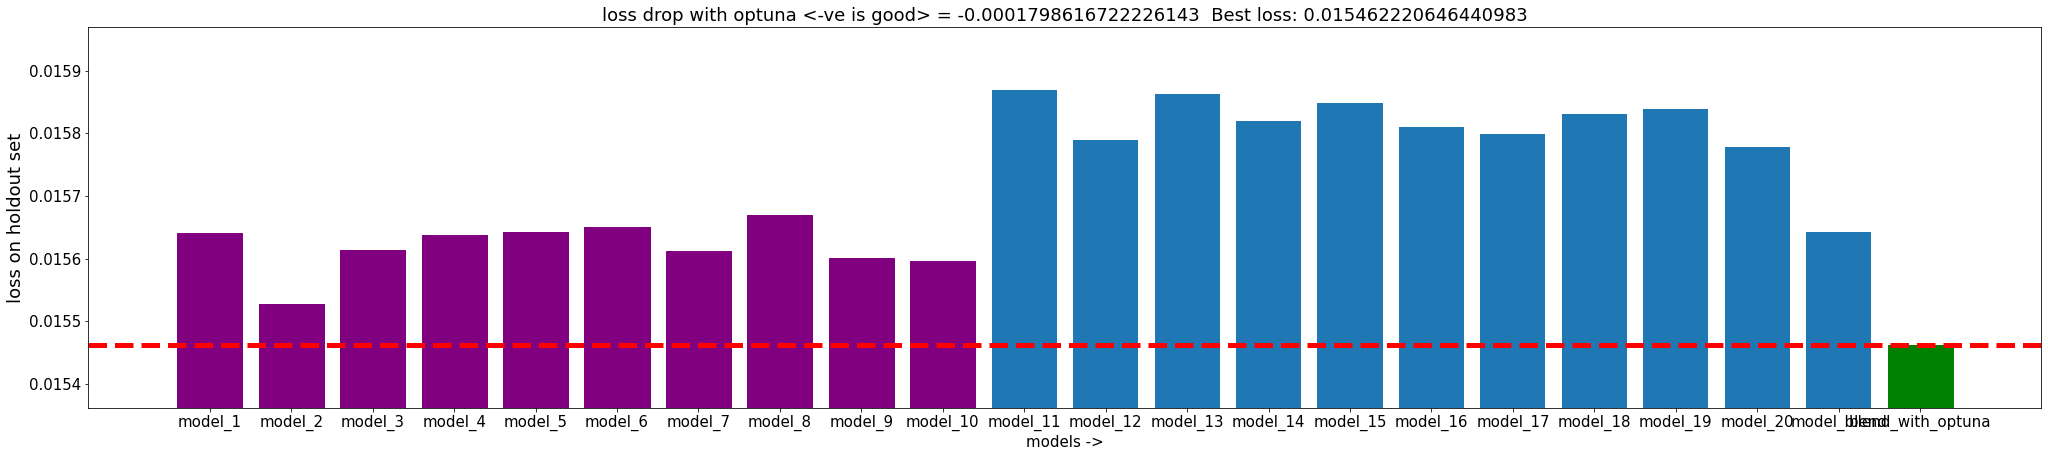

In [164]:
plt.rcParams.update({'font.size': 15})

names = test_val_losses.keys()
vals = test_val_losses.values()
bars = plt.bar(names, vals)

for i in range(10):
    bars[i].set_color("purple")


bars[-1].set_color("g")
plt.ylim(min(vals)- .0001, max(vals) + 0.0001)
plt.ylabel("loss on holdout set", fontsize = 18)
plt.xlabel("models ->", fontsize = 15)
plt.axhline(y = min(vals), linestyle = "--", c = "r", linewidth = 5)
plt.title("loss drop with optuna <-ve is good> = " + str(test_val_losses["blend_with_optuna"] - test_val_losses["model_blend"]) + "  Best loss: " + str(test_val_losses["blend_with_optuna"]))
plt.show()

## Select top 15 models

In [165]:
all_losses = np.array(list(test_val_losses.values())[:20])
top_indices = all_losses.argsort()[:15]

top_indices

array([ 1,  9,  8,  6,  2,  3,  0,  4,  5,  7, 19, 11, 16, 15, 13])

In [166]:
top_model_paths = np.array(model_filenames)[top_indices]
top_model_classes = np.array(model_classes)[top_indices]
top_model_paths

array(['./model_2.pth', './model_10.pth', './model_9.pth',
       './model_7.pth', './model_3.pth', './model_4.pth', './model_1.pth',
       './model_5.pth', './model_6.pth', './model_8.pth',
       './model_110.pth', './model_102.pth', './model_107.pth',
       './model_106.pth', './model_104.pth'], dtype='<U15')

In [167]:
len(top_model_classes), len(top_model_paths)

(15, 15)

In [ ]:
def objective_top_n(trial):
    params = {
        "w1": trial.suggest_uniform("w1", 0.1, 1.0),
        "w2": trial.suggest_uniform("w2", 0.1, 1.0),
        "w3": trial.suggest_uniform("w3", 0.1, 1.0),
        "w4": trial.suggest_uniform("w4", 0.1, 1.0),
        "w5": trial.suggest_uniform("w5", 0.1, 1.0),
        "w6": trial.suggest_uniform("w6", 0.1, 1.0),
        "w7": trial.suggest_uniform("w7", 0.1, 1.0),
        "w8": trial.suggest_uniform("w8", 0.1, 1.0),
        "w9": trial.suggest_uniform("w9", 0.1, 1.0),
        "w10": trial.suggest_uniform("w10", 0.001, 1.0),
        "w11": trial.suggest_uniform("w11", 0.1, 1.0),
        "w12": trial.suggest_uniform("w12", 0.1, 1.0),
        "w13": trial.suggest_uniform("w13", 0.1, 1.0),
        "w14": trial.suggest_uniform("w14", 0.1, 1.0),
        "w15": trial.suggest_uniform("w15", 0.1, 1.0)
    }
    
    loss_ = validate_trial(top_model_classes, top_model_paths, hold_loader,criterion, device, params) 
    return loss_


study_top = optuna.create_study(direction="minimize")


In [170]:
study_top.optimize(objective_top_n, n_trials=800)

[I 2020-10-01 10:49:47,535] Trial 0 finished with value: 0.015482454560697079 and parameters: {'w1': 0.16506985616184494, 'w2': 0.9812640863204012, 'w3': 0.167283471008296, 'w4': 0.35137659641012875, 'w5': 0.1180619056301338, 'w6': 0.43166145585640936, 'w7': 0.32295746942180076, 'w8': 0.8842252084472865, 'w9': 0.6033948786318053, 'w10': 0.5002248584598752, 'w11': 0.16047625839309465, 'w12': 0.9206332486665871, 'w13': 0.12249196027112998, 'w14': 0.6228404412723484, 'w15': 0.5718329789627654}. Best is trial 0 with value: 0.015482454560697079.
[I 2020-10-01 10:49:47,742] Trial 1 finished with value: 0.015485950279980898 and parameters: {'w1': 0.13452353925356536, 'w2': 0.21263484154420909, 'w3': 0.17347517257234035, 'w4': 0.6079874884143932, 'w5': 0.4110663853244715, 'w6': 0.4285866777825209, 'w7': 0.25924112474301975, 'w8': 0.625218713469905, 'w9': 0.8045207669718589, 'w10': 0.03482665139824245, 'w11': 0.10800652504766933, 'w12': 0.30072276912083945, 'w13': 0.9430738913797719, 'w14': 0.7

[I 2020-10-01 10:49:51,095] Trial 15 finished with value: 0.015468621626496315 and parameters: {'w1': 0.8799477055204405, 'w2': 0.3458671334637213, 'w3': 0.8616987217813108, 'w4': 0.49027395135406115, 'w5': 0.2503176237002184, 'w6': 0.249220889935687, 'w7': 0.8603009886761223, 'w8': 0.2211074504773185, 'w9': 0.9095598859389837, 'w10': 0.9899932306509224, 'w11': 0.4242282981751154, 'w12': 0.3879229921175883, 'w13': 0.641799413126869, 'w14': 0.3137005887283772, 'w15': 0.39306606767976515}. Best is trial 11 with value: 0.015463251620531082.
[I 2020-10-01 10:49:51,327] Trial 16 finished with value: 0.01546987658366561 and parameters: {'w1': 0.8709474025785882, 'w2': 0.4803125039396051, 'w3': 0.75325496242463, 'w4': 0.5083435588022189, 'w5': 0.3606658299861242, 'w6': 0.24900637814528465, 'w7': 0.9868462893797709, 'w8': 0.41655474320781805, 'w9': 0.11011910022352672, 'w10': 0.8712199557909662, 'w11': 0.555680279669972, 'w12': 0.6486310988889266, 'w13': 0.8112105962730155, 'w14': 0.4482133757

[I 2020-10-01 10:49:54,676] Trial 30 finished with value: 0.015456550754606724 and parameters: {'w1': 0.9972391541891822, 'w2': 0.9884786161884317, 'w3': 0.4260633673582123, 'w4': 0.36254019085301936, 'w5': 0.624513155444604, 'w6': 0.6239182361621685, 'w7': 0.6026871631765078, 'w8': 0.9543120714953102, 'w9': 0.5873089108945058, 'w10': 0.4636989546257731, 'w11': 0.35885943910265017, 'w12': 0.5650969811581361, 'w13': 0.3180959738191278, 'w14': 0.6037884380007712, 'w15': 0.10181409449868471}. Best is trial 29 with value: 0.015454133972525597.
[I 2020-10-01 10:49:54,913] Trial 31 finished with value: 0.015456633176654577 and parameters: {'w1': 0.9947083418022752, 'w2': 0.9895256274867796, 'w3': 0.40883781501486166, 'w4': 0.36824278479078176, 'w5': 0.5941794462411122, 'w6': 0.6107388148678512, 'w7': 0.5992745742031521, 'w8': 0.9844263333670494, 'w9': 0.5954459939700928, 'w10': 0.42890276478160916, 'w11': 0.521650421284968, 'w12': 0.5761201625246423, 'w13': 0.10819289702400892, 'w14': 0.6153

[I 2020-10-01 10:49:58,231] Trial 45 finished with value: 0.015464157797396183 and parameters: {'w1': 0.9984972454737908, 'w2': 0.9162190399047142, 'w3': 0.4755754893908165, 'w4': 0.329213229398261, 'w5': 0.622669403928661, 'w6': 0.43930192497705955, 'w7': 0.1072300864278346, 'w8': 0.7942438246113256, 'w9': 0.637138459422177, 'w10': 0.13367101406287557, 'w11': 0.5746974642113567, 'w12': 0.6025261287704491, 'w13': 0.37881881802391326, 'w14': 0.5048212006431119, 'w15': 0.30959514382586484}. Best is trial 29 with value: 0.015454133972525597.
[I 2020-10-01 10:49:58,468] Trial 46 finished with value: 0.015457437839359045 and parameters: {'w1': 0.9540310833738413, 'w2': 0.8537602470464428, 'w3': 0.39593302520012774, 'w4': 0.16569807190150132, 'w5': 0.4970394873719386, 'w6': 0.3928894795945338, 'w7': 0.6929096933343428, 'w8': 0.9082148795819472, 'w9': 0.7460775466605593, 'w10': 0.41380850216351206, 'w11': 0.3784856423249022, 'w12': 0.5062955827719273, 'w13': 0.28904840439062185, 'w14': 0.4421

[I 2020-10-01 10:50:01,770] Trial 59 finished with value: 0.015454803127795458 and parameters: {'w1': 0.7865994938381115, 'w2': 0.5049135575841203, 'w3': 0.5076709758959466, 'w4': 0.6560719126700126, 'w5': 0.7534934638449321, 'w6': 0.9115553620144848, 'w7': 0.1933524001716122, 'w8': 0.7816794610396628, 'w9': 0.24288517635008858, 'w10': 0.065560107775896, 'w11': 0.24351033544993297, 'w12': 0.1779522482235043, 'w13': 0.16022947294979017, 'w14': 0.15730682319894335, 'w15': 0.42929792046313403}. Best is trial 49 with value: 0.01545063778758049.
[I 2020-10-01 10:50:02,015] Trial 60 finished with value: 0.015456116758286953 and parameters: {'w1': 0.7244498719257949, 'w2': 0.44262906838886573, 'w3': 0.6496063292681444, 'w4': 0.7205681946642761, 'w5': 0.8945846015372403, 'w6': 0.942483922499695, 'w7': 0.3020108271112622, 'w8': 0.6716341026864245, 'w9': 0.2647730344757827, 'w10': 0.020039736136102507, 'w11': 0.24152699848873382, 'w12': 0.15786702332133867, 'w13': 0.2403010052011643, 'w14': 0.32

[I 2020-10-01 10:50:05,157] Trial 73 finished with value: 0.015451830346137285 and parameters: {'w1': 0.8379442421818594, 'w2': 0.40404621192628815, 'w3': 0.4231168342192964, 'w4': 0.6876161607874608, 'w5': 0.718818411879631, 'w6': 0.7852864335628269, 'w7': 0.3748504934303356, 'w8': 0.5660334810387857, 'w9': 0.21453547781631896, 'w10': 0.09394355163676635, 'w11': 0.17136769654394873, 'w12': 0.23024838210278098, 'w13': 0.1024222719267001, 'w14': 0.20294067487100997, 'w15': 0.2898064487401174}. Best is trial 49 with value: 0.01545063778758049.
[I 2020-10-01 10:50:05,395] Trial 74 finished with value: 0.015452087856829166 and parameters: {'w1': 0.8866920427291213, 'w2': 0.4136754327756572, 'w3': 0.4324448526845901, 'w4': 0.6093394381253101, 'w5': 0.7264820946052469, 'w6': 0.776955908722409, 'w7': 0.36688203866803604, 'w8': 0.5862587524110455, 'w9': 0.2109601824065203, 'w10': 0.19375187079192657, 'w11': 0.2835869129661624, 'w12': 0.13654172832326944, 'w13': 0.17994957480223475, 'w14': 0.19

[I 2020-10-01 10:50:08,544] Trial 87 finished with value: 0.015451894607394934 and parameters: {'w1': 0.9431618700560903, 'w2': 0.1623623136259148, 'w3': 0.5665692053121423, 'w4': 0.8176750839439677, 'w5': 0.86664667027699, 'w6': 0.9979278509834829, 'w7': 0.16766412677044928, 'w8': 0.851895626940169, 'w9': 0.16532769562611827, 'w10': 0.03937286939003776, 'w11': 0.12209949947080818, 'w12': 0.14926205388506014, 'w13': 0.2753658417600038, 'w14': 0.10521832966301398, 'w15': 0.1846841921964867}. Best is trial 85 with value: 0.015450612176209688.
[I 2020-10-01 10:50:08,783] Trial 88 finished with value: 0.015450038947165012 and parameters: {'w1': 0.9814977454901294, 'w2': 0.21971134467487358, 'w3': 0.577687019871891, 'w4': 0.8512210038999356, 'w5': 0.9570950419176198, 'w6': 0.936625468921867, 'w7': 0.2780654393438487, 'w8': 0.8723007246168103, 'w9': 0.11606967749018371, 'w10': 0.01018224318153859, 'w11': 0.13899998820655562, 'w12': 0.11745384933434641, 'w13': 0.22815452984413823, 'w14': 0.10

[I 2020-10-01 10:50:12,442] Trial 101 finished with value: 0.015450719278305769 and parameters: {'w1': 0.9700241060643071, 'w2': 0.16494335013304617, 'w3': 0.5518846669537248, 'w4': 0.8810683754153181, 'w5': 0.99725510114826, 'w6': 0.9748523206925612, 'w7': 0.26463173622106445, 'w8': 0.810232718524418, 'w9': 0.16858774303381716, 'w10': 0.0255758473675408, 'w11': 0.14958958211472778, 'w12': 0.10464081748565734, 'w13': 0.21957277191521216, 'w14': 0.10336848660810359, 'w15': 0.1444590302728909}. Best is trial 88 with value: 0.015450038947165012.
[I 2020-10-01 10:50:12,684] Trial 102 finished with value: 0.015450568869709969 and parameters: {'w1': 0.9844183071188459, 'w2': 0.18632240491674115, 'w3': 0.6328100054382588, 'w4': 0.8669345262771055, 'w5': 0.995206696889763, 'w6': 0.9838909859306858, 'w7': 0.26049707243586895, 'w8': 0.8080960135895021, 'w9': 0.17334151013712268, 'w10': 0.02725808260569744, 'w11': 0.14218677028781532, 'w12': 0.1079488942490803, 'w13': 0.22398165273333076, 'w14': 

[I 2020-10-01 10:50:15,949] Trial 115 finished with value: 0.015450683422386646 and parameters: {'w1': 0.9402980850699375, 'w2': 0.2556073166151912, 'w3': 0.7177496888006238, 'w4': 0.9778640099368873, 'w5': 0.9544942993550946, 'w6': 0.9188144607143482, 'w7': 0.24649100765443452, 'w8': 0.7675762425697853, 'w9': 0.24265601138220033, 'w10': 0.0020283236948690983, 'w11': 0.2033858537496467, 'w12': 0.19302207651270908, 'w13': 0.1883451905176256, 'w14': 0.20458009433374508, 'w15': 0.11936788040384913}. Best is trial 113 with value: 0.015449956990778446.
[I 2020-10-01 10:50:16,285] Trial 116 finished with value: 0.015450730454176664 and parameters: {'w1': 0.9038125276792411, 'w2': 0.28746913465986074, 'w3': 0.7237908170802362, 'w4': 0.9784561493261823, 'w5': 0.952558702048912, 'w6': 0.9179127766815787, 'w7': 0.23545056353711247, 'w8': 0.7206642954029238, 'w9': 0.2566616714229418, 'w10': 0.001019035904270672, 'w11': 0.20372610624484055, 'w12': 0.12642069672295647, 'w13': 0.1799327006504541, 'w

[I 2020-10-01 10:50:19,563] Trial 129 finished with value: 0.015456769149750471 and parameters: {'w1': 0.9229319785355607, 'w2': 0.3678431617164188, 'w3': 0.7359741506456219, 'w4': 0.9449290773458894, 'w5': 0.9225463892826433, 'w6': 0.871138515663118, 'w7': 0.23421598872839652, 'w8': 0.6765344080714827, 'w9': 0.3591401023530873, 'w10': 0.1773744558297745, 'w11': 0.9889500086795715, 'w12': 0.14141148372090437, 'w13': 0.3337864453851075, 'w14': 0.2409575051395358, 'w15': 0.1504605190464376}. Best is trial 126 with value: 0.015449810773134232.
[I 2020-10-01 10:50:19,810] Trial 130 finished with value: 0.015450376085937023 and parameters: {'w1': 0.9561248355127666, 'w2': 0.323523549146261, 'w3': 0.6677014797117865, 'w4': 0.999722457658529, 'w5': 0.8607855502724204, 'w6': 0.9532997371342671, 'w7': 0.19857919478960787, 'w8': 0.7452552901422751, 'w9': 0.2983662329591859, 'w10': 0.1048806021215472, 'w11': 0.18986373263153525, 'w12': 0.16851636048862773, 'w13': 0.2032690302394275, 'w14': 0.1915

[I 2020-10-01 10:50:23,314] Trial 143 finished with value: 0.015450477600097656 and parameters: {'w1': 0.9952728474763569, 'w2': 0.34452726735374606, 'w3': 0.6885564415490331, 'w4': 0.9995975729423099, 'w5': 0.8818053360566325, 'w6': 0.9101939949133508, 'w7': 0.1888689222988817, 'w8': 0.6436640128620807, 'w9': 0.3998199957959023, 'w10': 0.15927545579715435, 'w11': 0.2713002634624073, 'w12': 0.2387496367260415, 'w13': 0.20730856869691386, 'w14': 0.14965930503436647, 'w15': 0.1016286993493032}. Best is trial 142 with value: 0.015449507627636194.
[I 2020-10-01 10:50:23,553] Trial 144 finished with value: 0.015450638718903065 and parameters: {'w1': 0.9990900894043439, 'w2': 0.41814764746524985, 'w3': 0.7432931460500356, 'w4': 0.9832478343858343, 'w5': 0.8600234803360154, 'w6': 0.9388885698510643, 'w7': 0.2068330619706326, 'w8': 0.7003366825217486, 'w9': 0.3802546928727448, 'w10': 0.1765112597938885, 'w11': 0.20317959634181829, 'w12': 0.17757466200550778, 'w13': 0.25176242352817657, 'w14': 

[I 2020-10-01 10:50:26,711] Trial 157 finished with value: 0.015451139770448208 and parameters: {'w1': 0.9127702748935808, 'w2': 0.2946813628886101, 'w3': 0.7203780637586309, 'w4': 0.8677055888982805, 'w5': 0.8523699928493608, 'w6': 0.9511854871181086, 'w7': 0.28406140070343194, 'w8': 0.6734720366471806, 'w9': 0.31147613494857135, 'w10': 0.10818784112437438, 'w11': 0.19041378847237977, 'w12': 0.21207470238034262, 'w13': 0.2630622987139055, 'w14': 0.13381299025337237, 'w15': 0.1600816982940043}. Best is trial 142 with value: 0.015449507627636194.
[I 2020-10-01 10:50:26,949] Trial 158 finished with value: 0.015451687388122082 and parameters: {'w1': 0.9323729243434123, 'w2': 0.2754624655748803, 'w3': 0.74573544179519, 'w4': 0.8876159217864211, 'w5': 0.9030932913613103, 'w6': 0.1521297239767364, 'w7': 0.2534560209104829, 'w8': 0.7513896005998084, 'w9': 0.33808348430093366, 'w10': 0.08136920969238778, 'w11': 0.23802769993312056, 'w12': 0.14073900312470894, 'w13': 0.2903900398597136, 'w14': 

[I 2020-10-01 10:50:30,127] Trial 171 finished with value: 0.01544974371790886 and parameters: {'w1': 0.9745825030965742, 'w2': 0.46536294799305694, 'w3': 0.8059911173853814, 'w4': 0.8494918272851539, 'w5': 0.9111730448187392, 'w6': 0.8823776776359527, 'w7': 0.2715367485190519, 'w8': 0.758613831831099, 'w9': 0.28032594786346626, 'w10': 0.16087693775866047, 'w11': 0.1592879560738907, 'w12': 0.10133106542694884, 'w13': 0.2522895391004062, 'w14': 0.14874933318560124, 'w15': 0.16265260912248258}. Best is trial 142 with value: 0.015449507627636194.
[I 2020-10-01 10:50:30,368] Trial 172 finished with value: 0.01545033324509859 and parameters: {'w1': 0.9698591432376246, 'w2': 0.4623459412597398, 'w3': 0.8146570937074253, 'w4': 0.8541213304186354, 'w5': 0.976469047858217, 'w6': 0.8542236788340359, 'w7': 0.27837707645089854, 'w8': 0.7509059957207114, 'w9': 0.2783601140687474, 'w10': 0.1627882889866003, 'w11': 0.10114533456098948, 'w12': 0.12987010058781634, 'w13': 0.3038210107397394, 'w14': 0.1

[I 2020-10-01 10:50:33,618] Trial 185 finished with value: 0.015449895523488522 and parameters: {'w1': 0.9988084392223688, 'w2': 0.48154275514304345, 'w3': 0.8777334723011845, 'w4': 0.7943554233550649, 'w5': 0.8983050095500048, 'w6': 0.7677957103828019, 'w7': 0.32199995773214735, 'w8': 0.7995741688959475, 'w9': 0.2864894957228017, 'w10': 0.2734313682339866, 'w11': 0.16498907396802098, 'w12': 0.13161837690062178, 'w13': 0.3589789122501578, 'w14': 0.13690117732132692, 'w15': 0.13245492425980823}. Best is trial 142 with value: 0.015449507627636194.
[I 2020-10-01 10:50:33,897] Trial 186 finished with value: 0.01545023638755083 and parameters: {'w1': 0.9988099359564862, 'w2': 0.4822142111290278, 'w3': 0.878629669006665, 'w4': 0.7986130674334433, 'w5': 0.89377280629541, 'w6': 0.7538370274831429, 'w7': 0.308488935472411, 'w8': 0.7963820687005737, 'w9': 0.29441214050726894, 'w10': 0.28357007963099246, 'w11': 0.16680638857689523, 'w12': 0.13834172594266647, 'w13': 0.35792994928675015, 'w14': 0.

[I 2020-10-01 10:50:37,115] Trial 199 finished with value: 0.01545002218335867 and parameters: {'w1': 0.9970451487922433, 'w2': 0.47833661306637454, 'w3': 0.9018294361192104, 'w4': 0.7528802218561541, 'w5': 0.8785406256205804, 'w6': 0.7730321150657782, 'w7': 0.341386271265859, 'w8': 0.8213193312322844, 'w9': 0.30368582373992253, 'w10': 0.26413059002745815, 'w11': 0.18274709177876994, 'w12': 0.15760561326194805, 'w13': 0.41661548623415773, 'w14': 0.10217396679880243, 'w15': 0.12994120306218654}. Best is trial 142 with value: 0.015449507627636194.
[I 2020-10-01 10:50:37,365] Trial 200 finished with value: 0.015449583996087313 and parameters: {'w1': 0.9999127693465806, 'w2': 0.5081899659547703, 'w3': 0.9218766909875991, 'w4': 0.7881813587852511, 'w5': 0.8268970550689935, 'w6': 0.7602324935640287, 'w7': 0.4196587910095684, 'w8': 0.8482577052206063, 'w9': 0.2527873192383494, 'w10': 0.2959044606117388, 'w11': 0.163748358989013, 'w12': 0.13297422971721098, 'w13': 0.3664081105750017, 'w14': 0.

[I 2020-10-01 10:50:40,709] Trial 213 finished with value: 0.015449626371264458 and parameters: {'w1': 0.9700181161013133, 'w2': 0.5617805991741369, 'w3': 0.8514145546496993, 'w4': 0.7430554676591064, 'w5': 0.7791132389611035, 'w6': 0.6424535548004541, 'w7': 0.41731311192417264, 'w8': 0.860768217250093, 'w9': 0.2635452447884031, 'w10': 0.32953286547673244, 'w11': 0.13753107825047328, 'w12': 0.1897935149946544, 'w13': 0.3289470979810504, 'w14': 0.14566223519841667, 'w15': 0.11355963560749155}. Best is trial 203 with value: 0.015449339523911476.
[I 2020-10-01 10:50:40,957] Trial 214 finished with value: 0.015449810307472944 and parameters: {'w1': 0.9670079268095636, 'w2': 0.5549169055238201, 'w3': 0.8536058437441724, 'w4': 0.7857888881874774, 'w5': 0.7692980131391928, 'w6': 0.6285909679513875, 'w7': 0.42529065642266367, 'w8': 0.8544629556110408, 'w9': 0.26771368119704836, 'w10': 0.33223544638041397, 'w11': 0.13838791653194338, 'w12': 0.22230402978822594, 'w13': 0.33056517563480947, 'w14'

[I 2020-10-01 10:50:44,270] Trial 227 finished with value: 0.015450045466423035 and parameters: {'w1': 0.9512640021371506, 'w2': 0.5778902379327598, 'w3': 0.8905635582475078, 'w4': 0.7048869644165157, 'w5': 0.7672603269864571, 'w6': 0.6962766852429387, 'w7': 0.48802225059733245, 'w8': 0.9121048153190991, 'w9': 0.23457791340753173, 'w10': 0.4225910960108802, 'w11': 0.11724055244793355, 'w12': 0.23595814054234343, 'w13': 0.30658846174324866, 'w14': 0.10018457658148973, 'w15': 0.1011943481106369}. Best is trial 203 with value: 0.015449339523911476.
[I 2020-10-01 10:50:44,598] Trial 228 finished with value: 0.01545011904090643 and parameters: {'w1': 0.9393736761273255, 'w2': 0.6411868712297375, 'w3': 0.8672761990681714, 'w4': 0.7622456357186609, 'w5': 0.7942926319652628, 'w6': 0.5671876213114928, 'w7': 0.5376567376955363, 'w8': 0.8811616081372668, 'w9': 0.2757115097705531, 'w10': 0.3647799518776218, 'w11': 0.13102264470786062, 'w12': 0.2550258498294465, 'w13': 0.3685778561029738, 'w14': 0.

[I 2020-10-01 10:50:47,925] Trial 241 finished with value: 0.015449847560375929 and parameters: {'w1': 0.9436250994068317, 'w2': 0.6020177378654787, 'w3': 0.8172202636006164, 'w4': 0.8007938015501591, 'w5': 0.7762707584718398, 'w6': 0.5984658411590075, 'w7': 0.482011394598102, 'w8': 0.8702590554878614, 'w9': 0.29602719102938674, 'w10': 0.3229326399390701, 'w11': 0.10157408072265882, 'w12': 0.24822462136314424, 'w13': 0.325608904662626, 'w14': 0.16011214256315265, 'w15': 0.11480166666093775}. Best is trial 234 with value: 0.015449253842234612.
[I 2020-10-01 10:50:48,191] Trial 242 finished with value: 0.015449906699359417 and parameters: {'w1': 0.9487855454786397, 'w2': 0.5393017156058879, 'w3': 0.870159895161266, 'w4': 0.7806424809020902, 'w5': 0.7671578589860693, 'w6': 0.687495919079262, 'w7': 0.5402043011346662, 'w8': 0.9030165072235905, 'w9': 0.32293977767555904, 'w10': 0.35142643345580427, 'w11': 0.1183604331675831, 'w12': 0.23412816753779686, 'w13': 0.3298073510626247, 'w14': 0.13

[I 2020-10-01 10:50:51,605] Trial 255 finished with value: 0.015449999365955591 and parameters: {'w1': 0.9536687303775967, 'w2': 0.528656619163742, 'w3': 0.8660648299791259, 'w4': 0.823230156704363, 'w5': 0.7472001843677762, 'w6': 0.6387125255626299, 'w7': 0.520792537816046, 'w8': 0.9057711849425013, 'w9': 0.28046642351468426, 'w10': 0.3035586945583932, 'w11': 0.12402820652428706, 'w12': 0.25546276322440814, 'w13': 0.31773060407804565, 'w14': 0.19505507681224288, 'w15': 0.10115530219312185}. Best is trial 234 with value: 0.015449253842234612.
[I 2020-10-01 10:50:51,857] Trial 256 finished with value: 0.015454301610589027 and parameters: {'w1': 0.4777239373098139, 'w2': 0.565706051483761, 'w3': 0.8314371557683047, 'w4': 0.7174220515925865, 'w5': 0.7283100554342022, 'w6': 0.669480903104469, 'w7': 0.5045792937200656, 'w8': 0.8824683999638532, 'w9': 0.31063225285241214, 'w10': 0.2685306282481353, 'w11': 0.10020678809401215, 'w12': 0.2227538712325815, 'w13': 0.3570793487545414, 'w14': 0.187

[I 2020-10-01 10:50:55,155] Trial 269 finished with value: 0.015449562575668097 and parameters: {'w1': 0.9020487023736465, 'w2': 0.6025991740681159, 'w3': 0.9004597285317638, 'w4': 0.8332882017425359, 'w5': 0.7392202047682966, 'w6': 0.6388075391508408, 'w7': 0.5204510044027413, 'w8': 0.8482680791494436, 'w9': 0.3350255681961615, 'w10': 0.27159655175137676, 'w11': 0.1514994799996455, 'w12': 0.1808838358455841, 'w13': 0.30872285344981365, 'w14': 0.11230544192323216, 'w15': 0.11459981712099028}. Best is trial 266 with value: 0.015448845457285643.
[I 2020-10-01 10:50:55,533] Trial 270 finished with value: 0.015449580736458302 and parameters: {'w1': 0.8886694872976637, 'w2': 0.6038001117702736, 'w3': 0.9620600455653923, 'w4': 0.8332634258119794, 'w5': 0.7394725803376242, 'w6': 0.5773542874705474, 'w7': 0.5525067048912492, 'w8': 0.853135296870437, 'w9': 0.36861587885609576, 'w10': 0.27362959610677173, 'w11': 0.15208109523494426, 'w12': 0.18340023554175283, 'w13': 0.29984550043872293, 'w14': 

[I 2020-10-01 10:50:58,929] Trial 283 finished with value: 0.015450803562998772 and parameters: {'w1': 0.8570616238784008, 'w2': 0.6518875304477314, 'w3': 0.9583478996085629, 'w4': 0.8058138087949884, 'w5': 0.6892830656930446, 'w6': 0.5207248991177815, 'w7': 0.6321330662310871, 'w8': 0.826695929867253, 'w9': 0.45176204995387303, 'w10': 0.24842318142633818, 'w11': 0.19367384551563807, 'w12': 0.16762855647028593, 'w13': 0.5458096682789018, 'w14': 0.11460944007735539, 'w15': 0.10013409748871918}. Best is trial 266 with value: 0.015448845457285643.
[I 2020-10-01 10:50:59,185] Trial 284 finished with value: 0.015449095983058214 and parameters: {'w1': 0.8946761449226381, 'w2': 0.6306415766101733, 'w3': 0.9119682825817534, 'w4': 0.8398140912991928, 'w5': 0.6405805980138556, 'w6': 0.49479830101998, 'w7': 0.587578833206969, 'w8': 0.8110778244263542, 'w9': 0.3885558333740315, 'w10': 0.2247719494623263, 'w11': 0.16956533281394665, 'w12': 0.1970114697443904, 'w13': 0.2803101131804467, 'w14': 0.100

[I 2020-10-01 10:51:02,490] Trial 297 finished with value: 0.01544967433437705 and parameters: {'w1': 0.8874732019892633, 'w2': 0.6881732402014471, 'w3': 0.9502203591308136, 'w4': 0.8743434191773568, 'w5': 0.6652275706298203, 'w6': 0.5054636417310494, 'w7': 0.5880355845080291, 'w8': 0.8204425080241101, 'w9': 0.43748521309956895, 'w10': 0.22560548657965665, 'w11': 0.20767133016022044, 'w12': 0.16059906974592442, 'w13': 0.2569196455259567, 'w14': 0.12201741631621223, 'w15': 0.14747727064612817}. Best is trial 266 with value: 0.015448845457285643.
[I 2020-10-01 10:51:02,765] Trial 298 finished with value: 0.015449902508407831 and parameters: {'w1': 0.8341477490577315, 'w2': 0.7219566615827675, 'w3': 0.914711509617953, 'w4': 0.8397088697801229, 'w5': 0.653725269488282, 'w6': 0.4219883495476228, 'w7': 0.6563959435407257, 'w8': 0.7913896659593566, 'w9': 0.46587913086460275, 'w10': 0.19337073051913245, 'w11': 0.19082500377163622, 'w12': 0.1659467328241263, 'w13': 0.26211358879293983, 'w14': 0

[I 2020-10-01 10:51:06,225] Trial 311 finished with value: 0.015449990518391132 and parameters: {'w1': 0.8615526846420117, 'w2': 0.6207422826831207, 'w3': 0.9666165744546037, 'w4': 0.8384943890225571, 'w5': 0.7053351176280874, 'w6': 0.4770817275666266, 'w7': 0.5970411199905031, 'w8': 0.843873106653715, 'w9': 0.3907632143568189, 'w10': 0.2537057221350923, 'w11': 0.18891094807634584, 'w12': 0.19309653188992107, 'w13': 0.2901578773154006, 'w14': 0.10302334590038924, 'w15': 0.11762551161724444}. Best is trial 266 with value: 0.015448845457285643.
[I 2020-10-01 10:51:06,577] Trial 312 finished with value: 0.01544930087402463 and parameters: {'w1': 0.8861114578586538, 'w2': 0.6758090014610371, 'w3': 0.9014382199540066, 'w4': 0.8447300036905391, 'w5': 0.6769945247473352, 'w6': 0.5581696253298231, 'w7': 0.5706526465076633, 'w8': 0.8607368984944046, 'w9': 0.35478759922402914, 'w10': 0.20738507703107392, 'w11': 0.16428383387393947, 'w12': 0.214591907676632, 'w13': 0.3113823443100229, 'w14': 0.13

[I 2020-10-01 10:51:09,982] Trial 325 finished with value: 0.015455565880984068 and parameters: {'w1': 0.9246366865321999, 'w2': 0.6136569096803766, 'w3': 0.9940732845302834, 'w4': 0.8879560630269323, 'w5': 0.6814420317455683, 'w6': 0.4507184191239463, 'w7': 0.7532392212545883, 'w8': 0.8713431465602413, 'w9': 0.35442740318587773, 'w10': 0.9359586644392472, 'w11': 0.1578683506738402, 'w12': 0.6900412740656505, 'w13': 0.25551755835970513, 'w14': 0.10228096585648283, 'w15': 0.10690828082338764}. Best is trial 266 with value: 0.015448845457285643.
[I 2020-10-01 10:51:10,242] Trial 326 finished with value: 0.015449353959411383 and parameters: {'w1': 0.9166291537760712, 'w2': 0.5804977864068119, 'w3': 0.9822427076508095, 'w4': 0.8866583798527627, 'w5': 0.715441650194573, 'w6': 0.4231044677058101, 'w7': 0.5543414146752664, 'w8': 0.8595155366831483, 'w9': 0.3690099220220807, 'w10': 0.17682430819204153, 'w11': 0.1330684245657797, 'w12': 0.2197760641861027, 'w13': 0.29381996036935515, 'w14': 0.1

[I 2020-10-01 10:51:13,948] Trial 339 finished with value: 0.01544968644157052 and parameters: {'w1': 0.8851480584855108, 'w2': 0.5942374341950544, 'w3': 0.9961399505041707, 'w4': 0.912139013229616, 'w5': 0.7092310567739087, 'w6': 0.3965338984925472, 'w7': 0.821207453370661, 'w8': 0.8346889517493733, 'w9': 0.3870958146473571, 'w10': 0.1619241374788158, 'w11': 0.15088162850795173, 'w12': 0.1971764322646473, 'w13': 0.2535387050543975, 'w14': 0.11499077647081907, 'w15': 0.12419197561488231}. Best is trial 266 with value: 0.015448845457285643.
[I 2020-10-01 10:51:14,214] Trial 340 finished with value: 0.015449956990778446 and parameters: {'w1': 0.9338340927602204, 'w2': 0.6440174870100581, 'w3': 0.963034255035017, 'w4': 0.8972165382740231, 'w5': 0.6781896906858599, 'w6': 0.43525216599545885, 'w7': 0.5861856882434605, 'w8': 0.8947879571768272, 'w9': 0.35066788323156356, 'w10': 0.20542714544497276, 'w11': 0.33544873696227623, 'w12': 0.23938751695272042, 'w13': 0.28663926437184883, 'w14': 0.1

[I 2020-10-01 10:51:18,167] Trial 353 finished with value: 0.015449574682861567 and parameters: {'w1': 0.8928787463201325, 'w2': 0.6326376745263882, 'w3': 0.9007483279547828, 'w4': 0.8551489257327356, 'w5': 0.5224914468109481, 'w6': 0.5882746459842243, 'w7': 0.6055975077294905, 'w8': 0.8259887006303399, 'w9': 0.34322454208454406, 'w10': 0.22466016478278666, 'w11': 0.11685480810555668, 'w12': 0.29046273155806124, 'w13': 0.24464632539314504, 'w14': 0.11496252669529256, 'w15': 0.1328508220579929}. Best is trial 266 with value: 0.015448845457285643.
[I 2020-10-01 10:51:18,462] Trial 354 finished with value: 0.015451152808964252 and parameters: {'w1': 0.8575760687910025, 'w2': 0.6027589842534274, 'w3': 0.9229879425264693, 'w4': 0.8762196759183546, 'w5': 0.6332859773825541, 'w6': 0.5580891552522428, 'w7': 0.6679359538219737, 'w8': 0.8420589585359973, 'w9': 0.3250041901134309, 'w10': 0.2191465920316597, 'w11': 0.44755895146204494, 'w12': 0.32143412802280935, 'w13': 0.2578045784811427, 'w14': 

[I 2020-10-01 10:51:22,038] Trial 367 finished with value: 0.01545183826237917 and parameters: {'w1': 0.9071373097964256, 'w2': 0.6138445045523894, 'w3': 0.9363446288658026, 'w4': 0.9236162765956417, 'w5': 0.6996364090533223, 'w6': 0.6000542703705569, 'w7': 0.6120645707218444, 'w8': 0.11584214232151013, 'w9': 0.8791236162371285, 'w10': 0.2238572453031461, 'w11': 0.10172116979283335, 'w12': 0.2658073355813098, 'w13': 0.2538971897641756, 'w14': 0.10073178315808623, 'w15': 0.11844164325967316}. Best is trial 266 with value: 0.015448845457285643.
[I 2020-10-01 10:51:22,307] Trial 368 finished with value: 0.015456721186637878 and parameters: {'w1': 0.25672771966419083, 'w2': 0.5974775524163414, 'w3': 0.9998774352990716, 'w4': 0.9004902579050494, 'w5': 0.5747222973421566, 'w6': 0.5927264776904098, 'w7': 0.594678119352517, 'w8': 0.8111325982081513, 'w9': 0.32046358510859346, 'w10': 0.21030640964682562, 'w11': 0.14151697633654325, 'w12': 0.26638822913073934, 'w13': 0.27768812793367, 'w14': 0.1

[I 2020-10-01 10:51:25,949] Trial 381 finished with value: 0.015449951402842999 and parameters: {'w1': 0.9075061651950714, 'w2': 0.5874318526258837, 'w3': 0.9202959249216517, 'w4': 0.15188307817886904, 'w5': 0.7020430775393491, 'w6': 0.5708733244763023, 'w7': 0.5828395473588927, 'w8': 0.8208791011140538, 'w9': 0.3561330496820574, 'w10': 0.18157257438133423, 'w11': 0.17574409301878813, 'w12': 0.23673065219079314, 'w13': 0.28367851254624366, 'w14': 0.12043807055955244, 'w15': 0.11642193434378761}. Best is trial 266 with value: 0.015448845457285643.
[I 2020-10-01 10:51:26,208] Trial 382 finished with value: 0.015449806582182646 and parameters: {'w1': 0.8694927540781624, 'w2': 0.6174910345215401, 'w3': 0.9449761490649929, 'w4': 0.8450272143687125, 'w5': 0.7386606007461818, 'w6': 0.47754087690255337, 'w7': 0.6173598127596724, 'w8': 0.7850986124224253, 'w9': 0.42004190131690244, 'w10': 0.247138843847339, 'w11': 0.147666684476915, 'w12': 0.1908383115134399, 'w13': 0.24812137592330735, 'w14': 

[I 2020-10-01 10:51:29,855] Trial 395 finished with value: 0.015449320897459984 and parameters: {'w1': 0.9372003312004206, 'w2': 0.5658715830954426, 'w3': 0.9612702480318741, 'w4': 0.8849738154046087, 'w5': 0.7172010277583858, 'w6': 0.48145313380473886, 'w7': 0.6257857331855512, 'w8': 0.9138936482738682, 'w9': 0.34650674296141415, 'w10': 0.16075873273481023, 'w11': 0.18966186781287359, 'w12': 0.2475382306722966, 'w13': 0.2304283132495881, 'w14': 0.11743399165792061, 'w15': 0.12883953181926983}. Best is trial 266 with value: 0.015448845457285643.
[I 2020-10-01 10:51:30,125] Trial 396 finished with value: 0.015449546743184328 and parameters: {'w1': 0.945532652537392, 'w2': 0.5706035841644753, 'w3': 0.9645746610450855, 'w4': 0.9064971352353773, 'w5': 0.7318743490975027, 'w6': 0.47478652272426347, 'w7': 0.6177185281912658, 'w8': 0.9672128303858918, 'w9': 0.3363686916496774, 'w10': 0.14515783966133014, 'w11': 0.22136450933543012, 'w12': 0.24823749054375388, 'w13': 0.21656180525355578, 'w14'

[I 2020-10-01 10:51:33,564] Trial 409 finished with value: 0.015448997728526592 and parameters: {'w1': 0.9476480874293287, 'w2': 0.5386078297714314, 'w3': 0.9302685770004426, 'w4': 0.8963613727254234, 'w5': 0.7375292137335696, 'w6': 0.49634405552401617, 'w7': 0.5504783500741897, 'w8': 0.9619861509866315, 'w9': 0.31628999176184025, 'w10': 0.16277094176683415, 'w11': 0.22027642430913633, 'w12': 0.19329789234443767, 'w13': 0.15445283833516785, 'w14': 0.10007478059064599, 'w15': 0.13365517993591422}. Best is trial 266 with value: 0.015448845457285643.
[I 2020-10-01 10:51:33,828] Trial 410 finished with value: 0.015449108555912971 and parameters: {'w1': 0.9296772610460833, 'w2': 0.5313865936493596, 'w3': 0.9402623604723694, 'w4': 0.8835602933925888, 'w5': 0.7430402412627567, 'w6': 0.5088094112078594, 'w7': 0.5049471243000928, 'w8': 0.9453575283358203, 'w9': 0.31390812243995203, 'w10': 0.16266436165662262, 'w11': 0.22626656377285137, 'w12': 0.19024121264172617, 'w13': 0.14913020812262007, 'w

[I 2020-10-01 10:51:37,319] Trial 423 finished with value: 0.015449433587491512 and parameters: {'w1': 0.953875960236617, 'w2': 0.5422810083378892, 'w3': 0.8788497375409222, 'w4': 0.8724073019865108, 'w5': 0.7600554800087664, 'w6': 0.5058858021262528, 'w7': 0.4796758451577163, 'w8': 0.9795794732958775, 'w9': 0.3065012617679379, 'w10': 0.09927691703507097, 'w11': 0.24729235045505704, 'w12': 0.17780172422859258, 'w13': 0.1331999795951342, 'w14': 0.11479410016024863, 'w15': 0.21288649934229018}. Best is trial 416 with value: 0.01544849295169115.
[I 2020-10-01 10:51:37,586] Trial 424 finished with value: 0.01544921612367034 and parameters: {'w1': 0.9439557467319702, 'w2': 0.5599832875727746, 'w3': 0.8726149613900246, 'w4': 0.9045956134667412, 'w5': 0.7557574406040569, 'w6': 0.5340126203285321, 'w7': 0.4964786633991986, 'w8': 0.953874879984294, 'w9': 0.3215997191174836, 'w10': 0.11064201742481744, 'w11': 0.2301153949512998, 'w12': 0.2028449558391082, 'w13': 0.10351130145354959, 'w14': 0.103

[I 2020-10-01 10:51:41,291] Trial 437 finished with value: 0.01544914674013853 and parameters: {'w1': 0.9772941178731993, 'w2': 0.513118286934527, 'w3': 0.9081314833855708, 'w4': 0.9306730332267105, 'w5': 0.733725411262831, 'w6': 0.4795642519630801, 'w7': 0.443051243281676, 'w8': 0.9991089322472109, 'w9': 0.2979017449909628, 'w10': 0.04998155781933032, 'w11': 0.24790958119837714, 'w12': 0.14706105882838844, 'w13': 0.10226647003959614, 'w14': 0.12210596978779276, 'w15': 0.2088787299974277}. Best is trial 416 with value: 0.01544849295169115.
[I 2020-10-01 10:51:41,566] Trial 438 finished with value: 0.015449838247150183 and parameters: {'w1': 0.9737980601942265, 'w2': 0.515683444270018, 'w3': 0.9170365206373403, 'w4': 0.9495314766441096, 'w5': 0.737045579741396, 'w6': 0.4713021493374287, 'w7': 0.4718969334529381, 'w8': 0.9941368261472291, 'w9': 0.3009802349227885, 'w10': 0.053588973920750946, 'w11': 0.2483189117385859, 'w12': 0.15156208346954195, 'w13': 0.1305565560743967, 'w14': 0.12419

[I 2020-10-01 10:51:45,102] Trial 451 finished with value: 0.015448862686753273 and parameters: {'w1': 0.946228773746793, 'w2': 0.5874160895296607, 'w3': 0.9278469129902296, 'w4': 0.9684778755922557, 'w5': 0.7576325780879434, 'w6': 0.44156113769646743, 'w7': 0.4616784698990986, 'w8': 0.9522800967120693, 'w9': 0.3202801222214919, 'w10': 0.07913873275811906, 'w11': 0.21555172239729947, 'w12': 0.12413877481940015, 'w13': 0.10270864212504019, 'w14': 0.10006939278093463, 'w15': 0.18036764827695578}. Best is trial 416 with value: 0.01544849295169115.
[I 2020-10-01 10:51:45,373] Trial 452 finished with value: 0.015449060127139091 and parameters: {'w1': 0.9511557996221226, 'w2': 0.5846938053816274, 'w3': 0.9361122418637284, 'w4': 0.9712465477030754, 'w5': 0.7870850541876891, 'w6': 0.47787827772135655, 'w7': 0.43621286263257464, 'w8': 0.9508547259615058, 'w9': 0.31564711460622996, 'w10': 0.06257534489755998, 'w11': 0.21159378536982942, 'w12': 0.12107522500759746, 'w13': 0.10090840999488684, 'w1

[I 2020-10-01 10:51:48,953] Trial 465 finished with value: 0.015448767691850662 and parameters: {'w1': 0.9591311917633116, 'w2': 0.568769514413375, 'w3': 0.9284408525019349, 'w4': 0.966637232948736, 'w5': 0.8319567181906237, 'w6': 0.4269076749857068, 'w7': 0.4811745145653022, 'w8': 0.917242450282081, 'w9': 0.28350364350168067, 'w10': 0.015140377093311015, 'w11': 0.21456490872746597, 'w12': 0.11765311726339642, 'w13': 0.1435515930914229, 'w14': 0.16464271934174188, 'w15': 0.16797614434556485}. Best is trial 416 with value: 0.01544849295169115.
[I 2020-10-01 10:51:49,221] Trial 466 finished with value: 0.01544859353452921 and parameters: {'w1': 0.9848764717240039, 'w2': 0.5659761575991833, 'w3': 0.9489681443740401, 'w4': 0.9654284881342096, 'w5': 0.8130620798061795, 'w6': 0.4288179483511207, 'w7': 0.4853635443060173, 'w8': 0.9161977461624802, 'w9': 0.28641481225938414, 'w10': 0.019001417334366968, 'w11': 0.210035234096707, 'w12': 0.11454672670946053, 'w13': 0.1393476893839379, 'w14': 0.1

[I 2020-10-01 10:51:52,997] Trial 479 finished with value: 0.01544845337048173 and parameters: {'w1': 0.9919815884609803, 'w2': 0.5665346244807454, 'w3': 0.31567819708663114, 'w4': 0.9984085921615742, 'w5': 0.8275534426862019, 'w6': 0.4059068448994347, 'w7': 0.48434871014024605, 'w8': 0.917350742937359, 'w9': 0.23331381461528827, 'w10': 0.001560557615046674, 'w11': 0.21056740426633336, 'w12': 0.10068017461544886, 'w13': 0.13887189954262516, 'w14': 0.22817477670278868, 'w15': 0.16521917023119306}. Best is trial 468 with value: 0.015448248479515314.
[I 2020-10-01 10:51:53,270] Trial 480 finished with value: 0.01544841704890132 and parameters: {'w1': 0.9998534261998375, 'w2': 0.5741802290164696, 'w3': 0.3099912678734299, 'w4': 0.9918069670368594, 'w5': 0.8302709621780167, 'w6': 0.40895776895076, 'w7': 0.48024007016115133, 'w8': 0.9112643905597839, 'w9': 0.24716311419503903, 'w10': 0.0016028991952198, 'w11': 0.20994187306808532, 'w12': 0.10313533913593678, 'w13': 0.1395822448868826, 'w14':

[I 2020-10-01 10:51:57,039] Trial 493 finished with value: 0.015448810532689095 and parameters: {'w1': 0.9980745006826618, 'w2': 0.5569810289532192, 'w3': 0.3498365420356077, 'w4': 0.9952777936772973, 'w5': 0.8230909446846636, 'w6': 0.37940640346719695, 'w7': 0.4972622340925161, 'w8': 0.9026132956848354, 'w9': 0.19188458792400503, 'w10': 0.022868136739261514, 'w11': 0.19957662353878725, 'w12': 0.10591492785622901, 'w13': 0.13133282735921048, 'w14': 0.2928248098947477, 'w15': 0.16702276774977656}. Best is trial 468 with value: 0.015448248479515314.
[I 2020-10-01 10:51:57,318] Trial 494 finished with value: 0.015448724385350943 and parameters: {'w1': 0.9980272813065977, 'w2': 0.5558161471925214, 'w3': 0.251405598454535, 'w4': 0.9992553384717744, 'w5': 0.839129275199053, 'w6': 0.35596031112326476, 'w7': 0.49090980990645383, 'w8': 0.9045418102646116, 'w9': 0.19329333862364056, 'w10': 0.0035013257380546083, 'w11': 0.223692092236303, 'w12': 0.10001621001105337, 'w13': 0.16386354545828485, 'w

[I 2020-10-01 10:52:00,882] Trial 507 finished with value: 0.015448534861207008 and parameters: {'w1': 0.999765810924599, 'w2': 0.5589653405489999, 'w3': 0.279767200557122, 'w4': 0.9986917531315068, 'w5': 0.841549257620097, 'w6': 0.31681490429800296, 'w7': 0.45959527918738696, 'w8': 0.8941186833858243, 'w9': 0.18459186315917256, 'w10': 0.0017218819882731423, 'w11': 0.22219744546914424, 'w12': 0.11547029407819442, 'w13': 0.12841174809898712, 'w14': 0.20476636738000664, 'w15': 0.159408872743337}. Best is trial 468 with value: 0.015448248479515314.
[I 2020-10-01 10:52:01,153] Trial 508 finished with value: 0.015449366066604853 and parameters: {'w1': 0.9994276421268521, 'w2': 0.5351255455566054, 'w3': 0.277106049307425, 'w4': 0.9839276839170052, 'w5': 0.8388721981117495, 'w6': 0.32724251367371515, 'w7': 0.4558570607602168, 'w8': 0.9219699072598616, 'w9': 0.17723865442771006, 'w10': 0.023799717896899865, 'w11': 0.2338845050030837, 'w12': 0.1007073510251604, 'w13': 0.12893292481219162, 'w14'

[I 2020-10-01 10:52:04,945] Trial 521 finished with value: 0.015448729507625103 and parameters: {'w1': 0.9975486708429434, 'w2': 0.5946372997996799, 'w3': 0.29993274602804104, 'w4': 0.9771194055664311, 'w5': 0.846292649057012, 'w6': 0.4056520992296101, 'w7': 0.507547794174848, 'w8': 0.8885225960894921, 'w9': 0.12892404785940742, 'w10': 0.040278467984863724, 'w11': 0.21992428196775662, 'w12': 0.125900120424679, 'w13': 0.12045248275541842, 'w14': 0.28124410613123263, 'w15': 0.15357786429839815}. Best is trial 468 with value: 0.015448248479515314.
[I 2020-10-01 10:52:05,215] Trial 522 finished with value: 0.015448509715497494 and parameters: {'w1': 0.9998150750525177, 'w2': 0.587120302007741, 'w3': 0.2620439395333841, 'w4': 0.9994719090947892, 'w5': 0.8056439309756545, 'w6': 0.3820197578652992, 'w7': 0.5104993007836836, 'w8': 0.8878214773926474, 'w9': 0.1447686475511243, 'w10': 0.0024529753231295995, 'w11': 0.25806218678884935, 'w12': 0.12359812888874738, 'w13': 0.12207465629637046, 'w14'

[I 2020-10-01 10:52:08,834] Trial 535 finished with value: 0.015454554930329323 and parameters: {'w1': 0.5201854616351529, 'w2': 0.5603764974746139, 'w3': 0.26979841327522464, 'w4': 0.9783868914157061, 'w5': 0.8562929512245886, 'w6': 0.3163365345308175, 'w7': 0.49732739379868757, 'w8': 0.9097310368376659, 'w9': 0.14767016181376552, 'w10': 0.041072534025292436, 'w11': 0.26202063607818854, 'w12': 0.11807905902020321, 'w13': 0.15378925963075454, 'w14': 0.23960397540848943, 'w15': 0.15129898264960076}. Best is trial 468 with value: 0.015448248479515314.
[I 2020-10-01 10:52:09,118] Trial 536 finished with value: 0.015448854770511389 and parameters: {'w1': 0.9996322034131628, 'w2': 0.5929749214138089, 'w3': 0.3543637858906241, 'w4': 0.999008923077333, 'w5': 0.8162925644253807, 'w6': 0.40469816403590175, 'w7': 0.4725920095767972, 'w8': 0.9338539879894914, 'w9': 0.25127473137873535, 'w10': 0.0025760427674178265, 'w11': 0.23430450166642028, 'w12': 0.13325533447543964, 'w13': 0.15557913513717808

[I 2020-10-01 10:52:13,244] Trial 549 finished with value: 0.015448283404111862 and parameters: {'w1': 0.9762595952971873, 'w2': 0.60015910397622, 'w3': 0.3064972273642121, 'w4': 0.9509927254892937, 'w5': 0.8522540101574543, 'w6': 0.39474200267163334, 'w7': 0.4298606357784025, 'w8': 0.8808476659785537, 'w9': 0.25338246623804905, 'w10': 0.0023271458902978386, 'w11': 0.2827892752163104, 'w12': 0.13382715139203322, 'w13': 0.1003687914524709, 'w14': 0.18913727963109186, 'w15': 0.14914385732559884}. Best is trial 548 with value: 0.015448200516402721.
[I 2020-10-01 10:52:13,530] Trial 550 finished with value: 0.015448410529643297 and parameters: {'w1': 0.9744290270125722, 'w2': 0.5957209788466405, 'w3': 0.3089643394829079, 'w4': 0.9520383646510336, 'w5': 0.8817427036487073, 'w6': 0.398153330050496, 'w7': 0.4034454202986054, 'w8': 0.8819374472712163, 'w9': 0.24926120130237586, 'w10': 0.0019466054546669921, 'w11': 0.2666682903239293, 'w12': 0.13255632755735608, 'w13': 0.11381268376985093, 'w14

[I 2020-10-01 10:52:17,459] Trial 563 finished with value: 0.01545210788026452 and parameters: {'w1': 0.9723990332262077, 'w2': 0.5832205624064332, 'w3': 0.28557184319126055, 'w4': 0.9800718697095968, 'w5': 0.8046267758081646, 'w6': 0.39755630780338075, 'w7': 0.437601234345567, 'w8': 0.9009590126687693, 'w9': 0.22338589628896027, 'w10': 0.0351314889574655, 'w11': 0.27949894779876333, 'w12': 0.11610348743673068, 'w13': 0.1247657072998275, 'w14': 0.22341678141142501, 'w15': 0.4109672385541101}. Best is trial 548 with value: 0.015448200516402721.
[I 2020-10-01 10:52:17,758] Trial 564 finished with value: 0.01544818002730608 and parameters: {'w1': 0.9836075757557043, 'w2': 0.6096726286069857, 'w3': 0.323391903318726, 'w4': 0.952993704038962, 'w5': 0.853068009535394, 'w6': 0.38077271604455476, 'w7': 0.4153189806688752, 'w8': 0.9141971996661614, 'w9': 0.24372288723865873, 'w10': 0.018986904438125233, 'w11': 0.2646797676235243, 'w12': 0.12475617261373124, 'w13': 0.10240346276471816, 'w14': 0.

[I 2020-10-01 10:52:21,553] Trial 577 finished with value: 0.01544823870062828 and parameters: {'w1': 0.984006714040046, 'w2': 0.9053466375472892, 'w3': 0.2887666401449766, 'w4': 0.9650314608009519, 'w5': 0.8899391340139647, 'w6': 0.3731589168219327, 'w7': 0.37814310880689583, 'w8': 0.9315769160188101, 'w9': 0.25627683607325397, 'w10': 0.01764939289396219, 'w11': 0.26966797520022556, 'w12': 0.1443569885420639, 'w13': 0.10110891138416886, 'w14': 0.18476176821262275, 'w15': 0.14611754183009928}. Best is trial 564 with value: 0.01544818002730608.
[I 2020-10-01 10:52:21,839] Trial 578 finished with value: 0.015448237769305706 and parameters: {'w1': 0.9839484840803021, 'w2': 0.9372429880676452, 'w3': 0.29047968630484156, 'w4': 0.9653203361839678, 'w5': 0.8828014316563191, 'w6': 0.3488937180476735, 'w7': 0.38575674239119184, 'w8': 0.924393996442232, 'w9': 0.25813750474477304, 'w10': 0.0019161423156172884, 'w11': 0.3064254928712744, 'w12': 0.14506275982098632, 'w13': 0.10007849007134156, 'w14

[I 2020-10-01 10:52:25,767] Trial 591 finished with value: 0.015448852442204952 and parameters: {'w1': 0.9618227663995059, 'w2': 0.7940872722923014, 'w3': 0.31027544120378747, 'w4': 0.9347354752942033, 'w5': 0.9039092000879291, 'w6': 0.35042173989933323, 'w7': 0.39360299642375257, 'w8': 0.9545580645285711, 'w9': 0.2548436550502076, 'w10': 0.06364883899283894, 'w11': 0.31141561218032693, 'w12': 0.117723722239028, 'w13': 0.14580993306791099, 'w14': 0.1886131524299251, 'w15': 0.13820002070690734}. Best is trial 564 with value: 0.01544818002730608.
[I 2020-10-01 10:52:26,054] Trial 592 finished with value: 0.015448179095983505 and parameters: {'w1': 0.9810746033440307, 'w2': 0.8195156149338775, 'w3': 0.3223019124603394, 'w4': 0.9667232069497949, 'w5': 0.8574407867260122, 'w6': 0.3878265164209968, 'w7': 0.3763171935962477, 'w8': 0.9681423672493183, 'w9': 0.26863734993568855, 'w10': 0.03580680229460051, 'w11': 0.2851080809349776, 'w12': 0.13074513921306896, 'w13': 0.10229796248846974, 'w14':

[I 2020-10-01 10:52:30,032] Trial 605 finished with value: 0.015448642894625664 and parameters: {'w1': 0.962027509764454, 'w2': 0.8479062968587221, 'w3': 0.36074664549542695, 'w4': 0.98124193425475, 'w5': 0.8824327061520528, 'w6': 0.38317319213437134, 'w7': 0.3514498714744662, 'w8': 0.9539823722993841, 'w9': 0.276453490022747, 'w10': 0.05030227120562887, 'w11': 0.2964751261289304, 'w12': 0.1262169154600787, 'w13': 0.12158062078249786, 'w14': 0.20321535348794528, 'w15': 0.13235466718616126}. Best is trial 592 with value: 0.015448179095983505.
[I 2020-10-01 10:52:30,322] Trial 606 finished with value: 0.01544860564172268 and parameters: {'w1': 0.9826448100670523, 'w2': 0.872446407842141, 'w3': 0.39003226515577616, 'w4': 0.932759205776561, 'w5': 0.8704060010770863, 'w6': 0.35939011280413646, 'w7': 0.41241479961851824, 'w8': 0.9676959211575505, 'w9': 0.2562324630378636, 'w10': 0.022891541683490037, 'w11': 0.356479215621474, 'w12': 0.15546373698958965, 'w13': 0.10020670198062871, 'w14': 0.1

[I 2020-10-01 10:52:34,059] Trial 619 finished with value: 0.015448547899723053 and parameters: {'w1': 0.9999377289524021, 'w2': 0.9107927113105532, 'w3': 0.3621446763667913, 'w4': 0.9251995472489463, 'w5': 0.8571245269193856, 'w6': 0.36858343953300343, 'w7': 0.3578012234824527, 'w8': 0.9809552042954792, 'w9': 0.2808255295638574, 'w10': 0.06966899476232369, 'w11': 0.37634928013254687, 'w12': 0.1442678985166816, 'w13': 0.12139623601871657, 'w14': 0.18199353482821673, 'w15': 0.12679831071691117}. Best is trial 607 with value: 0.015448139980435371.
[I 2020-10-01 10:52:34,351] Trial 620 finished with value: 0.015448203776031733 and parameters: {'w1': 0.9992804498364434, 'w2': 0.8844962440596382, 'w3': 0.37429664699077914, 'w4': 0.9452089460723061, 'w5': 0.8388733776676616, 'w6': 0.3293177592569947, 'w7': 0.3881005547757518, 'w8': 0.9618630313982904, 'w9': 0.257363350272835, 'w10': 0.05846240395179168, 'w11': 0.32746828617751444, 'w12': 0.16411057114001515, 'w13': 0.10158652079679281, 'w14'

[I 2020-10-01 10:52:38,347] Trial 633 finished with value: 0.015448443125933409 and parameters: {'w1': 0.9858787889491519, 'w2': 0.900123349403184, 'w3': 0.4048348984435144, 'w4': 0.9630880927889222, 'w5': 0.8334026733708911, 'w6': 0.31484512867523345, 'w7': 0.4289006720990984, 'w8': 0.9998440313709799, 'w9': 0.2870711733394133, 'w10': 0.07954815955023903, 'w11': 0.3466951458584381, 'w12': 0.143133099885669, 'w13': 0.1317044367947383, 'w14': 0.16109296503636514, 'w15': 0.12016856375009485}. Best is trial 626 with value: 0.015448113903403282.
[I 2020-10-01 10:52:38,632] Trial 634 finished with value: 0.015448294579982758 and parameters: {'w1': 0.9999351272264527, 'w2': 0.9244841767379341, 'w3': 0.43967753499397655, 'w4': 0.5230017085141087, 'w5': 0.8380250757109536, 'w6': 0.2870044410523487, 'w7': 0.40880967080137465, 'w8': 0.9791258604143415, 'w9': 0.2596262785572594, 'w10': 0.05872534717753234, 'w11': 0.3746521133180912, 'w12': 0.16854587839017415, 'w13': 0.12630969020992838, 'w14': 0

[I 2020-10-01 10:52:42,433] Trial 647 finished with value: 0.015449571423232555 and parameters: {'w1': 0.9611401257793578, 'w2': 0.8815379480944588, 'w3': 0.3965055774645298, 'w4': 0.48010771100536187, 'w5': 0.9139694020920435, 'w6': 0.30323837839203677, 'w7': 0.4119138922331894, 'w8': 0.9771362619900139, 'w9': 0.2832484608332516, 'w10': 0.10040878746585273, 'w11': 0.4281732494209366, 'w12': 0.17008198519310253, 'w13': 0.11872506629312617, 'w14': 0.19989271144832815, 'w15': 0.1202368660512326}. Best is trial 626 with value: 0.015448113903403282.
[I 2020-10-01 10:52:42,727] Trial 648 finished with value: 0.01545368367806077 and parameters: {'w1': 0.968947997093643, 'w2': 0.858345346952274, 'w3': 0.45960322184012115, 'w4': 0.5747741268435955, 'w5': 0.8373719404565082, 'w6': 0.2622359188768257, 'w7': 0.3968131324088051, 'w8': 0.9481860193027931, 'w9': 0.2631856773504813, 'w10': 0.07715445270513932, 'w11': 0.3406327669094314, 'w12': 0.13814735553810095, 'w13': 0.7848871936363497, 'w14': 0.

[I 2020-10-01 10:52:46,709] Trial 661 finished with value: 0.015448338352143764 and parameters: {'w1': 0.9998937015011735, 'w2': 0.9794896764707466, 'w3': 0.5051253103573312, 'w4': 0.5446913466278965, 'w5': 0.9451758649645648, 'w6': 0.23051355039994192, 'w7': 0.4359923072515921, 'w8': 0.9998144180256239, 'w9': 0.28633324670501764, 'w10': 0.09832655952025296, 'w11': 0.3212610888202277, 'w12': 0.15752716355557123, 'w13': 0.10173181464677586, 'w14': 0.1491591017001982, 'w15': 0.11455928838981211}. Best is trial 656 with value: 0.015447748824954033.
[I 2020-10-01 10:52:47,005] Trial 662 finished with value: 0.015451011247932911 and parameters: {'w1': 0.9766186524251224, 'w2': 0.9912124478065538, 'w3': 0.46182901668632687, 'w4': 0.4584763997503562, 'w5': 0.960457954502803, 'w6': 0.25814433284542804, 'w7': 0.42054174474552314, 'w8': 0.9832092604887621, 'w9': 0.28618011156544565, 'w10': 0.10996504755963249, 'w11': 0.29953430011074533, 'w12': 0.17440042897700234, 'w13': 0.10050970838332035, 'w

[I 2020-10-01 10:52:50,790] Trial 675 finished with value: 0.01544852927327156 and parameters: {'w1': 0.9996159194359872, 'w2': 0.9681119131965001, 'w3': 0.49292317313531386, 'w4': 0.5786744217832704, 'w5': 0.9302396414301405, 'w6': 0.19071513603440302, 'w7': 0.3787109816741563, 'w8': 0.9626401071718361, 'w9': 0.2762445625122697, 'w10': 0.035860536918151026, 'w11': 0.29575582871065886, 'w12': 0.17967769473475417, 'w13': 0.1007717102151986, 'w14': 0.17056987040249771, 'w15': 0.13747113928672935}. Best is trial 656 with value: 0.015447748824954033.
[I 2020-10-01 10:52:51,078] Trial 676 finished with value: 0.015448273159563541 and parameters: {'w1': 0.9997321280624868, 'w2': 0.9388023392346532, 'w3': 0.5409298609286819, 'w4': 0.4641924007616834, 'w5': 0.9439152792066596, 'w6': 0.29812936837379456, 'w7': 0.3881983571740166, 'w8': 0.9985915024870727, 'w9': 0.29269951196184907, 'w10': 0.03732611860630209, 'w11': 0.3219091793836589, 'w12': 0.15249665919331934, 'w13': 0.1005382899411558, 'w14

[I 2020-10-01 10:52:54,865] Trial 689 finished with value: 0.015448612160980701 and parameters: {'w1': 0.9818477342561078, 'w2': 0.9499513890019968, 'w3': 0.5100138906359127, 'w4': 0.5006185530234784, 'w5': 0.98223423083091, 'w6': 0.22167882274440703, 'w7': 0.3258522865010938, 'w8': 0.9717873476165254, 'w9': 0.296512751959825, 'w10': 0.08962660157206948, 'w11': 0.3004524475861643, 'w12': 0.16794422943264115, 'w13': 0.11863265165850075, 'w14': 0.14171505392386274, 'w15': 0.100770948042114}. Best is trial 656 with value: 0.015447748824954033.
[I 2020-10-01 10:52:55,156] Trial 690 finished with value: 0.015448263380676508 and parameters: {'w1': 0.9991929352550879, 'w2': 0.9746611336969135, 'w3': 0.4805285715188622, 'w4': 0.5566924073939054, 'w5': 0.9082080614261192, 'w6': 0.27688085079248803, 'w7': 0.35562509160764655, 'w8': 0.9644300432308734, 'w9': 0.23988054254621402, 'w10': 0.07524440266932722, 'w11': 0.3309316630301975, 'w12': 0.14406348066292654, 'w13': 0.135049331942678, 'w14': 0.1

[I 2020-10-01 10:52:59,405] Trial 703 finished with value: 0.015449637081474066 and parameters: {'w1': 0.9485846529373811, 'w2': 0.927684472905039, 'w3': 0.46660488356375546, 'w4': 0.433328330314125, 'w5': 0.944484192950342, 'w6': 0.32714496159120077, 'w7': 0.3964673624334277, 'w8': 0.35682508816736147, 'w9': 0.818982393157687, 'w10': 0.03109882075715503, 'w11': 0.28395398852059583, 'w12': 0.1849959996928383, 'w13': 0.14635176178674386, 'w14': 0.1341146940269965, 'w15': 0.1005403207598141}. Best is trial 702 with value: 0.015447443816810846.
[I 2020-10-01 10:52:59,693] Trial 704 finished with value: 0.015454777050763369 and parameters: {'w1': 0.9698667744067554, 'w2': 0.8995050487465052, 'w3': 0.49495189268708495, 'w4': 0.45421301806535075, 'w5': 0.9763823731757179, 'w6': 0.30320196542901323, 'w7': 0.3708832649494823, 'w8': 0.5683934914009713, 'w9': 0.2972172842342536, 'w10': 0.9781955547630924, 'w11': 0.28572421957891175, 'w12': 0.1735706252247495, 'w13': 0.11747360417246192, 'w14': 0

[I 2020-10-01 10:53:03,560] Trial 717 finished with value: 0.015448558609932661 and parameters: {'w1': 0.9414526742472491, 'w2': 0.9189807723630163, 'w3': 0.41642450890494365, 'w4': 0.44116529887900024, 'w5': 0.9541525830979875, 'w6': 0.3240950380222778, 'w7': 0.3899043736935899, 'w8': 0.43827012784774866, 'w9': 0.30405585125944967, 'w10': 0.09364727692646405, 'w11': 0.3063951504983951, 'w12': 0.16946443996939173, 'w13': 0.11829728379834756, 'w14': 0.1517058963392452, 'w15': 0.10449523276257891}. Best is trial 702 with value: 0.015447443816810846.
[I 2020-10-01 10:53:03,858] Trial 718 finished with value: 0.015448546502739191 and parameters: {'w1': 0.964265837556092, 'w2': 0.9360705293239718, 'w3': 0.4216758415977909, 'w4': 0.40200208226071626, 'w5': 0.9605618889523723, 'w6': 0.2965668616478094, 'w7': 0.34868394183262685, 'w8': 0.45036502259083566, 'w9': 0.30862747417501746, 'w10': 0.07269802750657202, 'w11': 0.27827284637256483, 'w12': 0.1673107002875722, 'w13': 0.13344286265760913, '

[I 2020-10-01 10:53:07,936] Trial 731 finished with value: 0.015448418445885181 and parameters: {'w1': 0.9567506043487521, 'w2': 0.9264040393474166, 'w3': 0.4666279598280878, 'w4': 0.5268694145304263, 'w5': 0.9710595990834726, 'w6': 0.28280048399780233, 'w7': 0.3933084120962707, 'w8': 0.48124946054163886, 'w9': 0.2837896750308575, 'w10': 0.08144177662623059, 'w11': 0.31679396844952423, 'w12': 0.19659783010310974, 'w13': 0.11855700263436908, 'w14': 0.13437704697482472, 'w15': 0.10078885664855547}. Best is trial 702 with value: 0.015447443816810846.
[I 2020-10-01 10:53:08,271] Trial 732 finished with value: 0.01544860890135169 and parameters: {'w1': 0.963085980857919, 'w2': 0.9624954690515343, 'w3': 0.5257848428210569, 'w4': 0.46697368196576305, 'w5': 0.9991809735532766, 'w6': 0.3125429468835779, 'w7': 0.3763590525547573, 'w8': 0.45113718724406265, 'w9': 0.3170808926015425, 'w10': 0.10594372981507386, 'w11': 0.27426779137757495, 'w12': 0.16389449627335118, 'w13': 0.15518284451698305, 'w1

[I 2020-10-01 10:53:12,433] Trial 745 finished with value: 0.015448645688593388 and parameters: {'w1': 0.9357909106347343, 'w2': 0.8897715196822216, 'w3': 0.4395213830480297, 'w4': 0.544438433484597, 'w5': 0.984584436846662, 'w6': 0.20684431977960166, 'w7': 0.4417078974743622, 'w8': 0.4759550857016825, 'w9': 0.30073089165501493, 'w10': 0.043437307126098765, 'w11': 0.3013117624617176, 'w12': 0.18874996894909782, 'w13': 0.1491248424872998, 'w14': 0.13843837497253406, 'w15': 0.10018136674293476}. Best is trial 702 with value: 0.015447443816810846.
[I 2020-10-01 10:53:12,742] Trial 746 finished with value: 0.015449468046426773 and parameters: {'w1': 0.9260382525576567, 'w2': 0.9178912674551981, 'w3': 0.5085106480127842, 'w4': 0.3283140383963036, 'w5': 0.9311688354969099, 'w6': 0.22207350535235804, 'w7': 0.4064472204936558, 'w8': 0.46313075560096995, 'w9': 0.30824897914235466, 'w10': 0.1023099143472865, 'w11': 0.27285471687048024, 'w12': 0.16335841925742772, 'w13': 0.18359116426965294, 'w14

[I 2020-10-01 10:53:16,883] Trial 759 finished with value: 0.015447641257196665 and parameters: {'w1': 0.9687230777108254, 'w2': 0.9352548420197021, 'w3': 0.4841809408339065, 'w4': 0.5698444187313249, 'w5': 0.9397116961707895, 'w6': 0.31251013000548616, 'w7': 0.4440578062861852, 'w8': 0.5035842539714718, 'w9': 0.3036123828246012, 'w10': 0.04133771570794218, 'w11': 0.2917702745302142, 'w12': 0.17058089460899145, 'w13': 0.12778788874508457, 'w14': 0.15805072015081556, 'w15': 0.10018785593352186}. Best is trial 702 with value: 0.015447443816810846.
[I 2020-10-01 10:53:17,186] Trial 760 finished with value: 0.01544807618483901 and parameters: {'w1': 0.9387128334206652, 'w2': 0.963736352983924, 'w3': 0.4924002032125037, 'w4': 0.6108678774357097, 'w5': 0.9543757068653899, 'w6': 0.3262099969380123, 'w7': 0.4416094500591362, 'w8': 0.5014203125929106, 'w9': 0.32639332303128515, 'w10': 0.0333173996048438, 'w11': 0.2686709618660685, 'w12': 0.18719203792532296, 'w13': 0.16423549334919502, 'w14': 0

[I 2020-10-01 10:53:21,385] Trial 773 finished with value: 0.01545169111341238 and parameters: {'w1': 0.9129045450385567, 'w2': 0.9823150060367426, 'w3': 0.5117539390501136, 'w4': 0.6104307432109569, 'w5': 0.9047351645712417, 'w6': 0.32120426219409187, 'w7': 0.45247091487270485, 'w8': 0.5104086045998196, 'w9': 0.34074782287425825, 'w10': 0.029412131297902974, 'w11': 0.25107670274931737, 'w12': 0.20677302936389802, 'w13': 0.19686096838382283, 'w14': 0.5256361192873085, 'w15': 0.10052331520275128}. Best is trial 702 with value: 0.015447443816810846.
[I 2020-10-01 10:53:21,687] Trial 774 finished with value: 0.01544841704890132 and parameters: {'w1': 0.9137836816514078, 'w2': 0.9821551369937985, 'w3': 0.4986626229474862, 'w4': 0.594630547053567, 'w5': 0.9089263464637873, 'w6': 0.33560386009089105, 'w7': 0.4429293724320151, 'w8': 0.5540512848796687, 'w9': 0.3422653900046036, 'w10': 0.03802159219347499, 'w11': 0.26015452252858107, 'w12': 0.21606528585020476, 'w13': 0.20553841082667812, 'w14

[I 2020-10-01 10:53:25,757] Trial 787 finished with value: 0.015448452904820442 and parameters: {'w1': 0.9321910629048704, 'w2': 0.9623843912742013, 'w3': 0.5242900743738896, 'w4': 0.6013085662151222, 'w5': 0.9572505278938835, 'w6': 0.292414755691869, 'w7': 0.43413936879289433, 'w8': 0.5460426610830403, 'w9': 0.36671837330762214, 'w10': 0.04052838210395479, 'w11': 0.27142206752643366, 'w12': 0.23178182808708242, 'w13': 0.20086802903772355, 'w14': 0.11534826707405964, 'w15': 0.10304797697318992}. Best is trial 702 with value: 0.015447443816810846.
[I 2020-10-01 10:53:26,064] Trial 788 finished with value: 0.015459529124200344 and parameters: {'w1': 0.915767603329281, 'w2': 0.9469549030364119, 'w3': 0.5418113515551903, 'w4': 0.5829377301200848, 'w5': 0.9201627902945482, 'w6': 0.3171840397046331, 'w7': 0.4486396181434562, 'w8': 0.5056378943880397, 'w9': 0.33557343138299506, 'w10': 0.02150841540068126, 'w11': 0.25184603714811304, 'w12': 0.206578441682066, 'w13': 0.18632936445348597, 'w14':

In [171]:
print("best_trial:")
best_trial_top = study_top.best_trial
best_trial_top.params

best_trial:


{'w1': 0.9810700790742898,
 'w2': 0.8963090209043464,
 'w3': 0.46085444437109374,
 'w4': 0.4551921167745276,
 'w5': 0.9409741676279212,
 'w6': 0.32276545186509287,
 'w7': 0.39270649942162267,
 'w8': 0.4634161488306429,
 'w9': 0.2980666106358272,
 'w10': 0.05313295478045785,
 'w11': 0.2841188684314229,
 'w12': 0.16826780517401296,
 'w13': 0.10025074616366968,
 'w14': 0.13828650830598266,
 'w15': 0.10048679254163848}

In [172]:
very_noice_weights = np.array(list(best_trial_top.params.values()))


bb_top = blend(
    weights = very_noice_weights, 
    model_list = top_model_classes,
    model_filenames = top_model_paths
)

In [173]:
hold_loss_top = validate_fn(bb_top, hold_loader, criterion, device)
test_val_losses["top 15"] = hold_loss_top


test_val_losses

{'model_1': 0.01564141921699047,
 'model_2': 0.015526802279055119,
 'model_3': 0.015613585244864225,
 'model_4': 0.015638076700270176,
 'model_5': 0.01564281666651368,
 'model_6': 0.015649843495339155,
 'model_7': 0.015611793845891953,
 'model_8': 0.015669104643166065,
 'model_9': 0.015600994694977999,
 'model_10': 0.015595791395753622,
 'model_11': 0.015869300812482834,
 'model_12': 0.01578893791884184,
 'model_13': 0.01586213242262602,
 'model_14': 0.01581975817680359,
 'model_15': 0.01584784034639597,
 'model_16': 0.015809901989996433,
 'model_17': 0.01579947443678975,
 'model_18': 0.015830914955586195,
 'model_19': 0.01583934761583805,
 'model_20': 0.015777305234223604,
 'model_blend': 0.015642082318663597,
 'blend_with_optuna': 0.015462220646440983,
 'top 15': 0.015447443816810846}

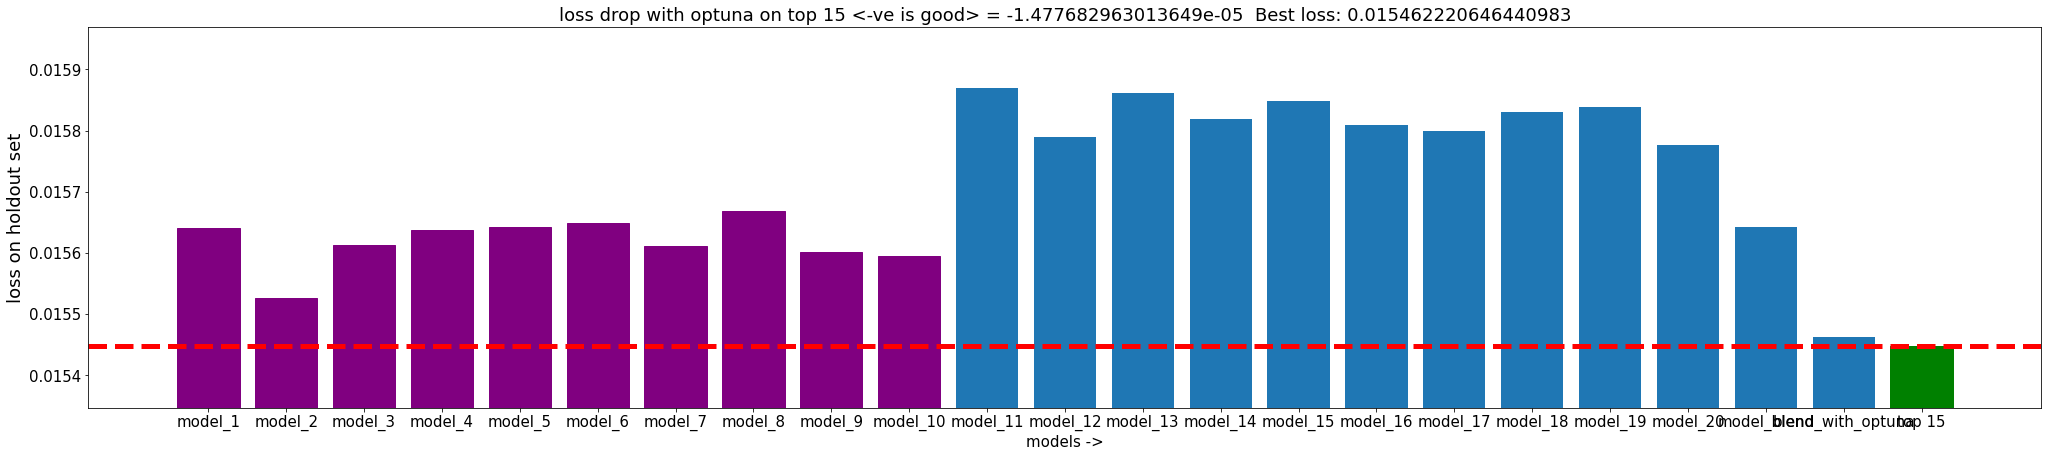

In [178]:
plt.rcParams.update({'font.size': 15})

names = test_val_losses.keys()
vals = test_val_losses.values()
bars = plt.bar(names, vals)

for i in range(10):
    bars[i].set_color("purple")


bars[-1].set_color("g")
plt.ylim(min(vals)- .0001, max(vals) + 0.0001)
plt.ylabel("loss on holdout set", fontsize = 18)
plt.xlabel("models ->", fontsize = 15)
plt.axhline(y = min(vals), linestyle = "--", c = "r", linewidth = 5)
plt.title("loss drop with optuna on top 15 <-ve is good> = " + str(test_val_losses["top 15"] - test_val_losses["blend_with_optuna"]) + "  Best loss: " + str(test_val_losses["top 15"]))
plt.show()